# Assignment 10 - 705.603 - AWS Blackjack Optimization 
## Student Name: Ravindra Sadaphule

### Explanation:
The architecture of our agent's neural network is simple, consisting of three fully connected layers and ReLU activation functions. The input represents the current state, while the output provides action probabilities. The action with the highest probability is selected.

Initially, we set epsilon (ε) to 0.99, which means the agent has a 99% likelihood of taking a random action in the first hand for exploration purposes. The epsilon decay rate is set to 0.995, allowing ε to decrease over time and enabling the agent to increasingly exploit prior experiences in its decision-making. We also establish a lower ε boundary of 0.02 to ensure exploration throughout the training process.

Furthermore, we assign a discount factor (γ) of 0.99 to our agent, emphasizing the significance of immediate rewards since a single Blackjack game could end right after the cards are dealt. We set the learning rate (α) to 3e-4.

A critical aspect of all Reinforcement Learning algorithms is the reward function. We use OpenAI's Blackjack environment for training, which provides a +1 reward for winning and -1 for losing. However, this does not enable our agent to consider position (bet) size and learn about risk management.

To address this limitation, we multiply the reward by the raw probability derived from our agent's neural network output. This approach allows the agent to place larger bets on hands it deems more favorable and smaller bets on less favorable hands.

This code is run aws sagemaker. The diffference is I am using aws s3 to save and load checkpoint file.  


## Blackjack

### Environment Details

    ### Action Space
    There are two actions: stick (0), and hit (1).
    
    ### Observation Space
    Tuple(Discrete(32), Discrete(11), Discrete(2))
    The observation consists of a 3-tuple containing: 
        1. the player's current sum
        2. the value of the dealer's one showing card (1-10 where 1 is ace)
        3. whether the player holds a usable ace (0 or 1).
        
    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:
        +1.5 (if natural is True)
        +1 (if natural is False)

In [142]:
! pip install -U gym
! pip install -U torch
! pip install gym[toy_text]

In [143]:
!pip install numpy matplotlib boto3

In [144]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()

In [145]:
print(role)

arn:aws:iam::966444174817:role/aws-sagemaker-role


In [146]:
bucket_name = 'ravindrasadaphule-s3-bucket2' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


# Import libraries and Create Class to Display Cards

In [147]:
!pip install gym

In [148]:
!pip install pygame

In [149]:
import sagemaker
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
import boto3

In [150]:
# run in local mode?
local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.m4.4xlarge"

In [151]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::966444174817:role/aws-sagemaker-role


### Train RLEstimator with DWL for Blackjack.
### The actual Training code is located in blackjack_train.py

In [152]:

# Specify S3 bucket and prefix
sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker_session.default_bucket()
s3_output_path = f's3://{s3_bucket}/blackjack/'


In [153]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display

class JupyterDisplay(object):
    def __init__(self, figsize: tuple):
        self.figsize = figsize
        self.mode = "rgb_array"
    
    def show(self, env):
        plt.figure(figsize=self.figsize)
        plt.imshow(env.render())               # Removed render mode for compatibility
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())


## Create Blackjack Environment and test methods


env = gym.make("Blackjack-v1")
env.observation_space

In [154]:
env.action_space

Discrete(2)

In [155]:
env.reset(seed=42)

((15, 2, False), {})

## Q-Learning Functions

### function get_state_idxs

This is a function that retrieves the three values from a returned state.

In [156]:
def get_state_idxs(state):
    idx1, idx2, idx3 = state
    idx3 = int(idx3)
    return idx1, idx2, idx3

### function update_qtable

## function `update_qtable`

Function that uses the Bellman equation to update a qtable given a learning rate and a discount faactor. 

Arguments:
- qtable - numpy array with dimension for each of three state description lus a dimension for each action
- state - tuple of shape (idx1, idx2, idx3) where idx 1 and 2 are integers and idx 3 is a bool. idx 1 2 and 3 are described above.
- action - int represeting Hit(1) or Stick(0)
- reward - float representing reward for a given step
- next_state - the next state resulting from action.
- alpha - learning rate
- gamma - discount factor

Returns: Updated qtable

In [157]:
def update_qtable(qtable, state, action, reward, next_state, alpha, gamma):
    curr_idx1, curr_idx2, curr_idx3 = get_state_idxs(state)
    next_idx1, next_idx2, next_idx3 = get_state_idxs(next_state)
    curr_state_q = qtable[curr_idx1][curr_idx2][curr_idx3]
    next_state_q = qtable[next_idx1][next_idx2][next_idx3]
    qtable[curr_idx1][curr_idx2][curr_idx3][action] += \
            alpha * (reward + gamma * np.max(next_state_q) - curr_state_q[action])
    return qtable


## function `get_action`

Function that obatins the action to be taken as either exploration or exploitation

Arguments:
- qtable - numpy array with dimension for each of three state description lus a dimension for each action
- state - tuple of shape (idx1, idx2, idx3) where idx 1 and 2 are integers and idx 3 is a bool. idx 1 2 and 3 are described above.
- epsilon - float representing likelihood of action being random exploration.

Returns: int for action

In [158]:
def get_action(qtable, state, epsilon):
    if random.uniform(0,1) < epsilon:
        action = env.action_space.sample()
    else:
        idx1, idx2, idx3 = get_state_idxs(state)
        action = np.argmax(qtable[idx1][idx2][idx3])
    return action

## function `train_agent`

Function that develops q table by playing game with passed parameters.  This function required some modification as that original was for an older version of gym.  Mods are noted below.

Arguments:
- env - The blackjack gym environment
- qtable - numpy array with dimension for each of three state description plus a dimension for each action
- num_episodes - int for number of games to play
- alpha - float learning rate
- gamma - float discount factor
- epsilon - float representing likelihood of action being random exploration.
- epsilon_decay - float rate of decline of epsilon

Returns: qtable for trained policy

In [159]:
def train_agent(env,
                qtable: np.ndarray,
                num_episodes: int,
                alpha: float, 
                gamma: float, 
                epsilon: float, 
                epsilon_decay: float) -> np.ndarray:

    for episode in range(num_episodes):
        state, _ = env.reset()                                     # Added blank for extra returned argument
        done = False
        while True:
            action = get_action(qtable, state, epsilon)
            new_state, reward, done, _, info = env.step(action)    # Added blank for extra returned argument
            qtable = update_qtable(qtable, state, action, reward, new_state, alpha, gamma)
            state = new_state
            if done:
                break
        epsilon = np.exp(-epsilon_decay*episode)
    return qtable

## function `watch_trained_agent`

Function that plays blackjack with provided qtable as policy.  This function required some modification as that original was for an older version of gym.  Mods are noted below.

Arguments:
- env - The blackjack gym environment
- qtable - numpy array with dimension for each of three state description plus a dimension for each action
- num_rounds - int for number of games to play

Returns: list of rewards

In [160]:
FIGSIZE = (8,4)

def watch_trained_agent(env, qtable, num_rounds):
    envdisplay = JupyterDisplay(figsize=FIGSIZE)
    rewards = []
    for s in range(1, num_rounds+1):
        state, _ = env.reset()
        done = False
        round_rewards = 0
        while True:
            action = get_action(qtable, state, epsilon)          
            new_state, reward, done, _, info = env.step(action)  # Added blank for extra returned argument
            envdisplay.show(env)

            round_rewards += reward
            state = new_state
            if done == True:
                break
        rewards.append(round_rewards)
    return rewards

## function `watch_trained_agent_no_exploration`

Function that plays blackjack with provided qtable as policy.  This function required soem modification as that original was for an older version of gym.  Mods are noted below.  This function has epsilon set to zero.

Arguments:
- env - The blackjack gym environment
- qtable - numpy array with dimension for each of three state description lus a dimension for each action
- num_rounds - int for number of games to play

Returns: list of rewards

In [161]:
FIGSIZE = (8,4)

def watch_trained_agent_no_exploration(env, qtable, num_rounds):
    envdisplay = JupyterDisplay(figsize=FIGSIZE)
    rewards = []
    for s in range(1, num_rounds+1):
        state, _ = env.reset()
        done = False
        round_rewards = 0
        while True:
            action = get_action(qtable, state, 0)                # epsilon set to 0
            new_state, reward, done, _, info = env.step(action)  # Added blank for extra returned argument
            envdisplay.show(env)

            round_rewards += reward
            state = new_state
            if done == True:
                break
        rewards.append(round_rewards)
    return rewards

# Q-Learning Execution

## Train

In [162]:
def print_policy(qtable):
    print('PC DC Soft Pol')
    dim1, dim2, dim3, dim4 = qtable.shape
    for player_count in range(10,21):
        for dealer_card in range(dim2):
            for soft in range(dim3):
                q_stay = qtable[player_count, dealer_card, soft, 0]
                q_hit  = qtable[player_count, dealer_card, soft, 1]
                pol = "Stay" if q_stay>=q_hit else "Hit"
                print(player_count+1, dealer_card+1, soft, pol)

In [163]:
env = gym.make("Blackjack-v1")
env.action_space.seed(42)

# get initial state
state = env.reset()

state_size = [x.n for x in env.observation_space]
action_size = env.action_space.n

qtable = np.zeros(state_size + [action_size]) #init with zeros


alpha = 0.3 # learning rate
gamma = 0.1 # discount rate
epsilon = 0.9     # probability that our agent will explore
decay_rate = 0.005

# training variables
num_hands = 500_000

qtable = train_agent(env,
                     qtable,
                     num_hands,
                     alpha,
                     gamma,
                     epsilon,
                     decay_rate)

print(f"Qtable Max: {np.max(qtable)}")
print(f"Qtable Mean: {np.mean(qtable)}")
print(f"Qtable Num Unique Vals: {len(np.unique(qtable))}")

Qtable Max: 1.1111111111111105
Qtable Mean: -0.09653497500953848
Qtable Num Unique Vals: 392


In [164]:
!pip install gym

In [165]:
!pip install pygame

## Test as provided

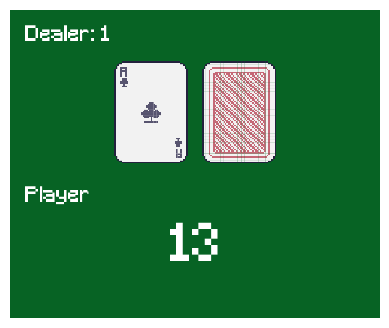

In [166]:
# Watch trained agent
env = gym.make("Blackjack-v1", render_mode='rgb_array')    # Added render mode for compatibility
#env.action_space.seed(42)
rewards = watch_trained_agent(env, qtable, num_rounds=100)
env.close()

## Output reward over hands played

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


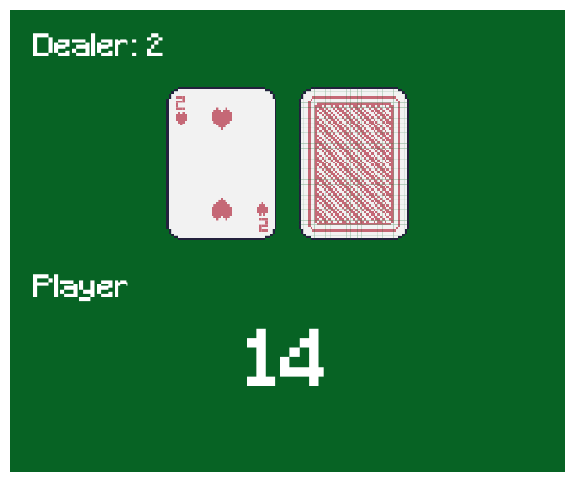

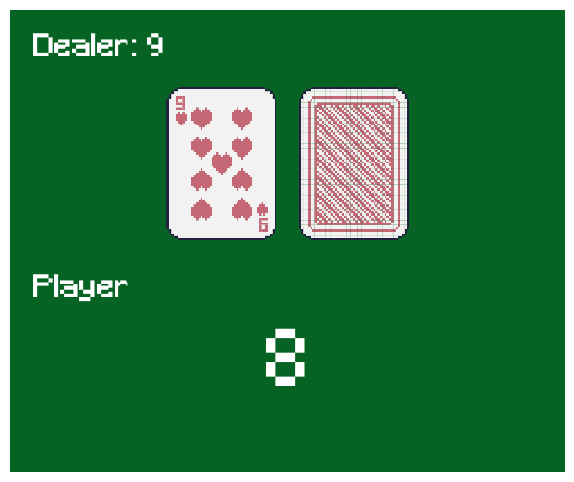

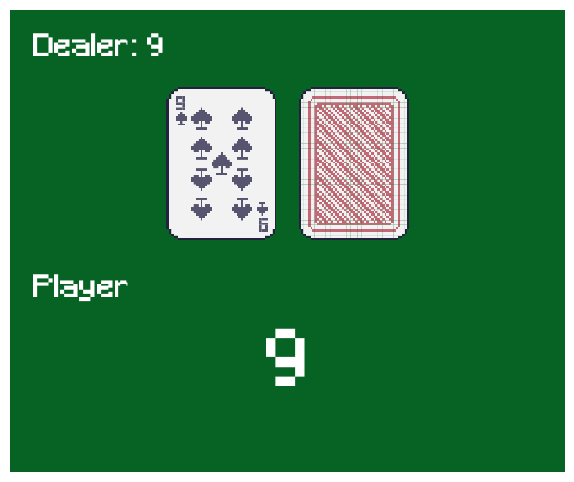

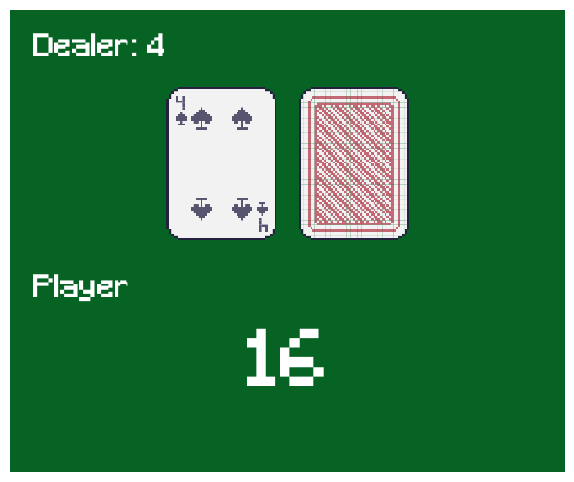

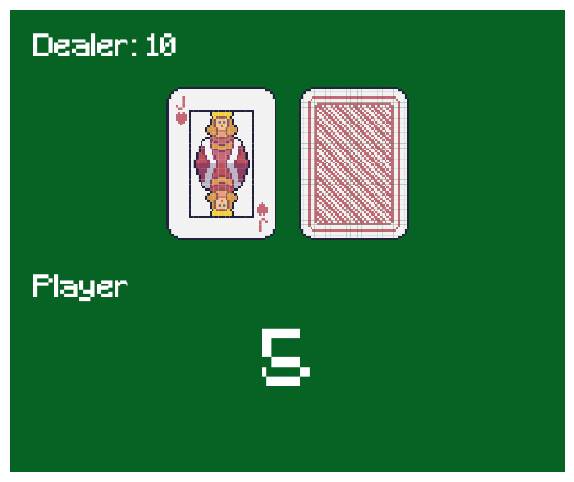

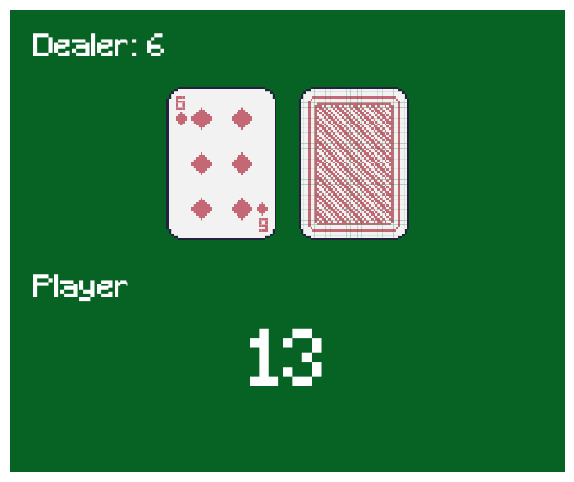

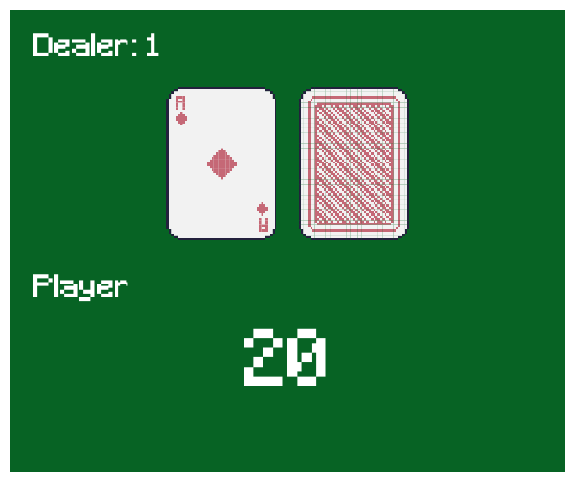

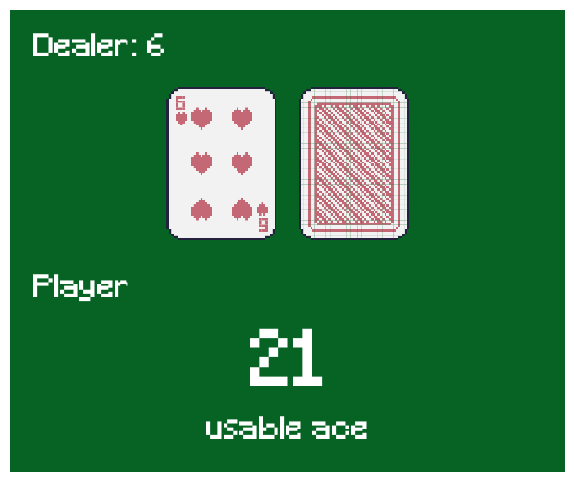

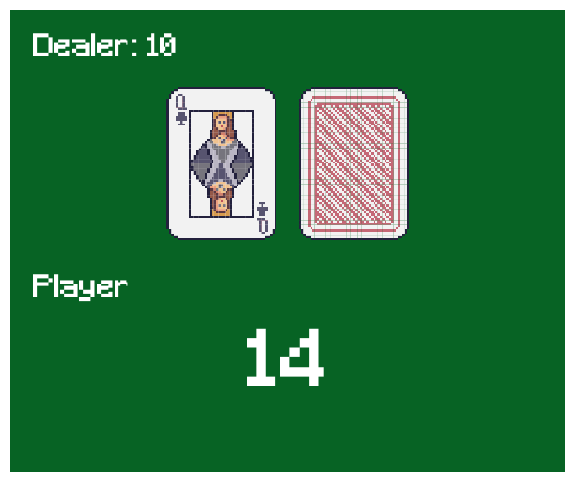

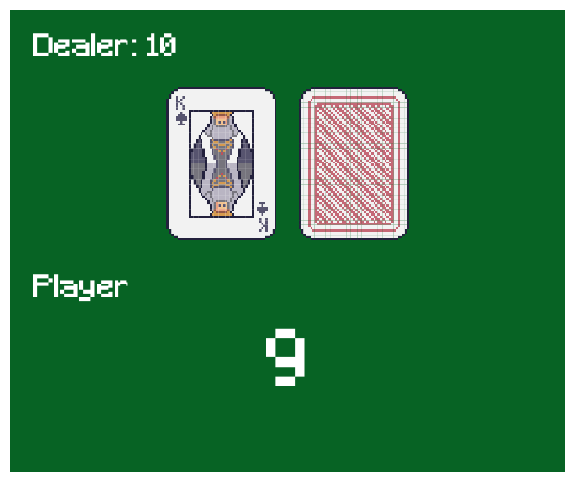

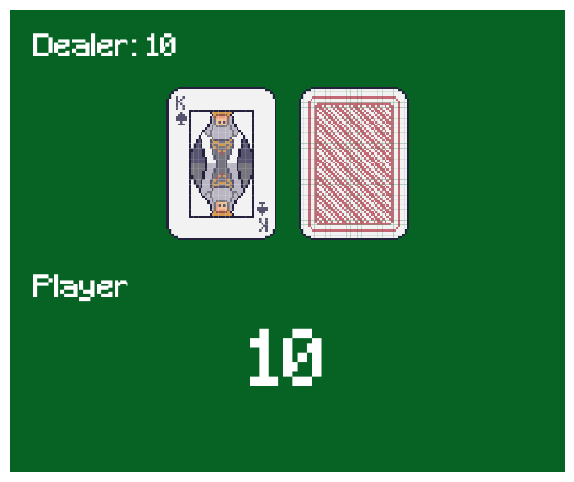

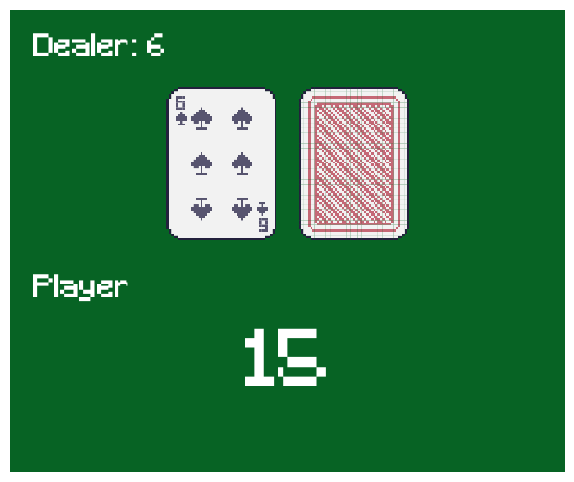

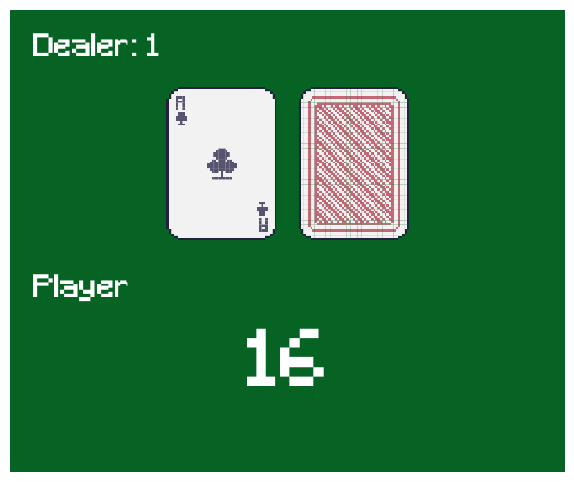

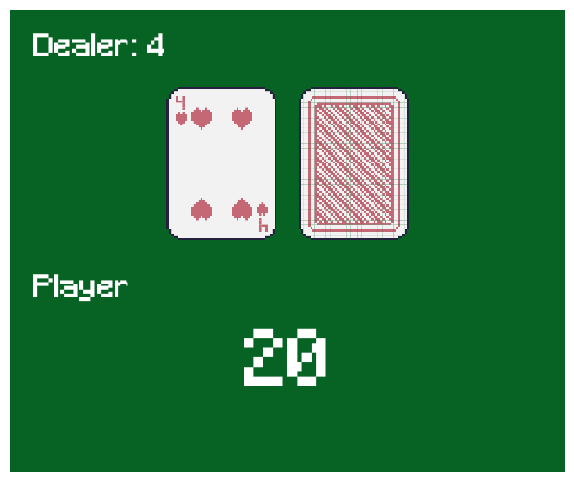

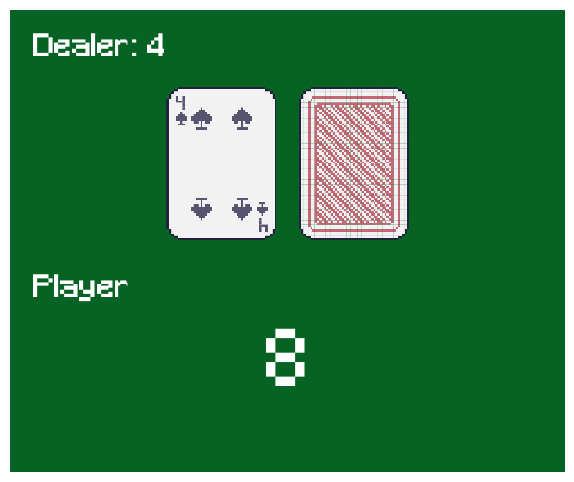

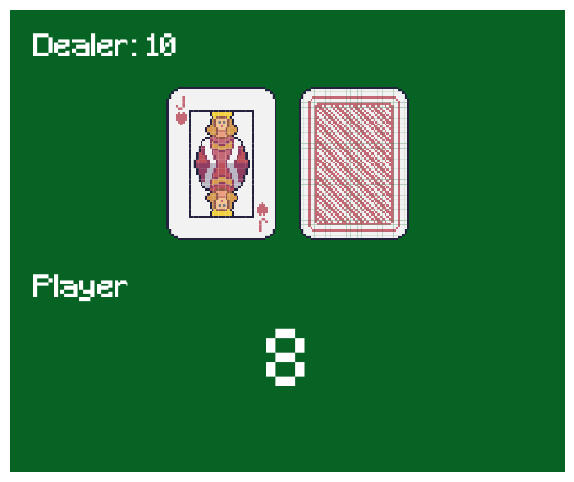

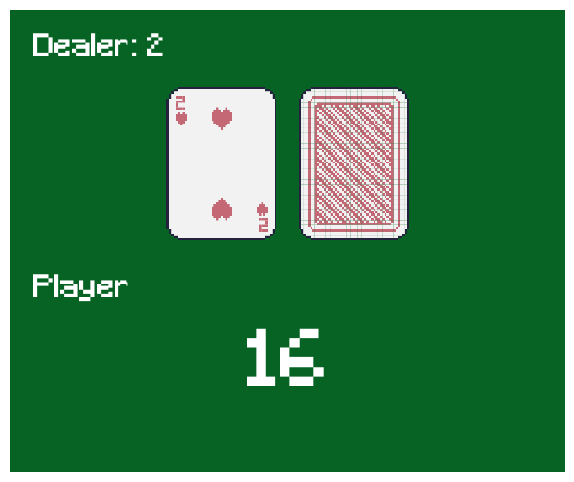

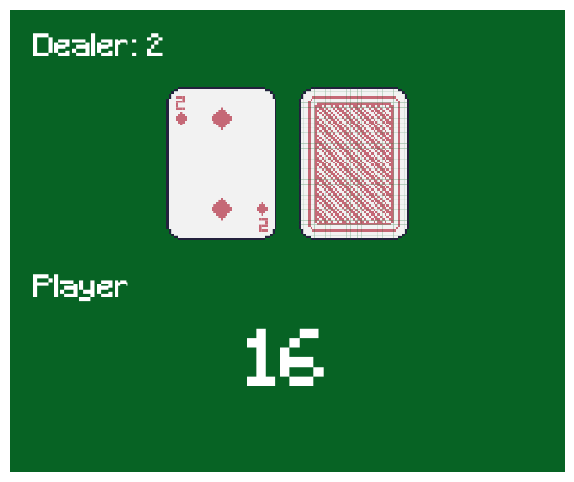

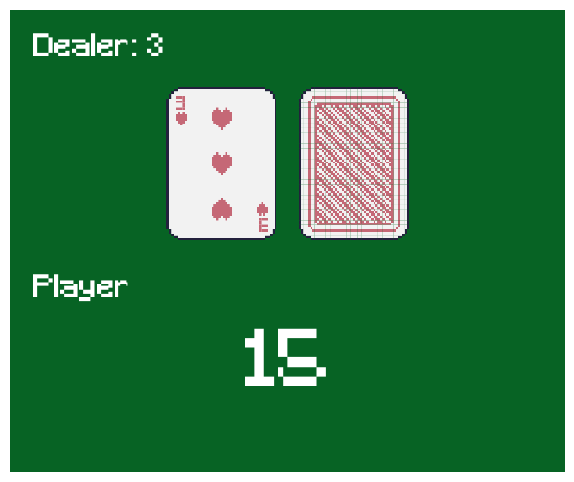

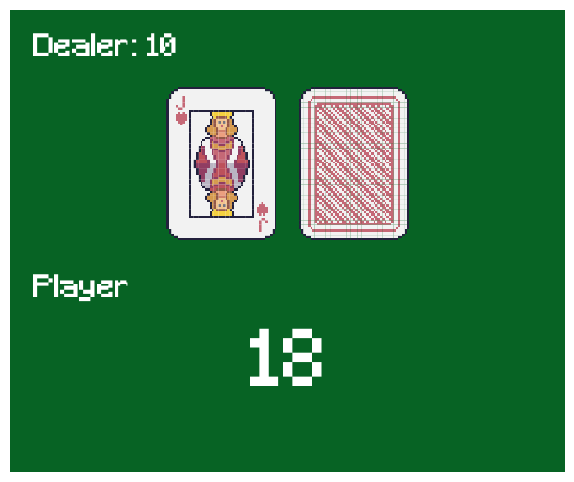

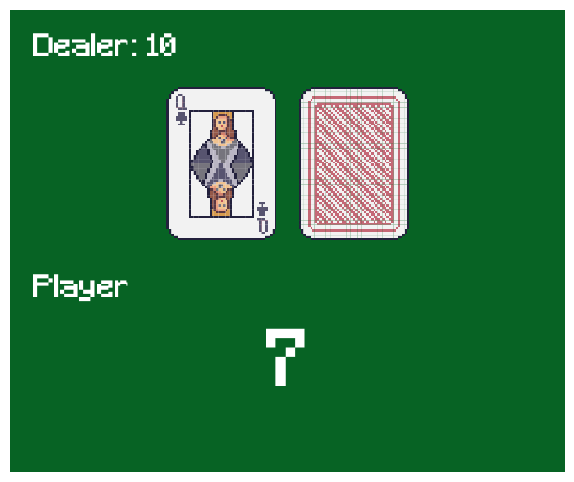

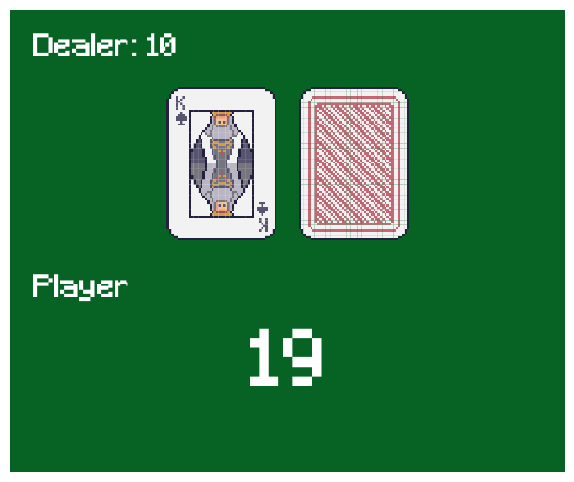

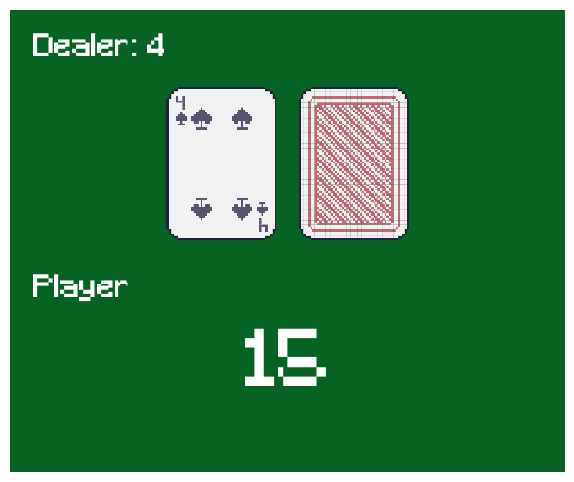

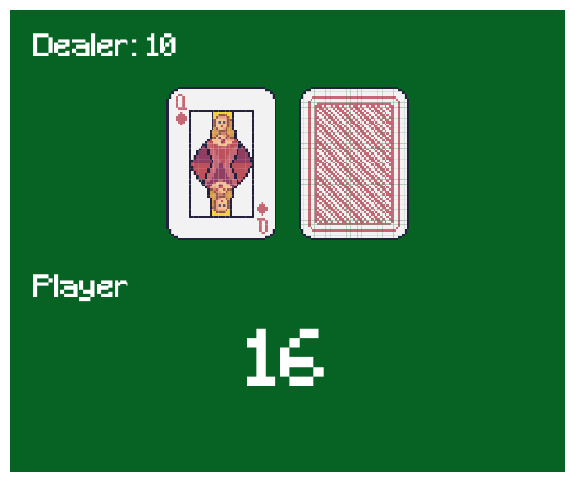

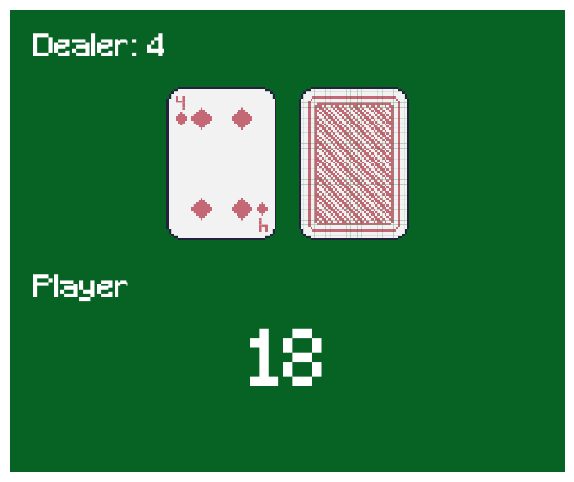

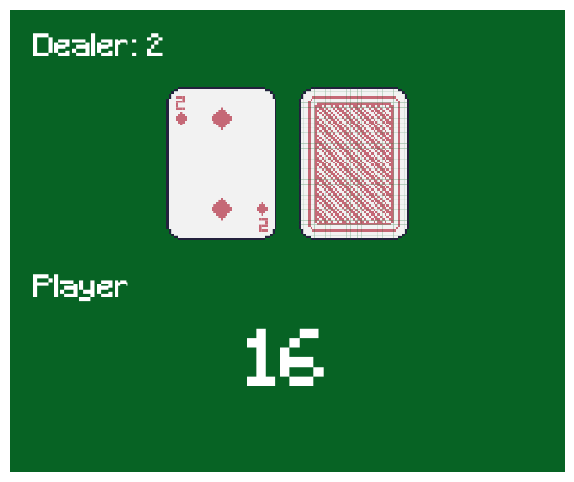

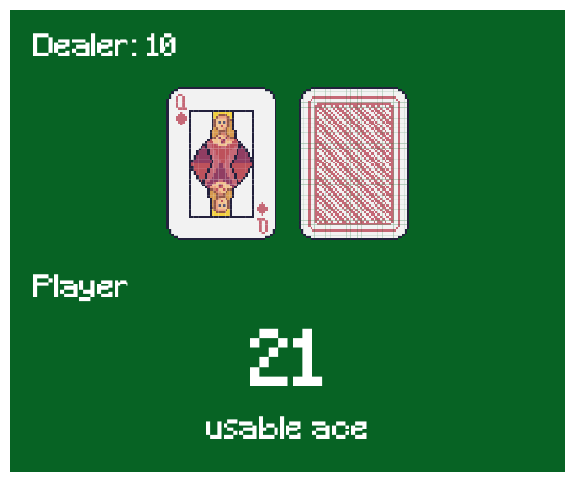

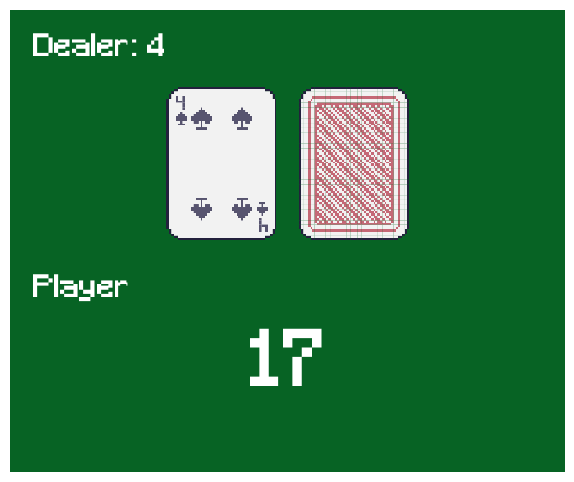

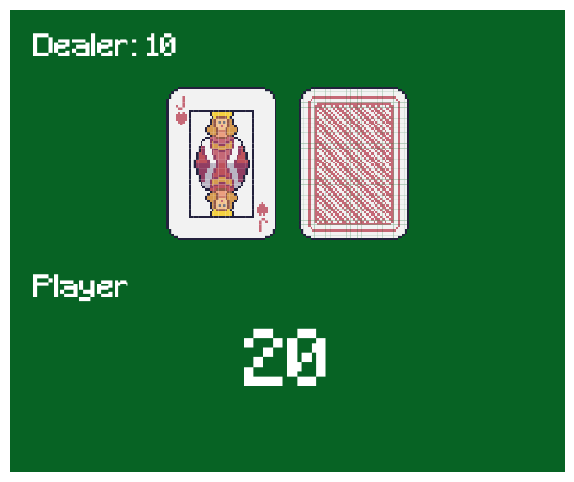

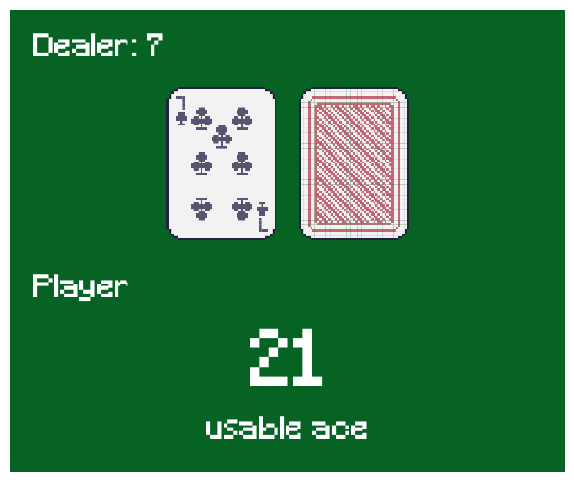

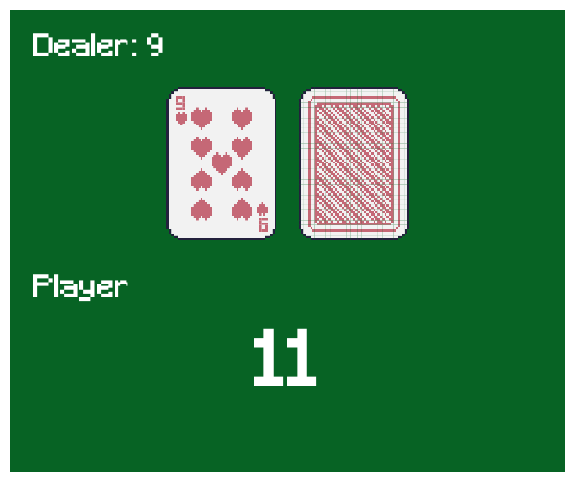

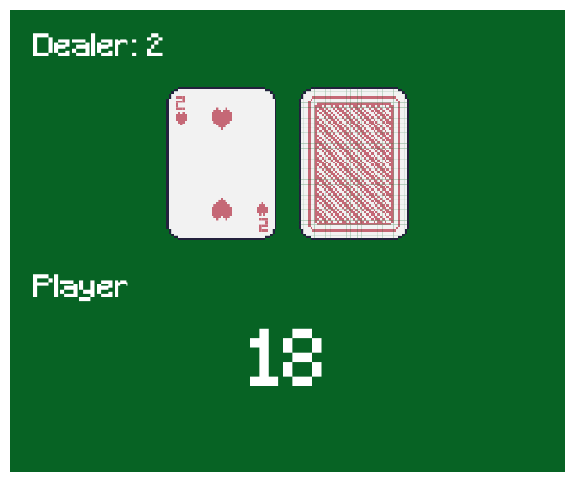

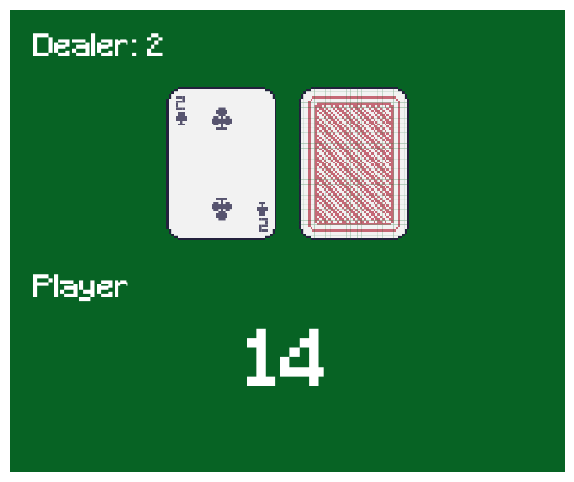

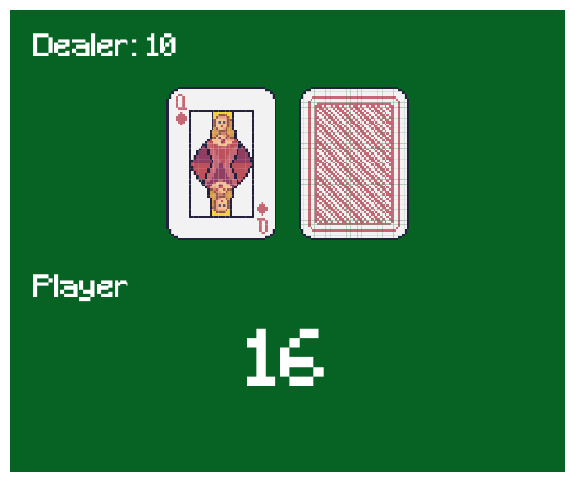

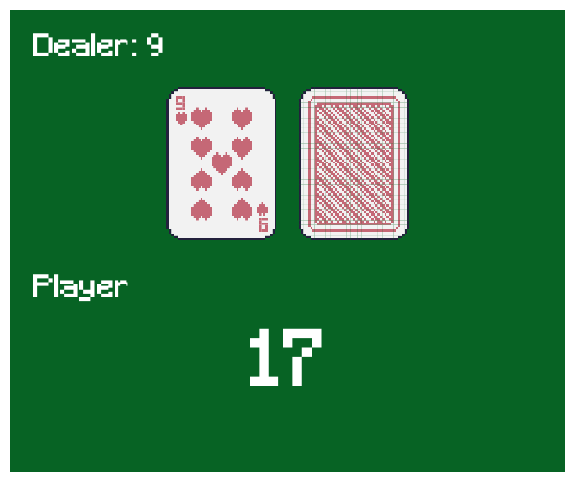

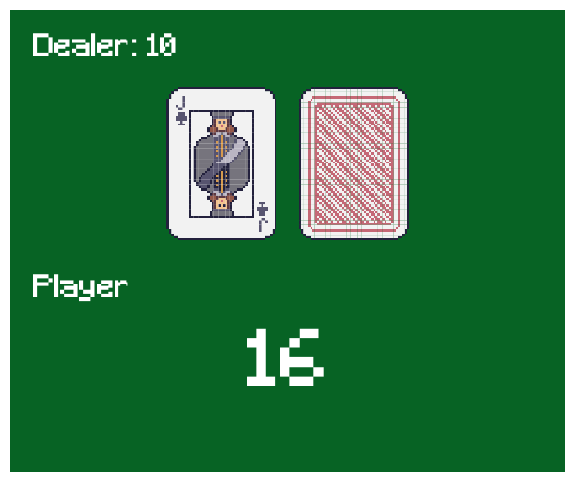

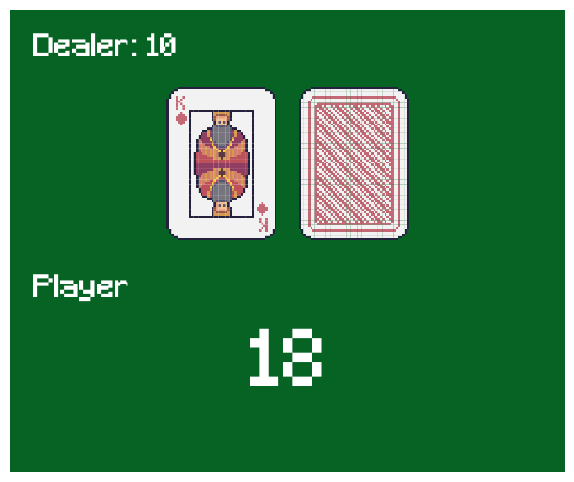

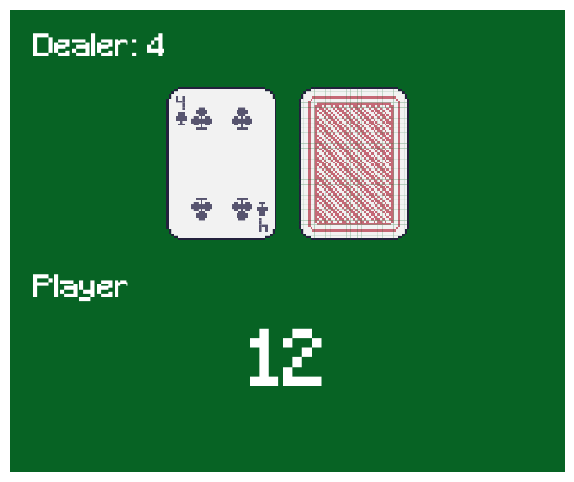

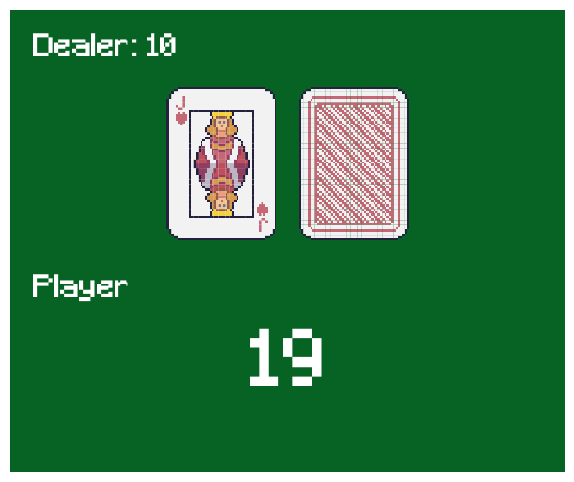

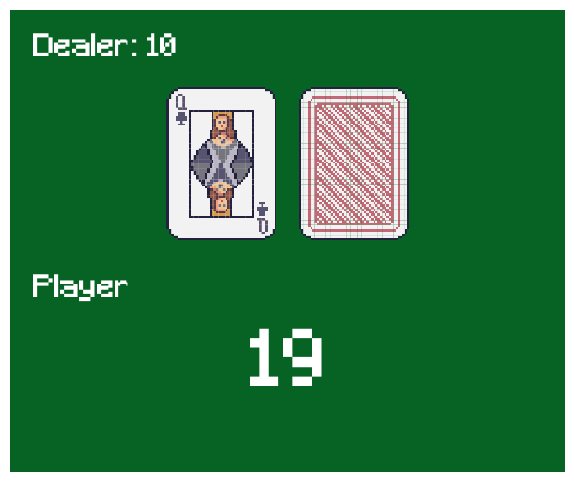

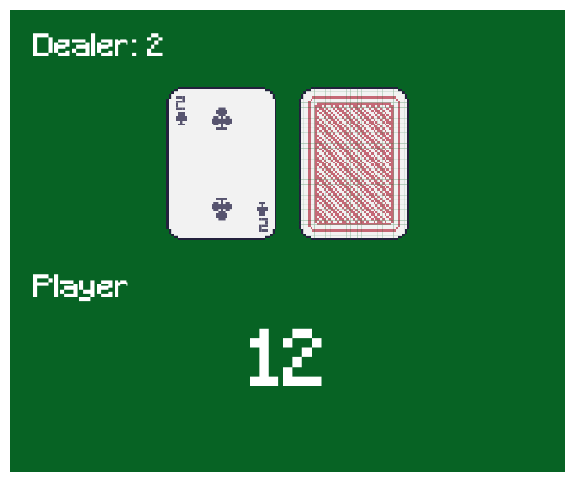

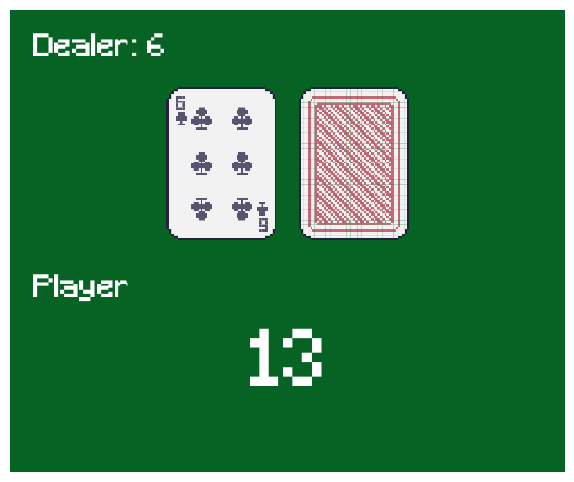

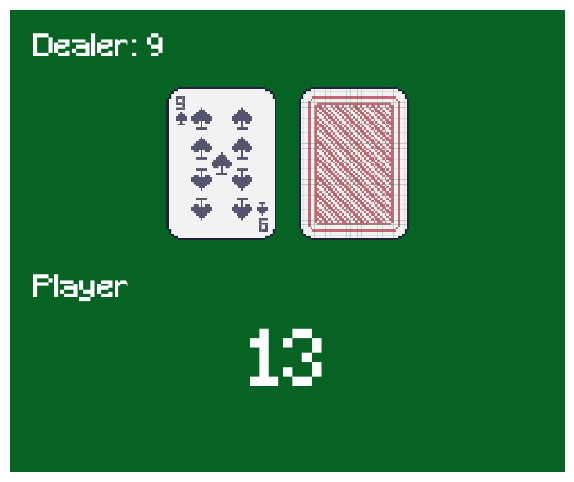

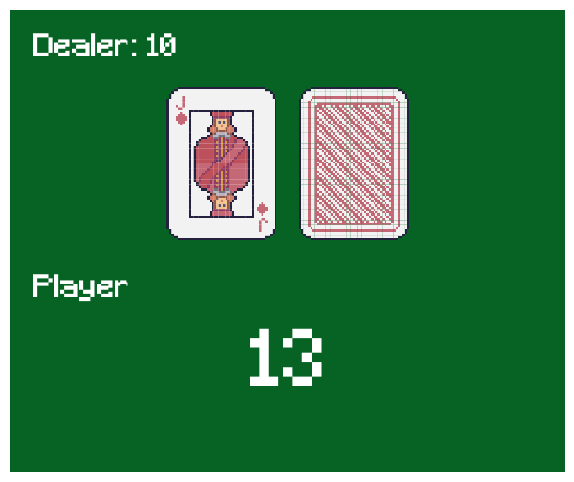

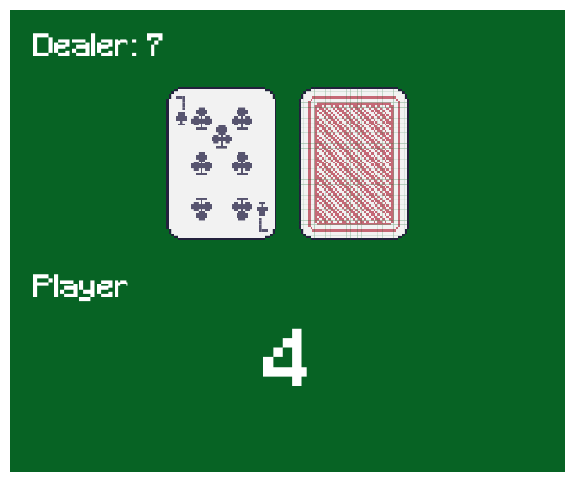

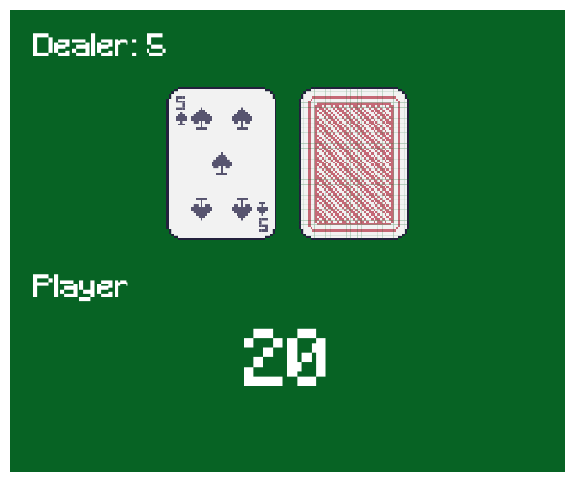

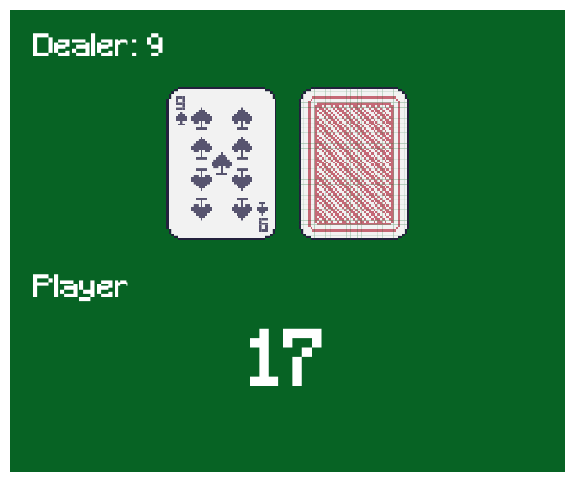

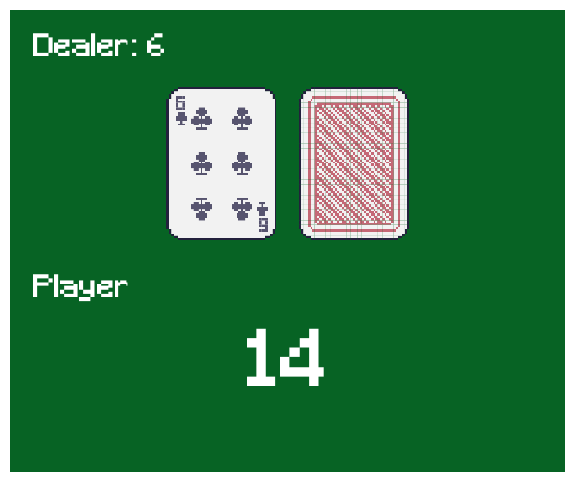

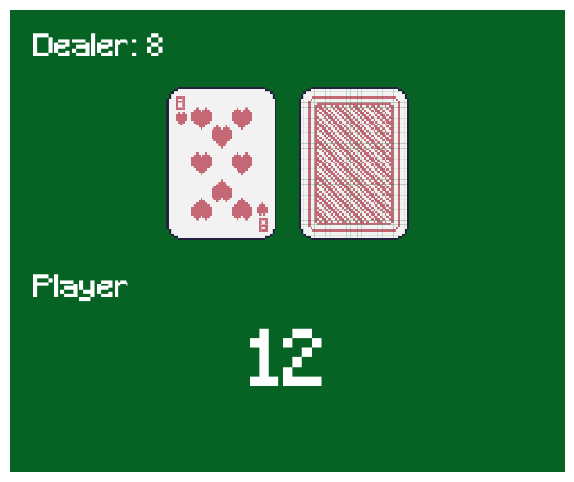

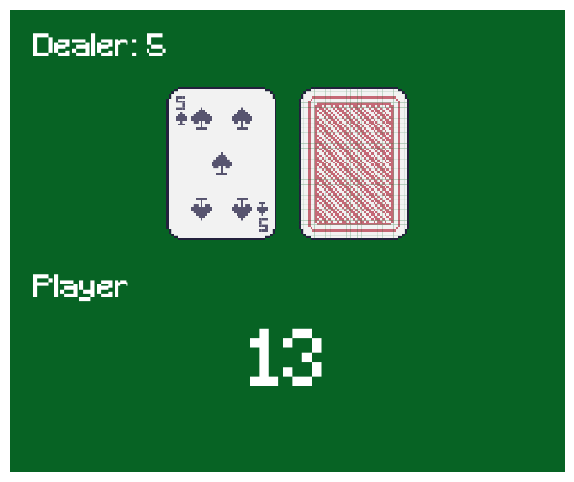

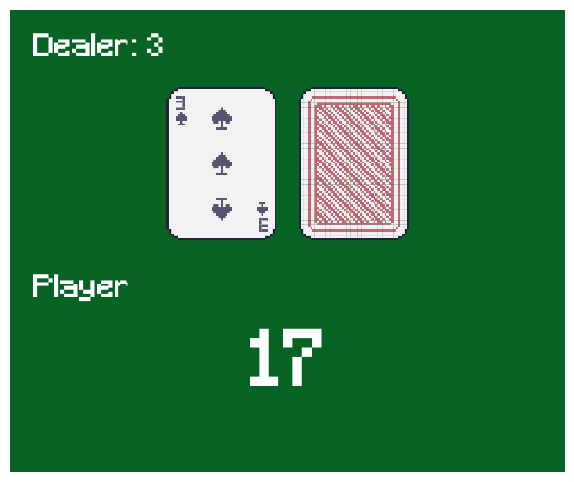

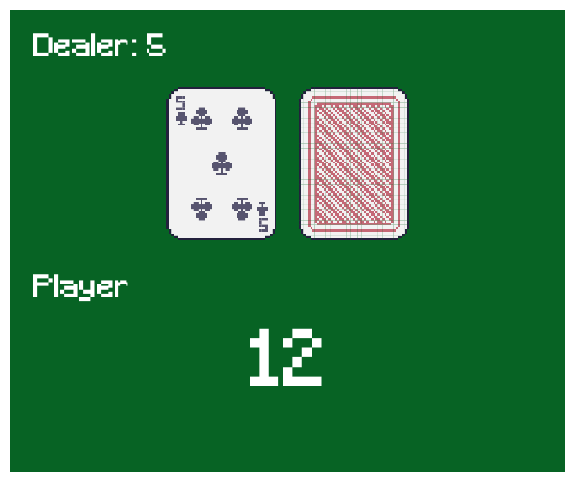

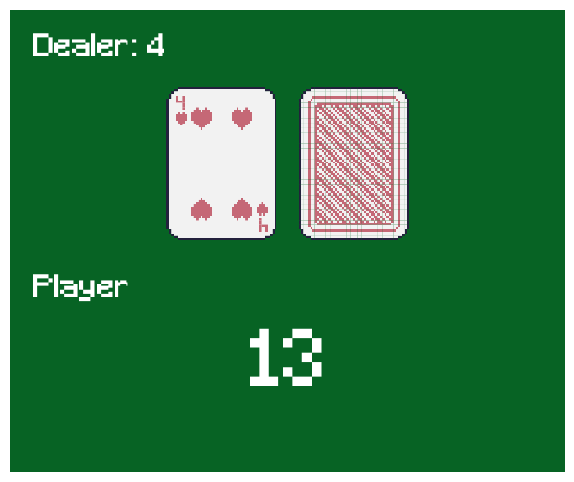

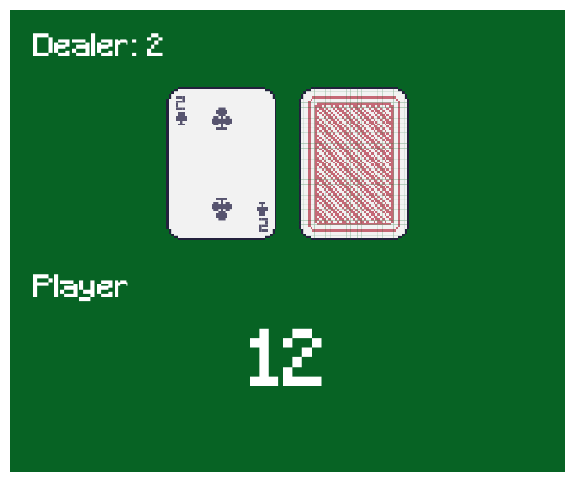

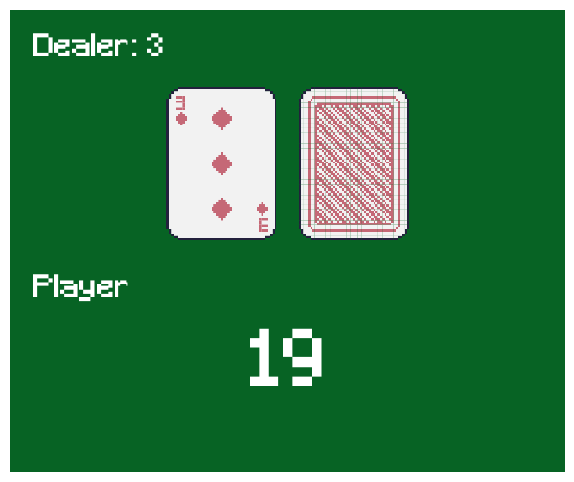

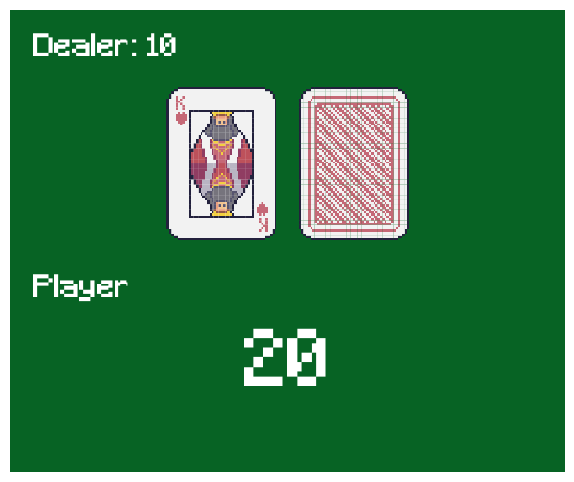

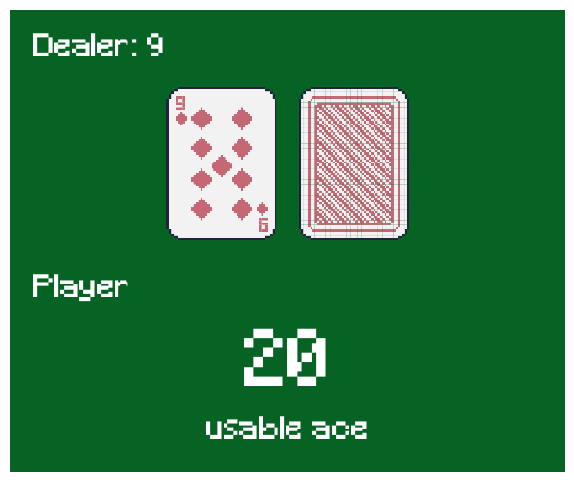

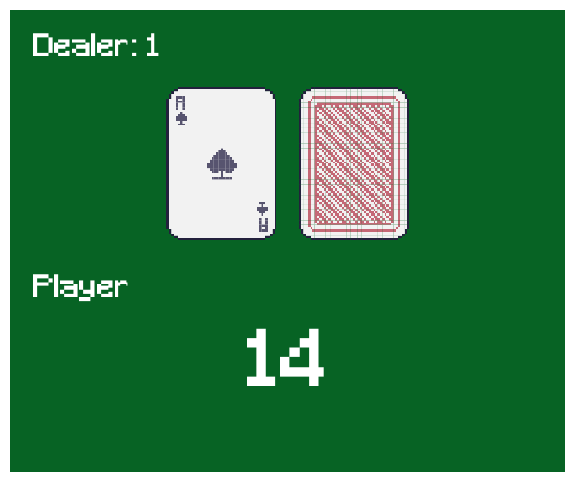

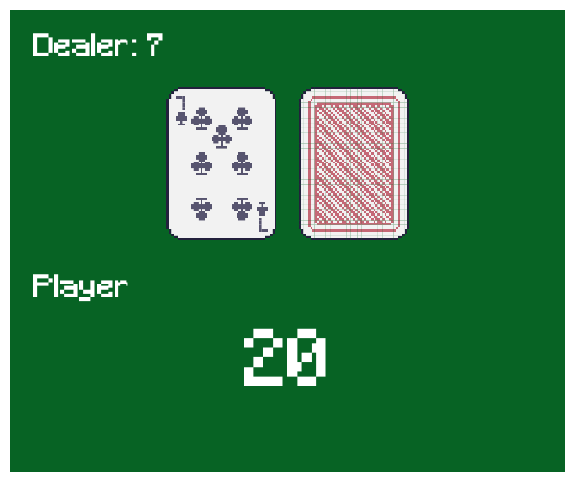

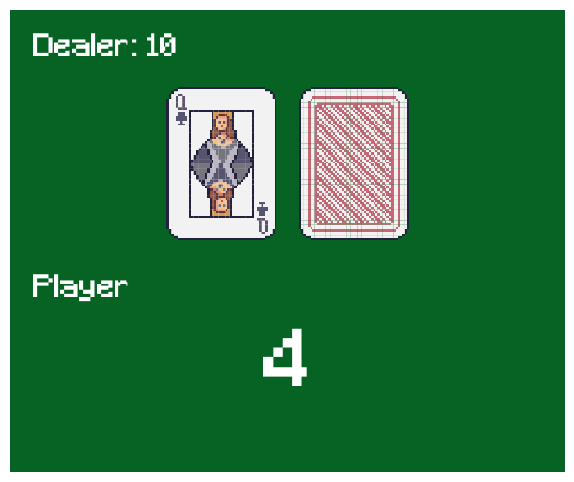

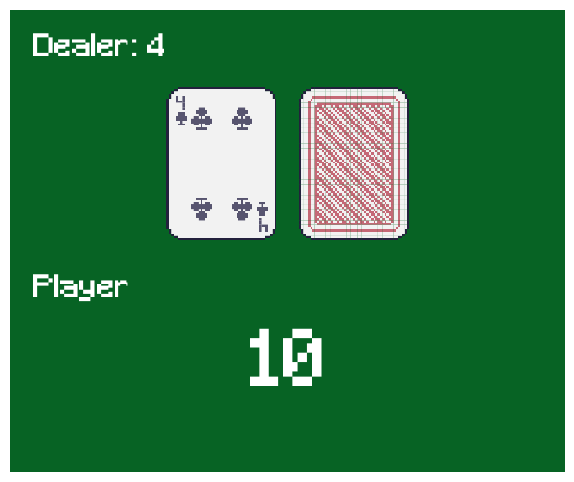

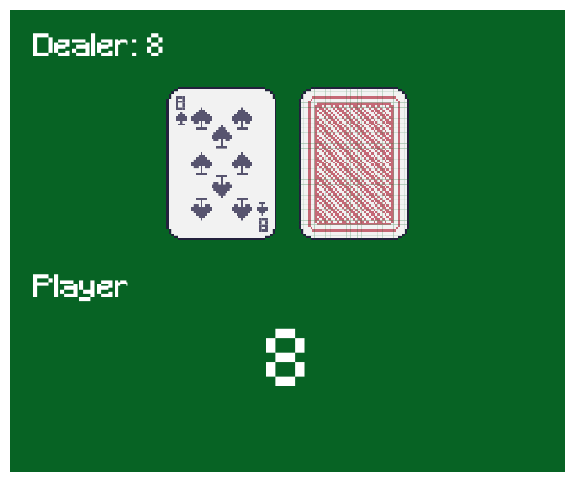

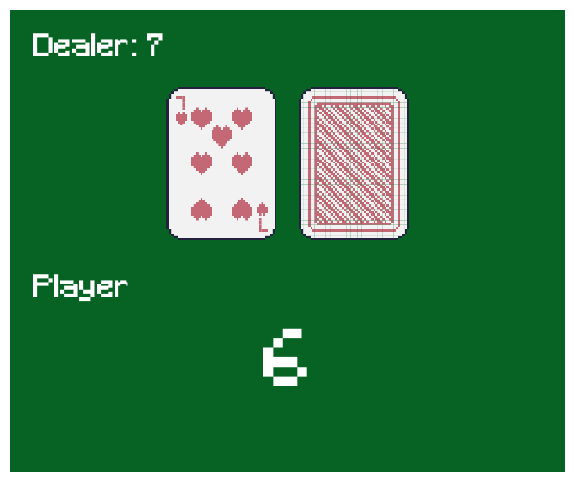

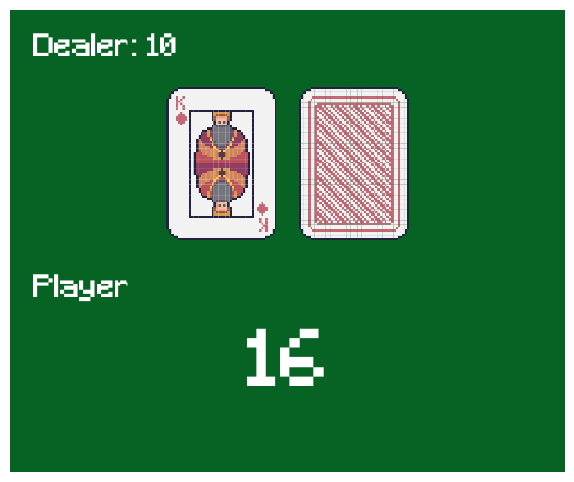

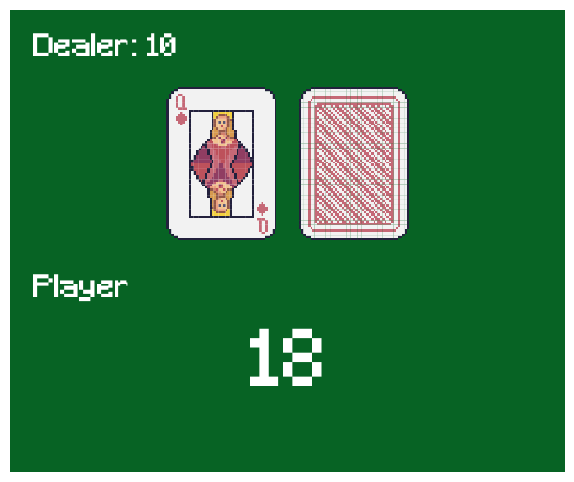

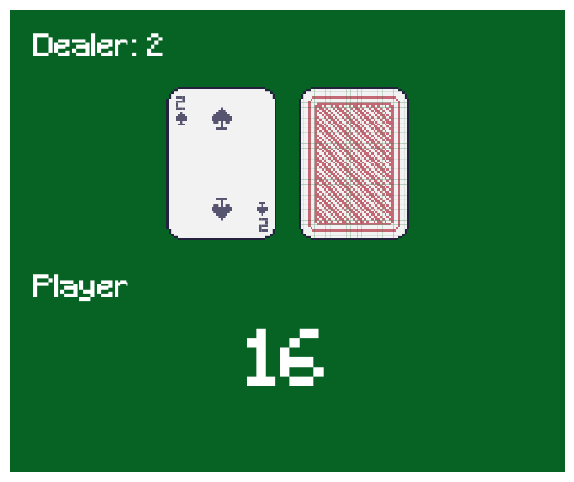

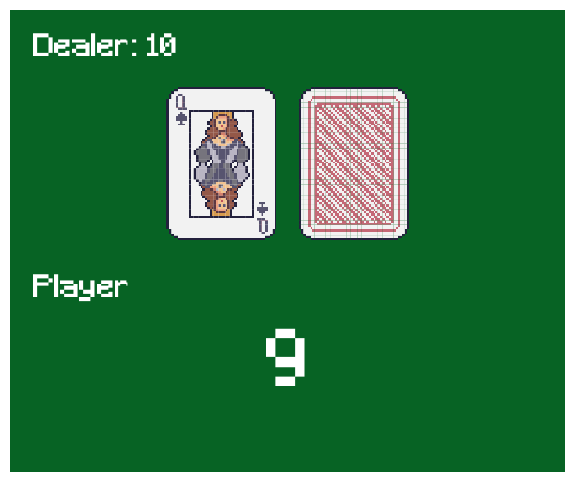

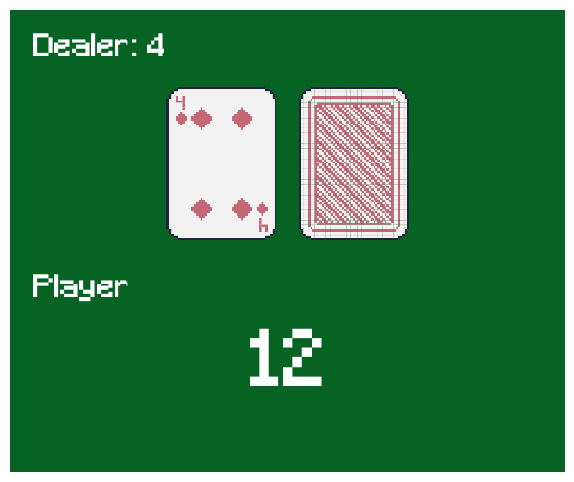

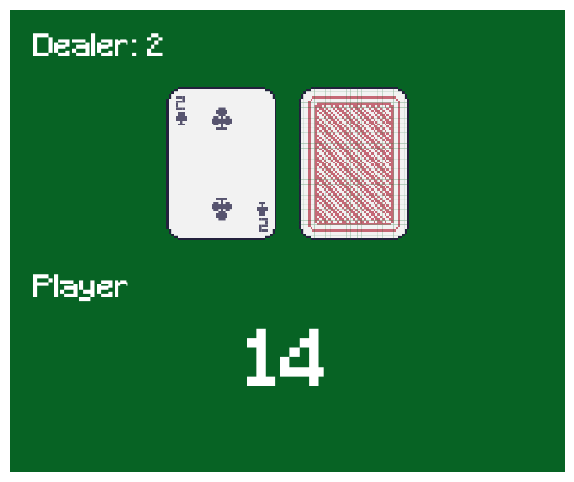

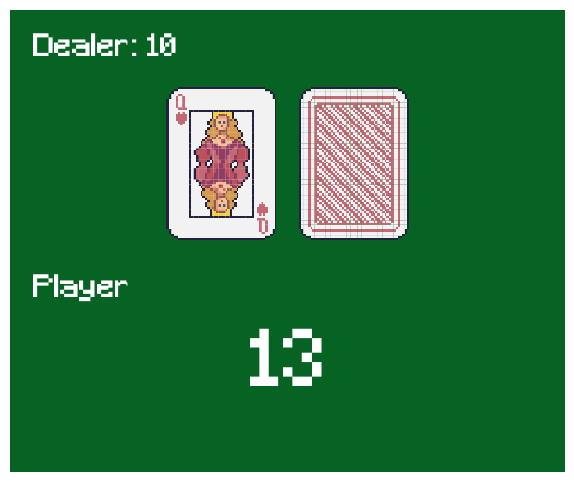

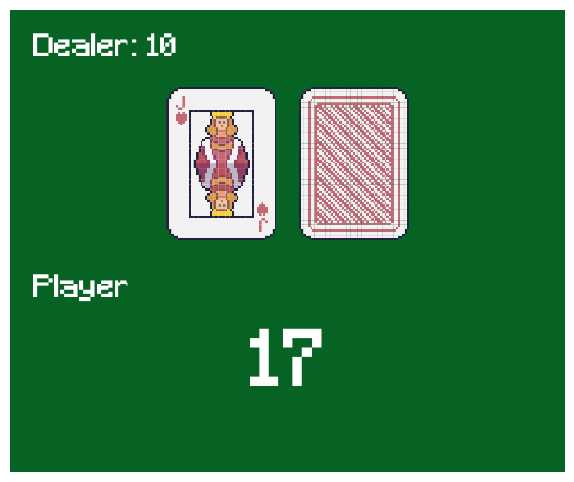

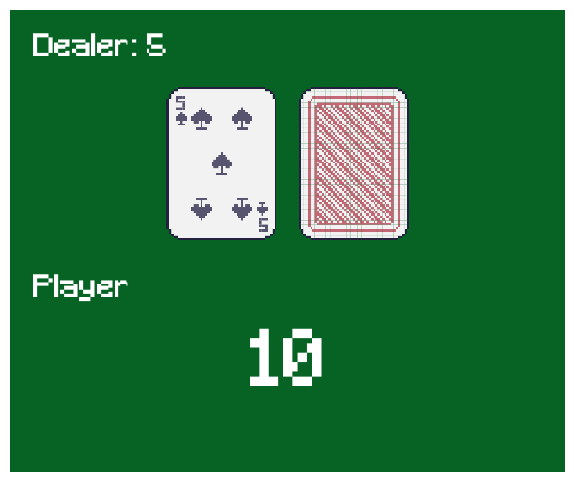

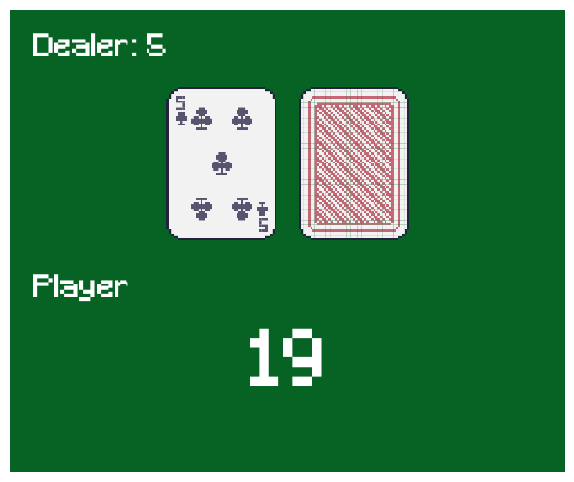

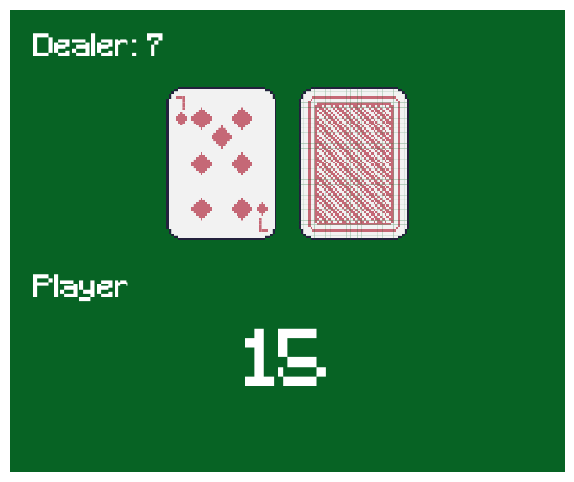

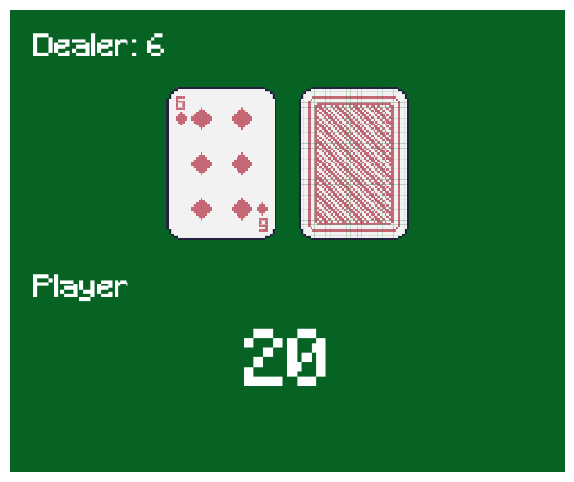

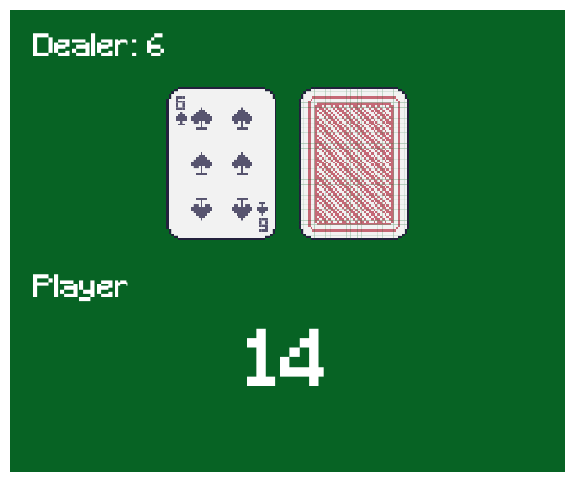

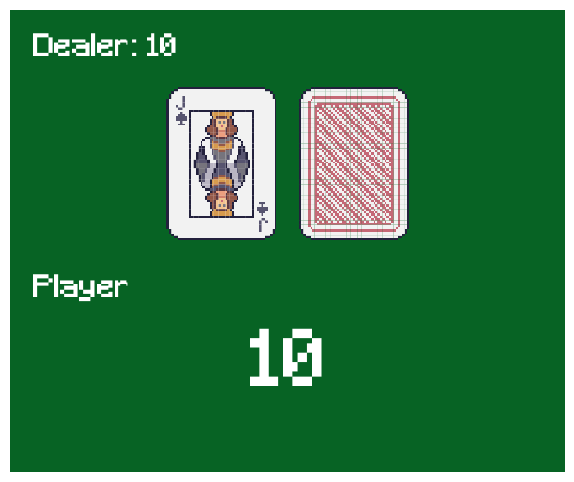

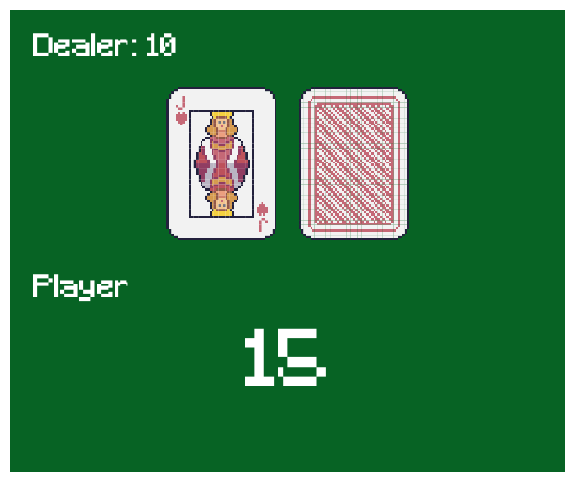

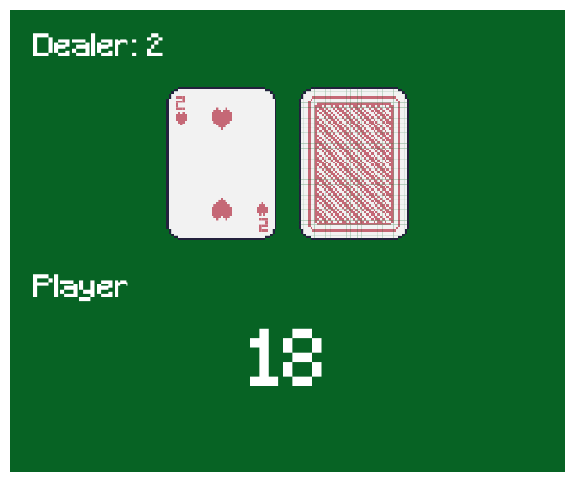

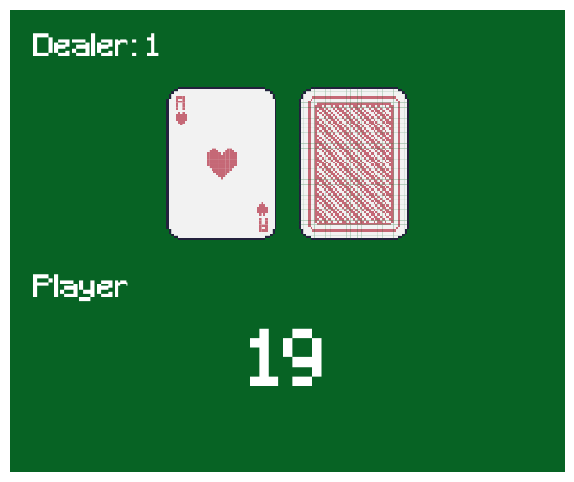

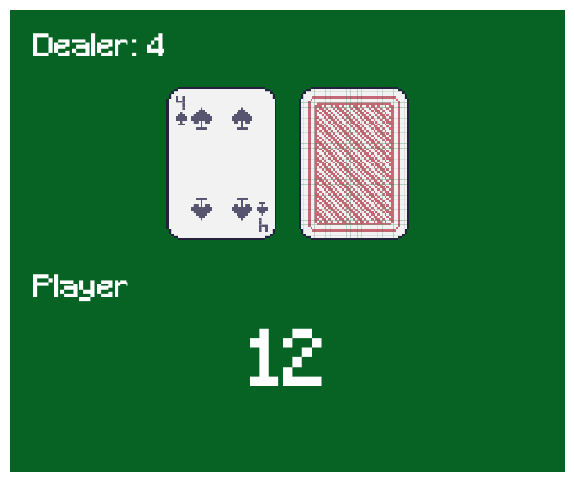

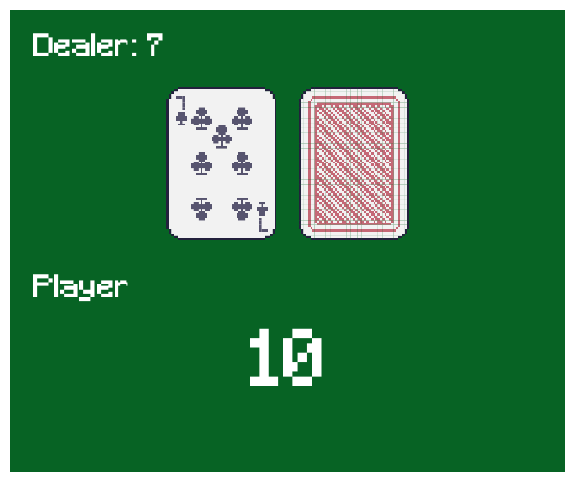

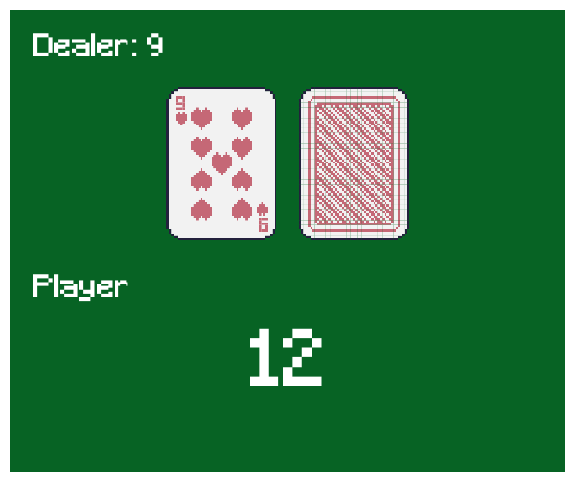

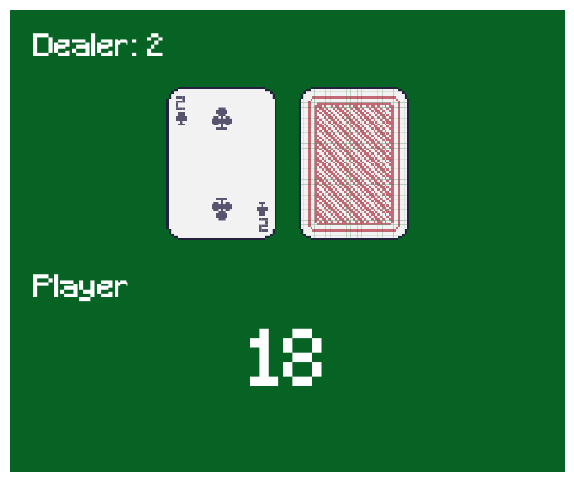

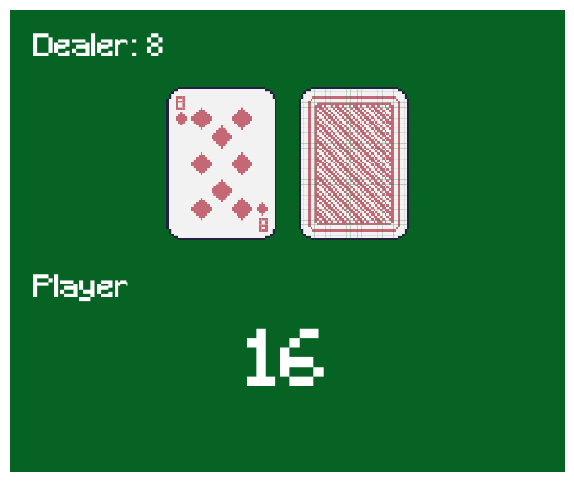

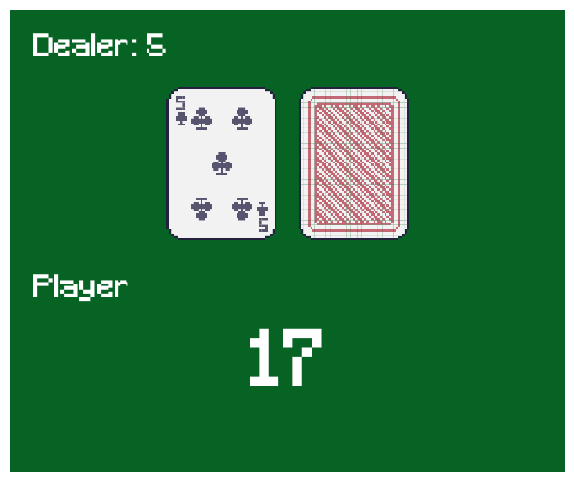

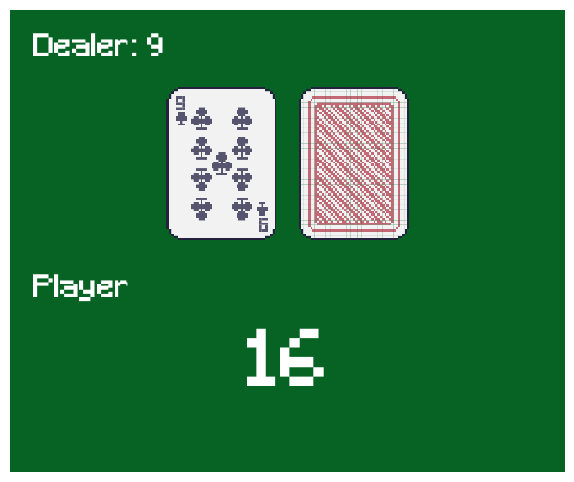

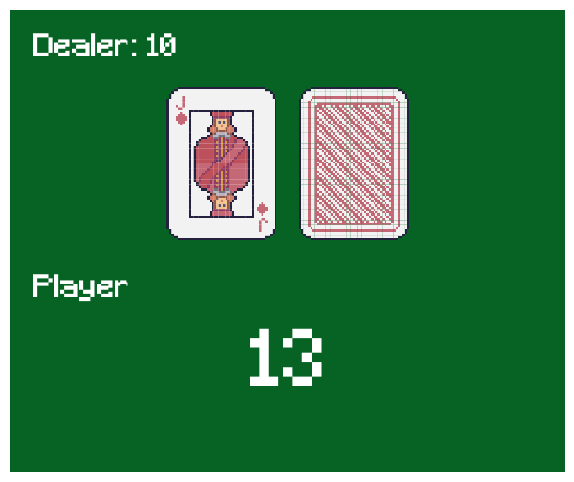

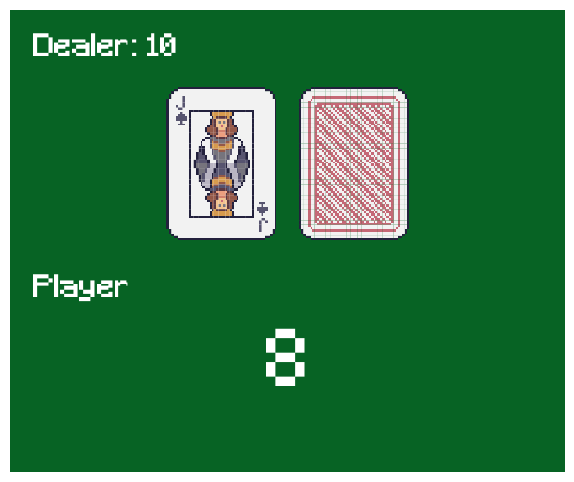

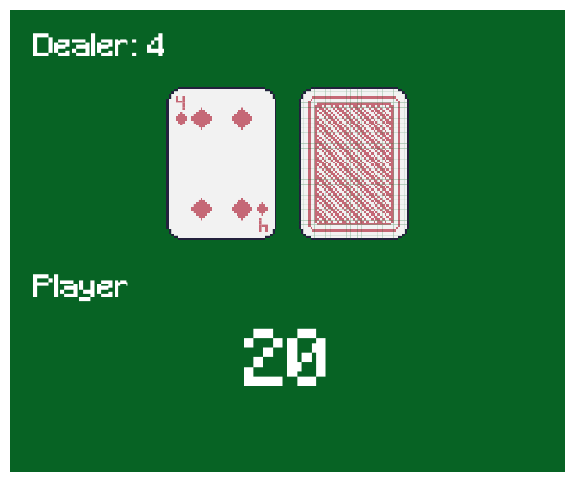

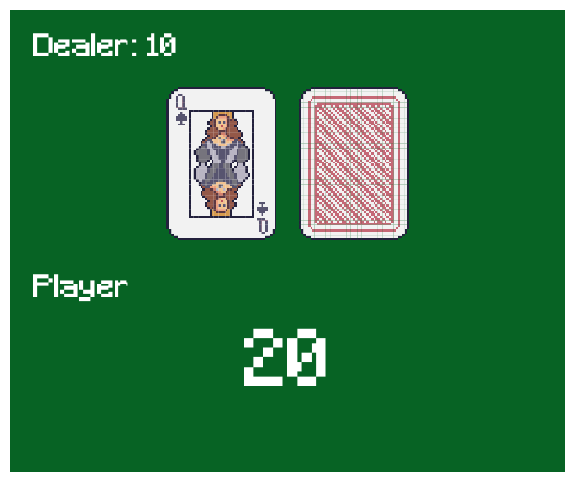

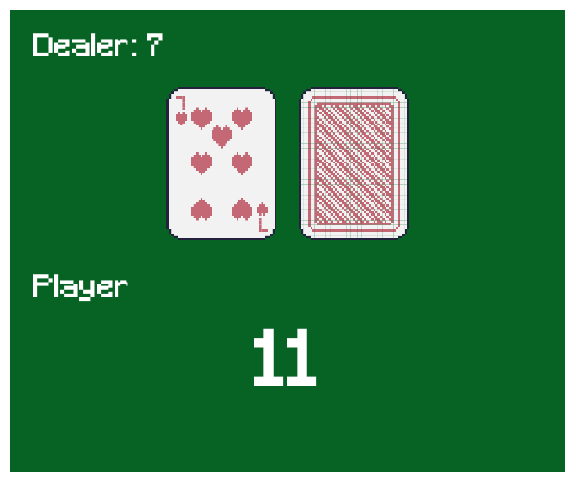

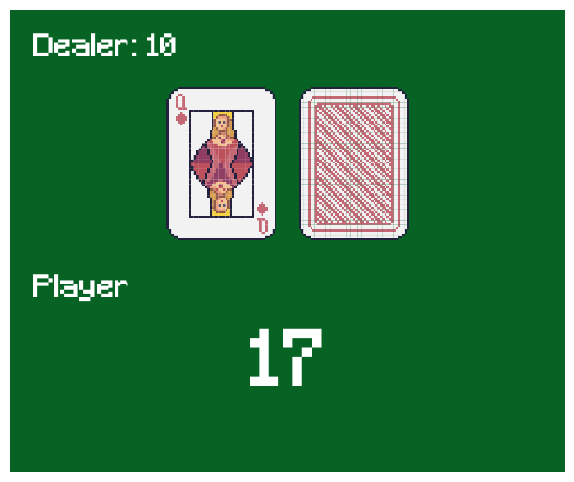

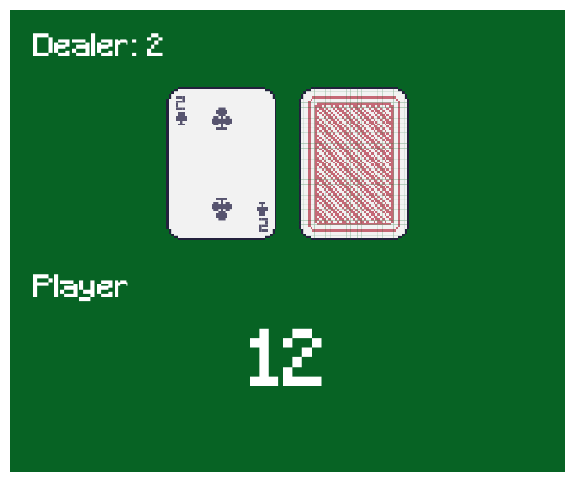

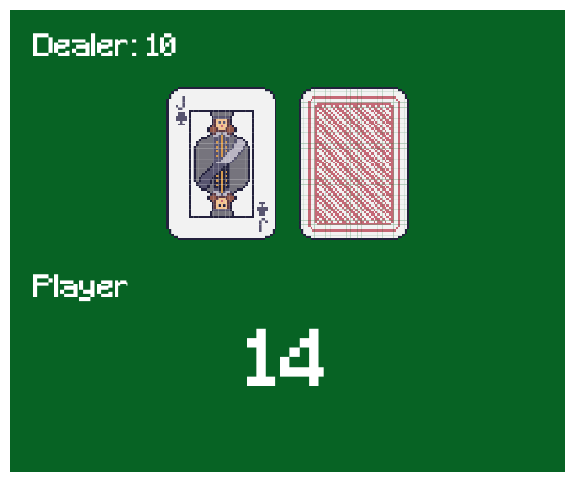

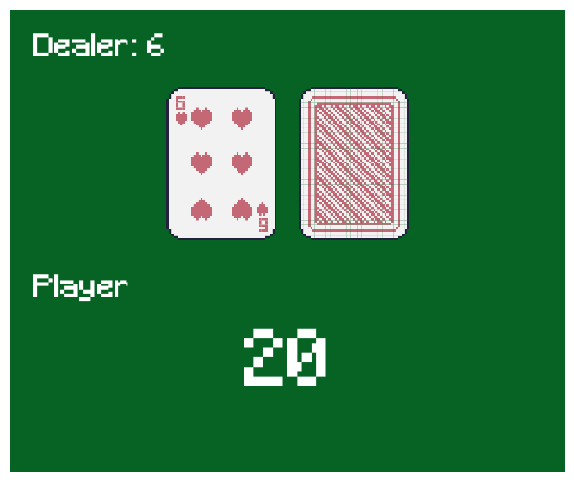

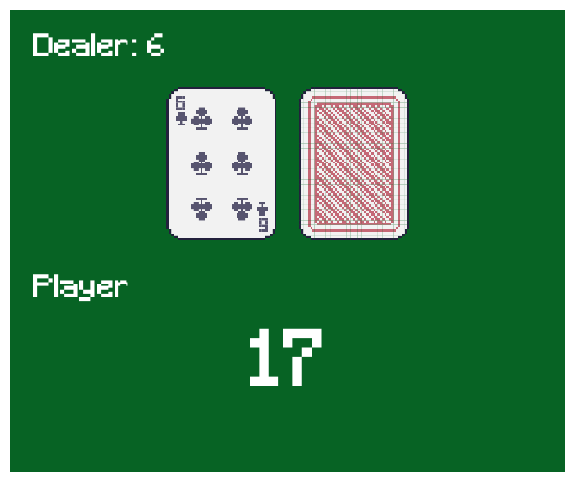

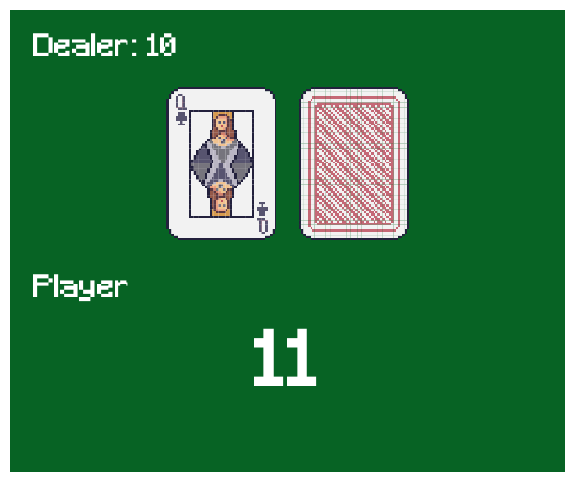

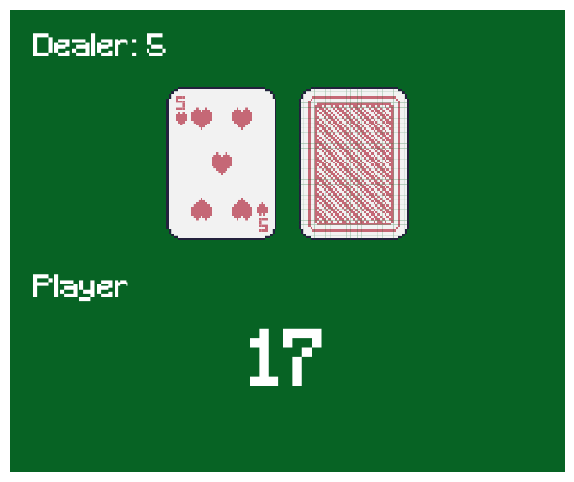

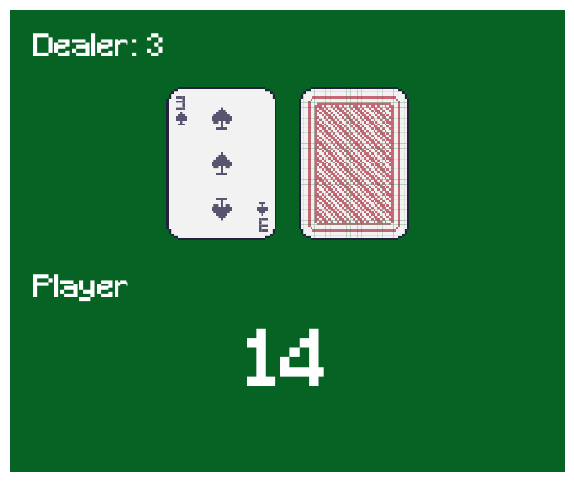

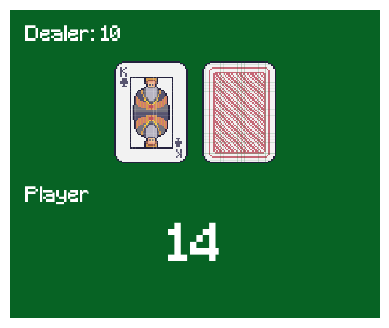

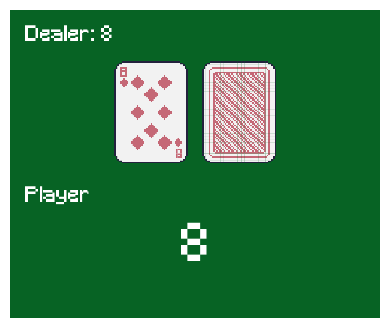

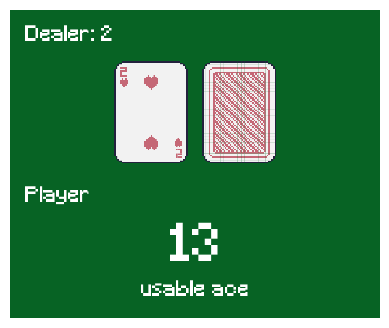

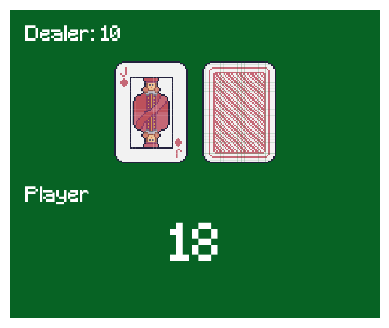

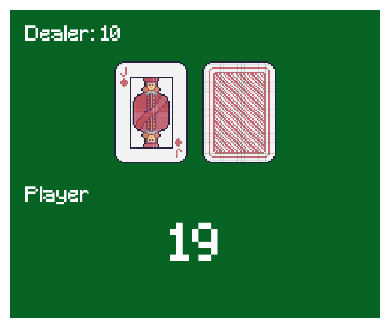

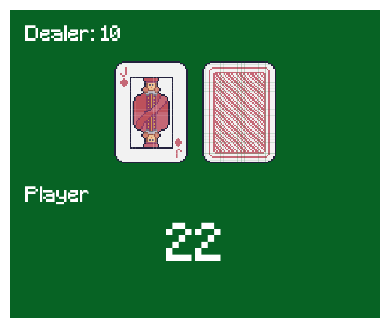

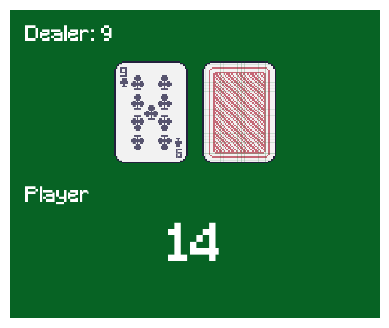

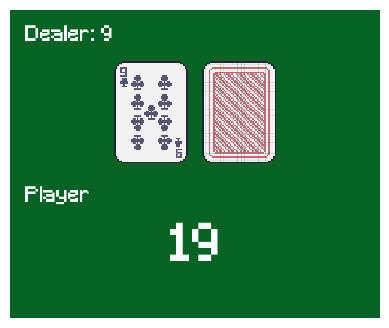

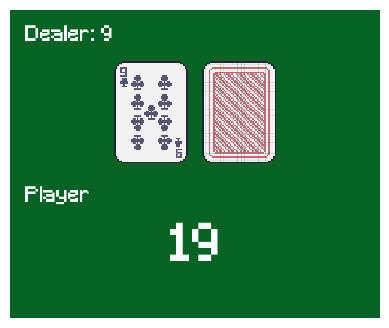

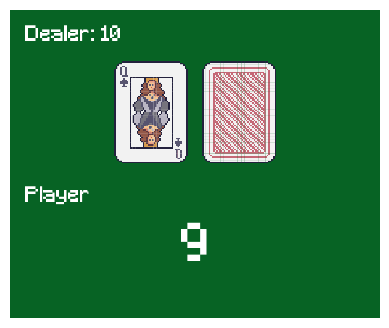

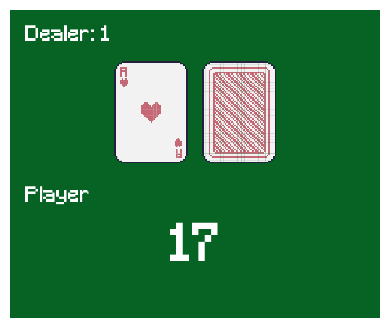

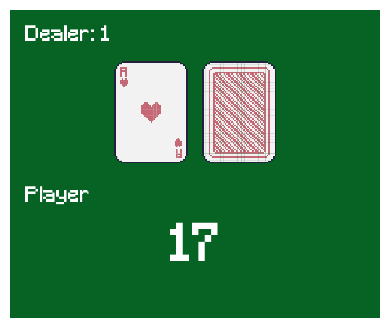

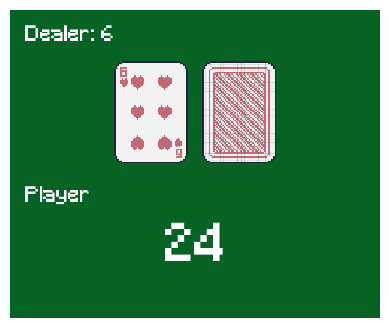

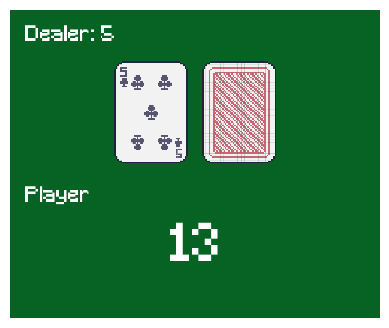

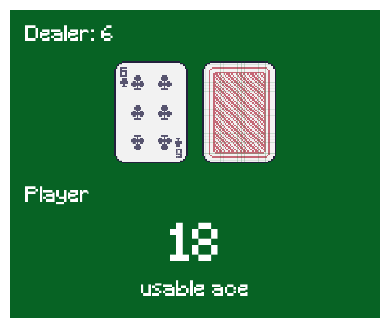

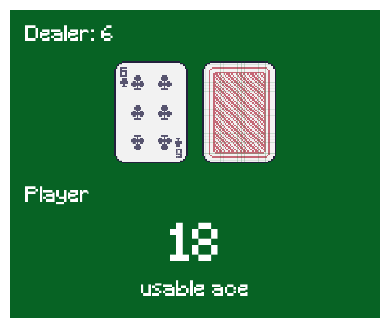

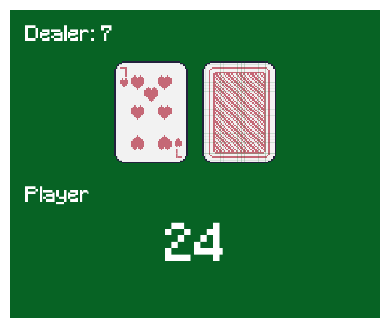

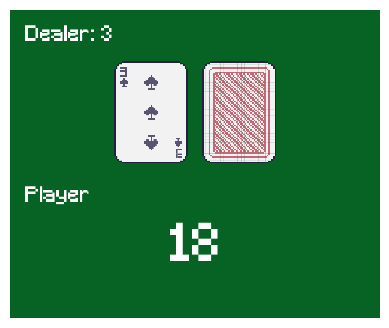

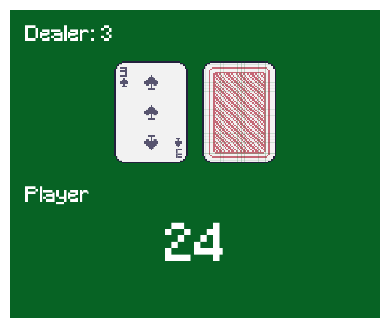

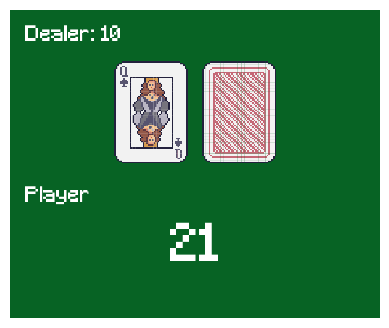

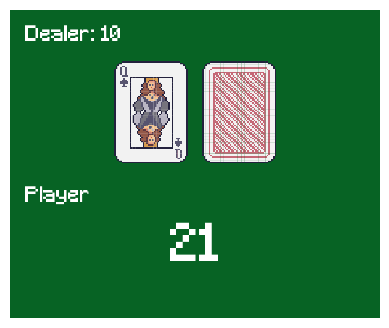

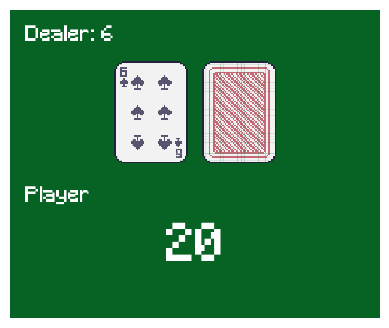

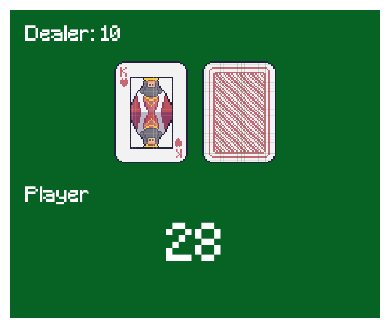

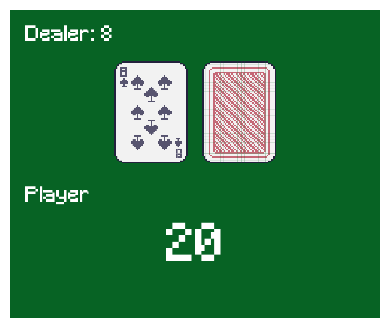

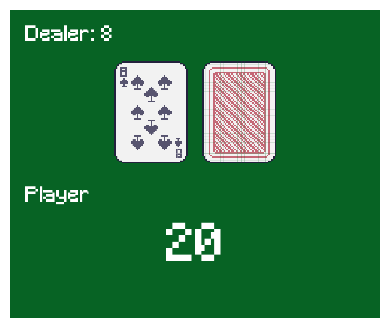

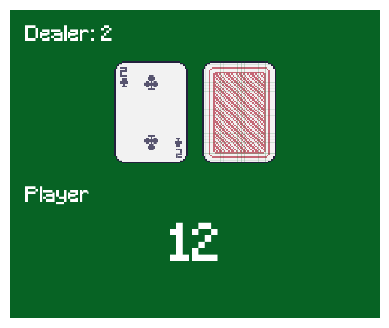

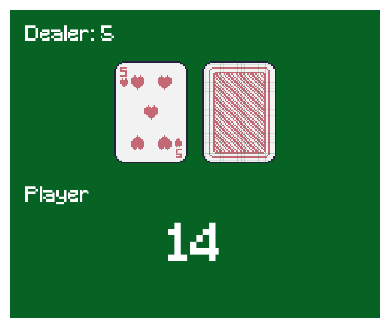

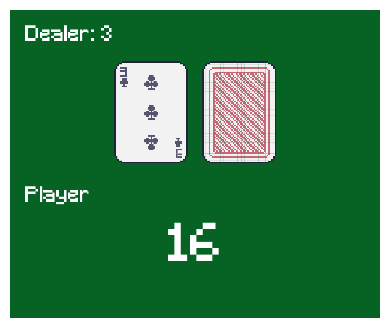

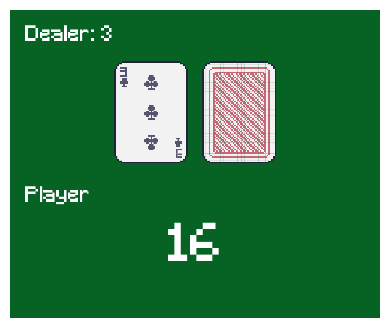

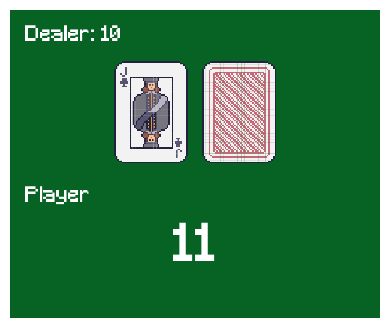

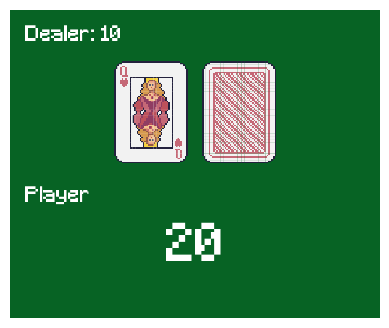

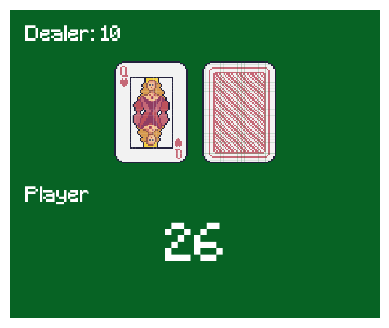

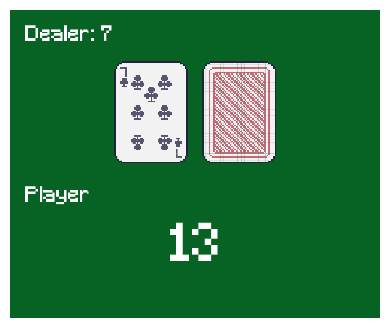

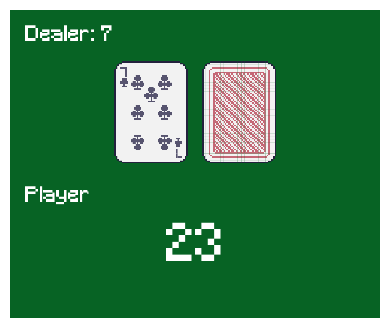

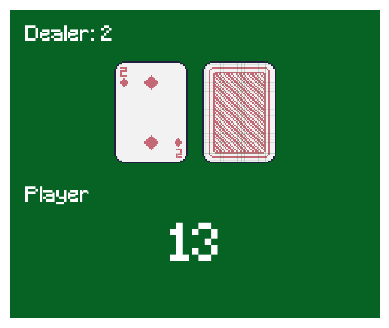

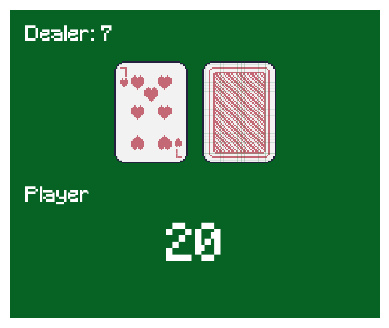

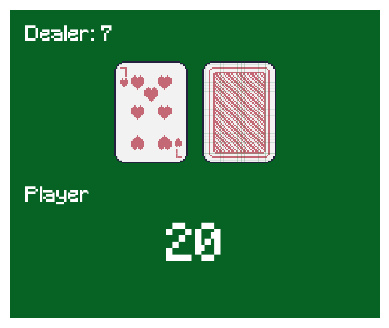

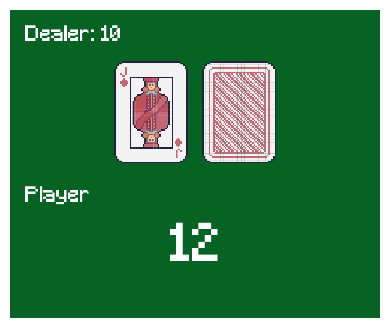

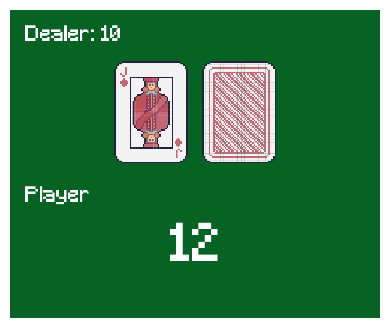

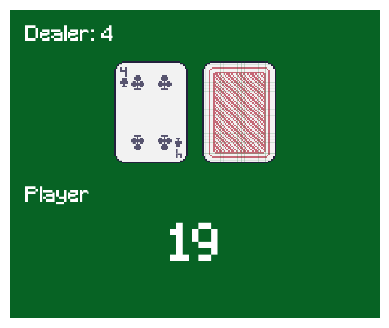

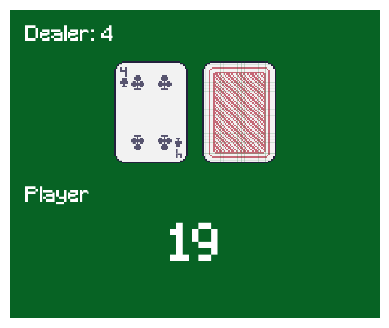

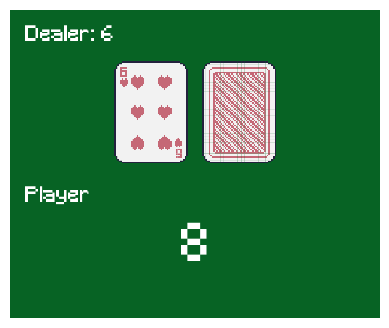

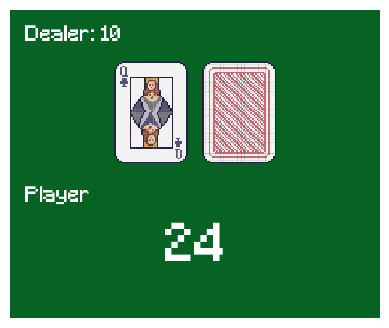

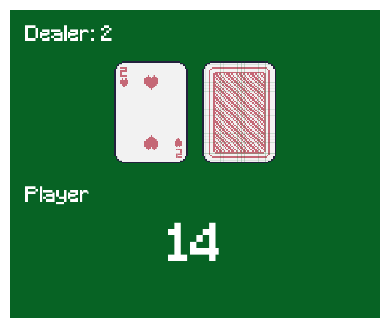

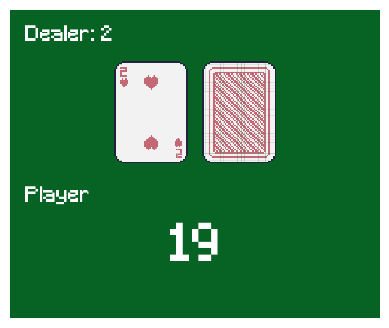

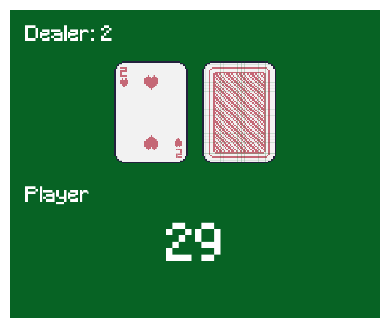

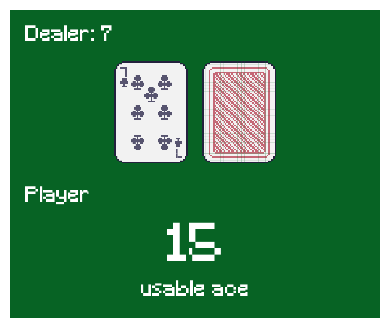

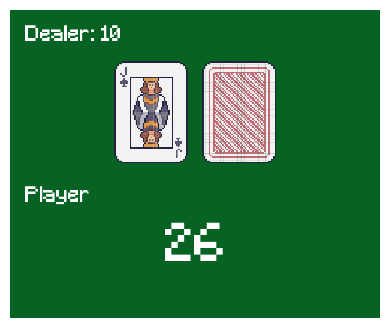

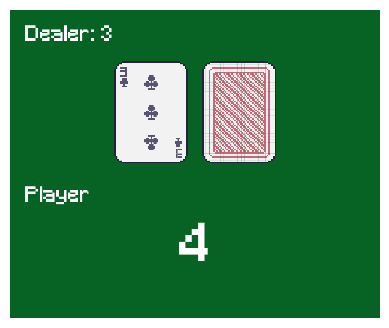

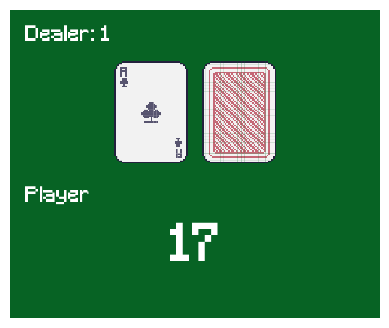

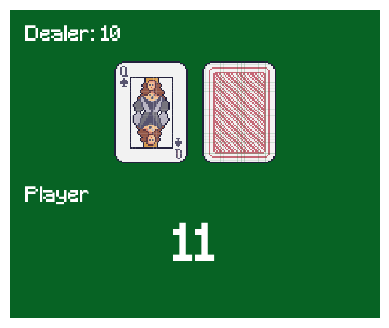

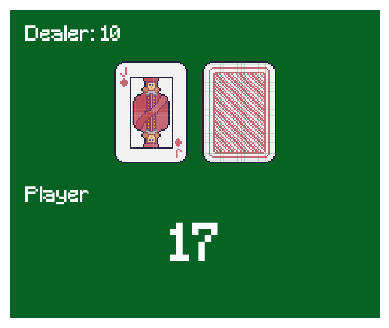

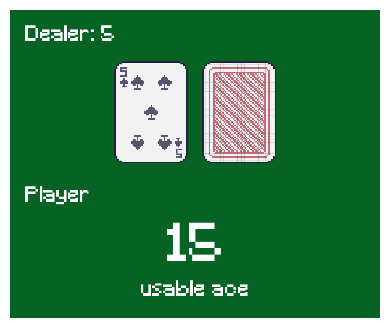

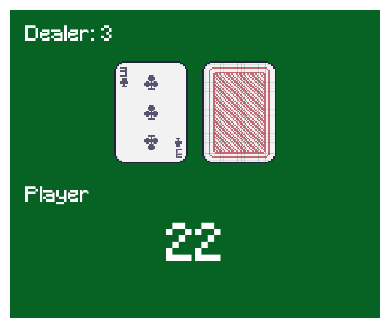

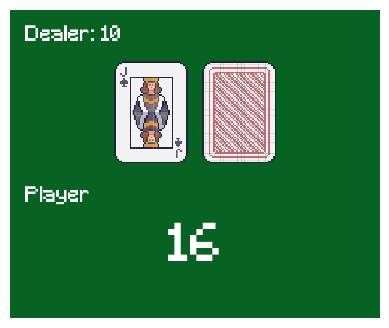

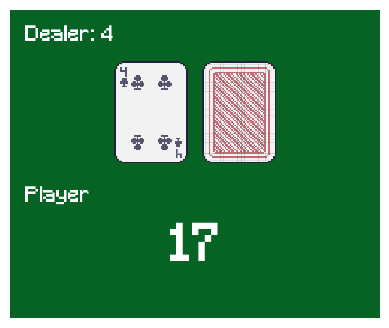

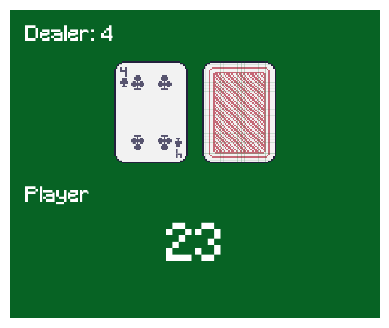

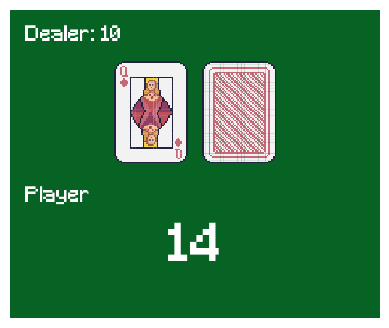

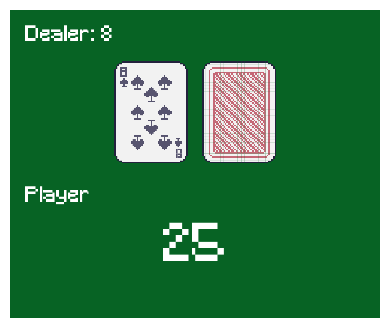

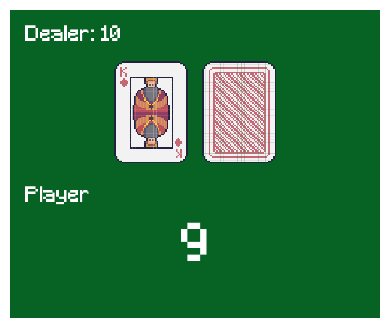

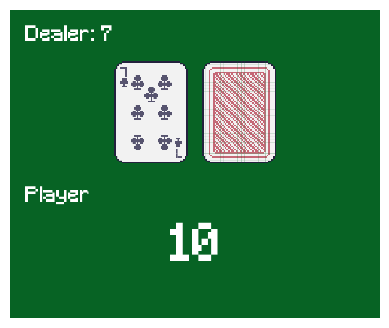

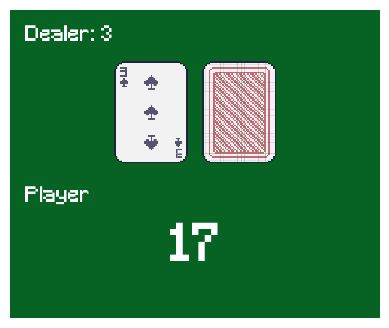

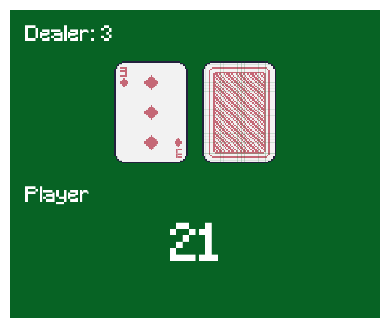

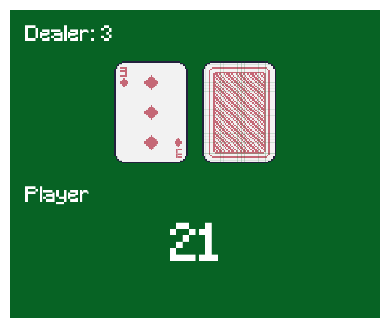

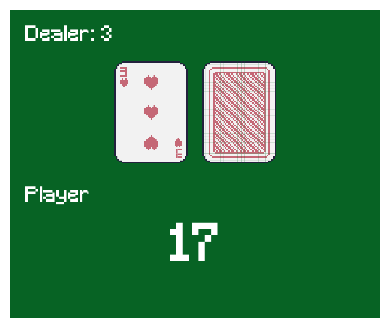

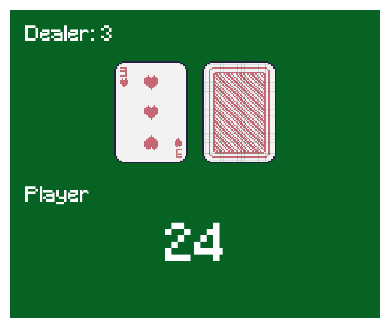

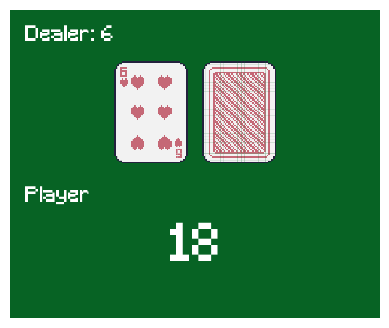

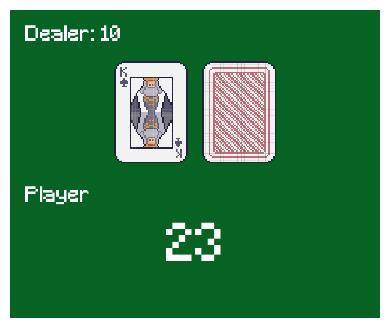

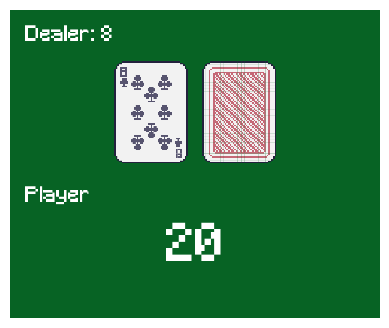

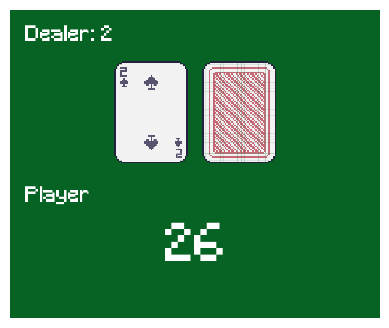

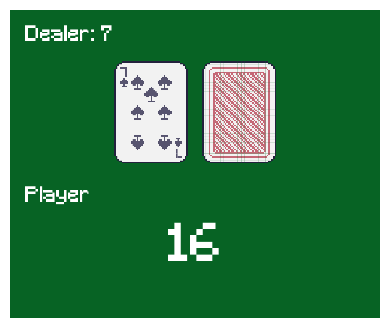

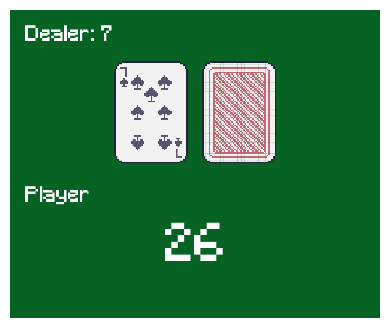

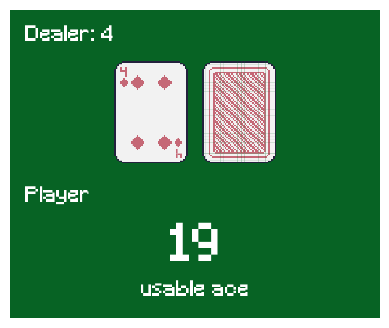

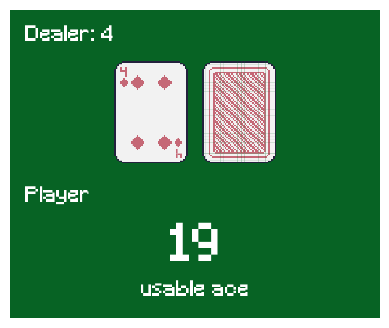

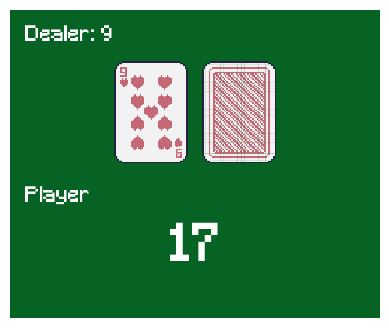

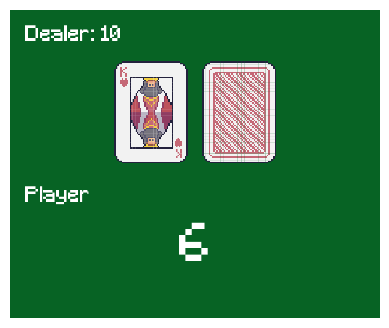

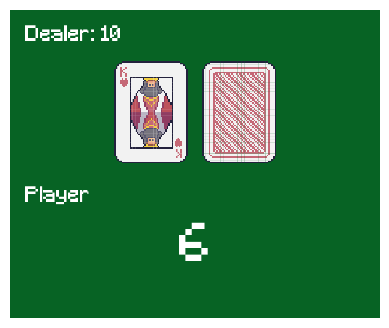

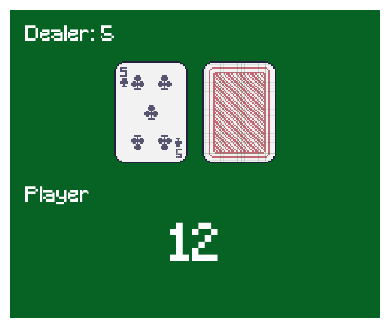

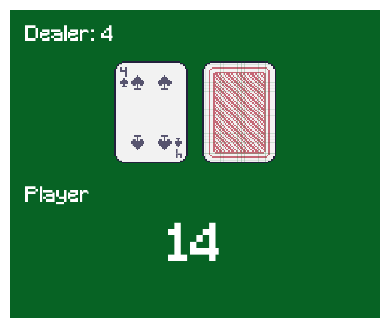

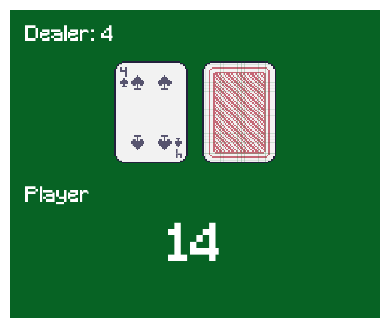

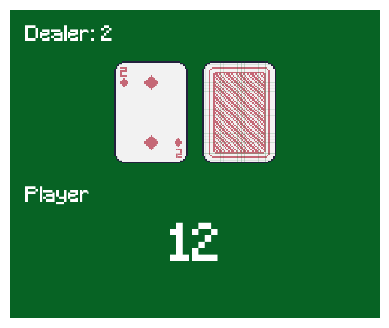

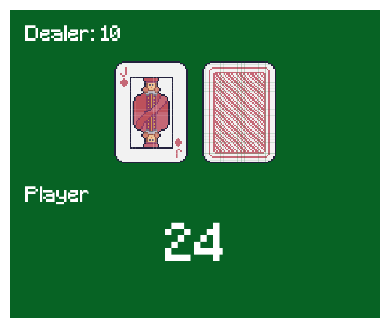

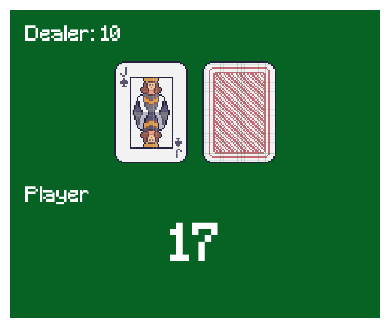

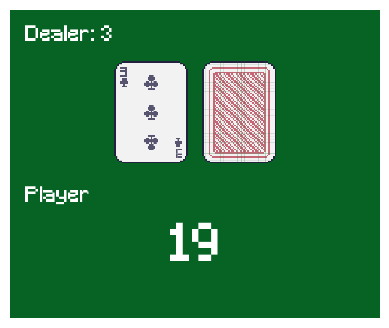

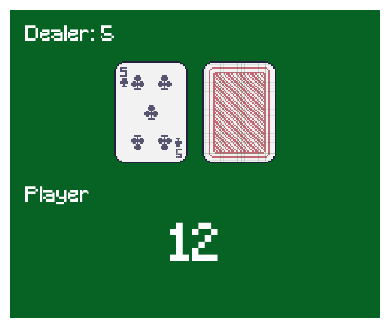

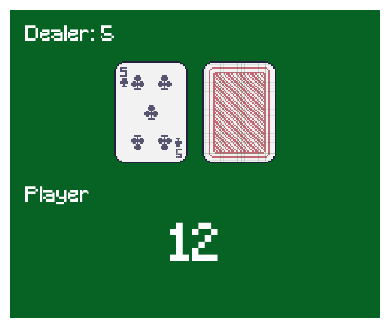

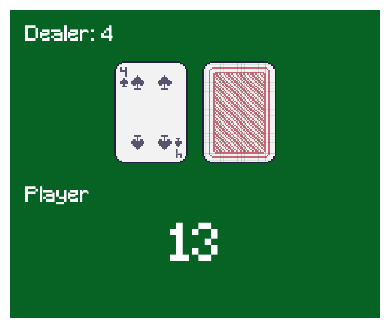

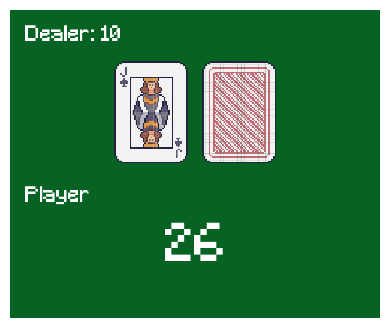

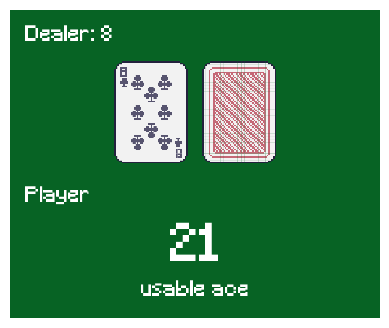

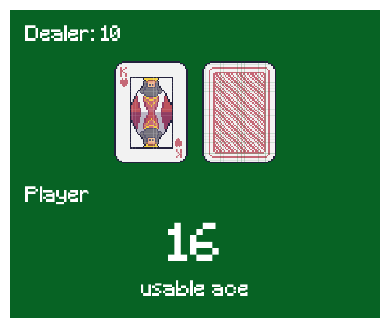

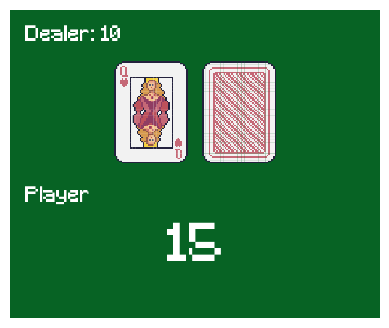

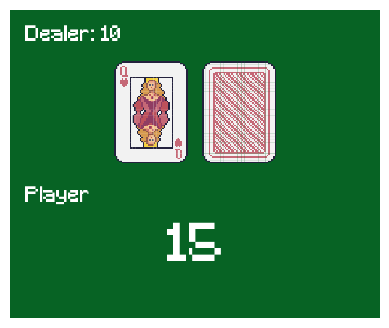

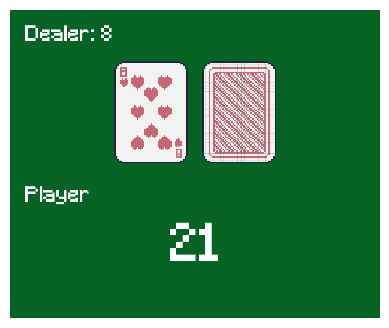

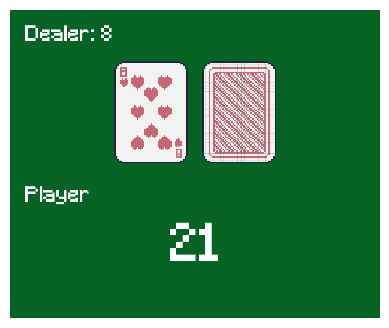

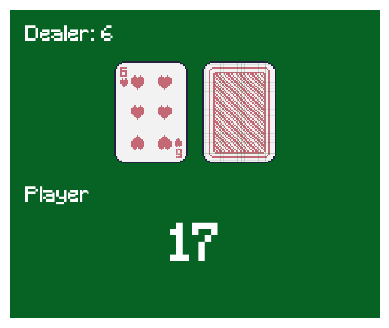

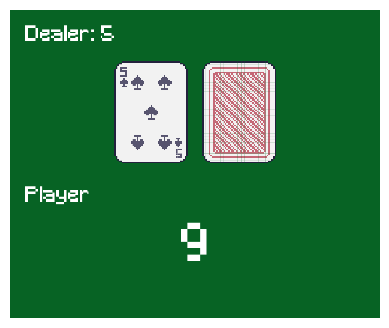

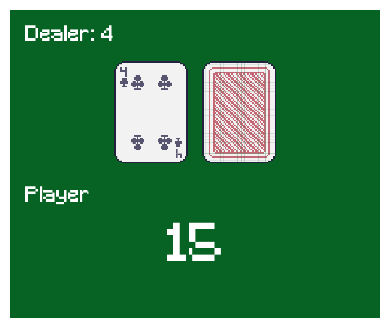

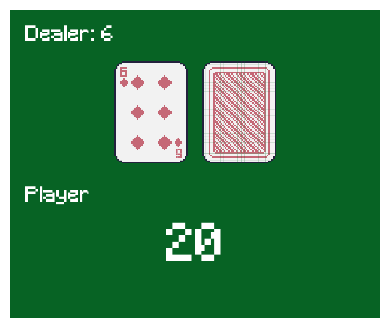

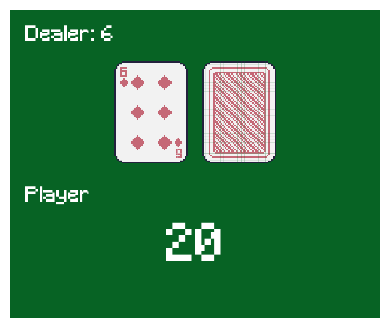

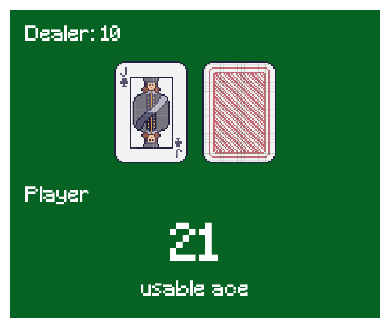

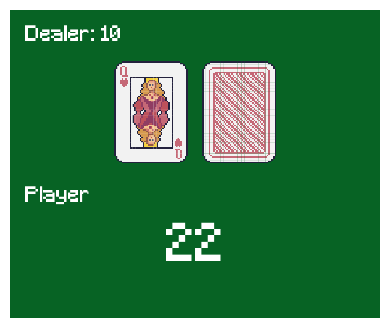

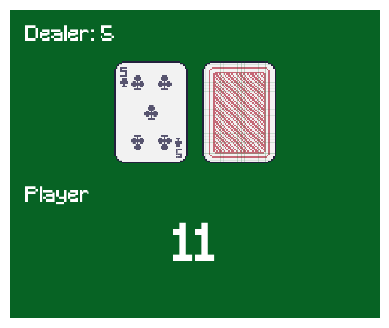

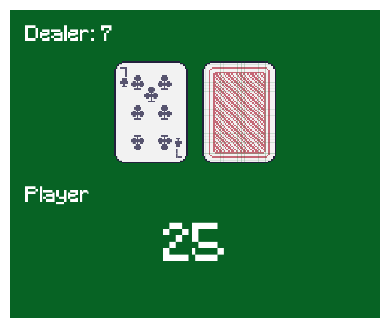

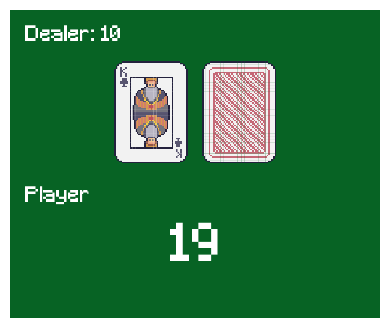

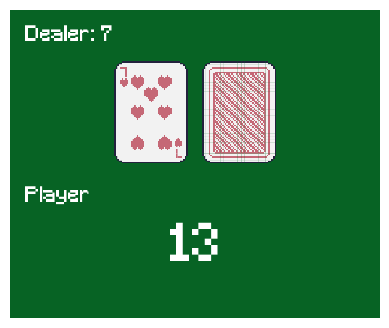

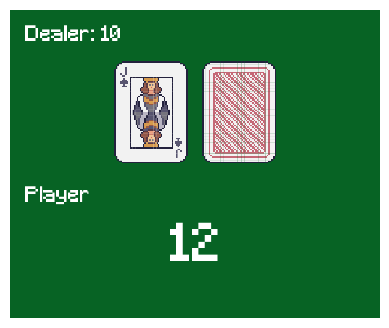

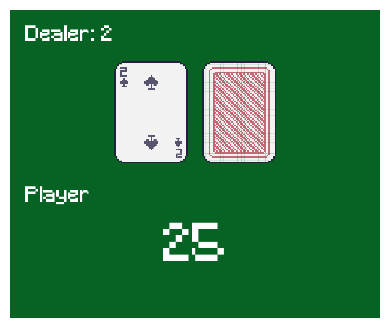

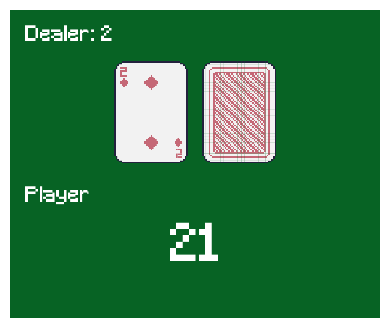

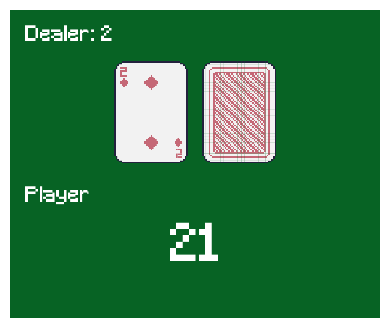

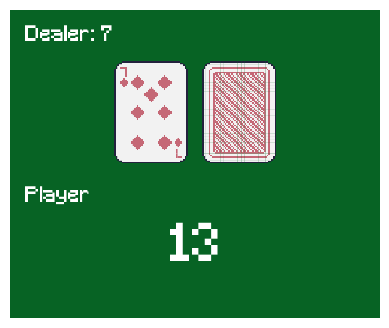

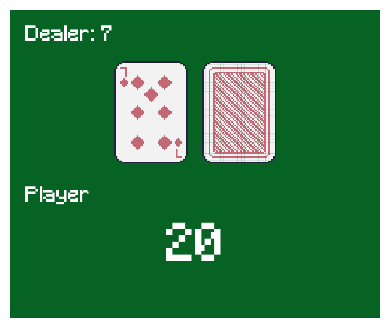

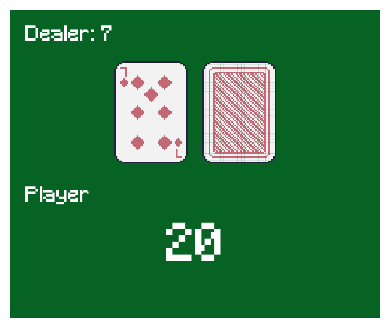

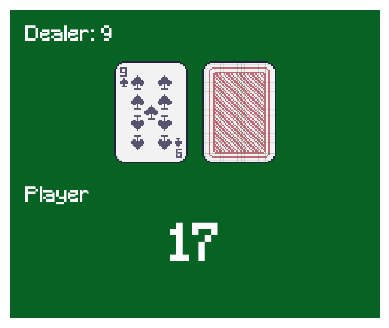

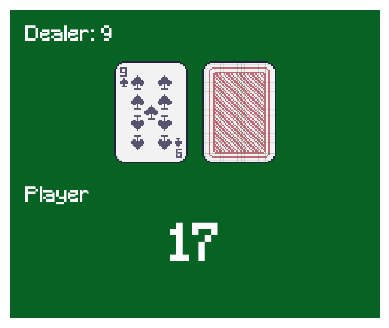

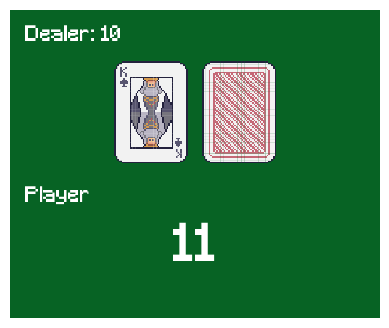

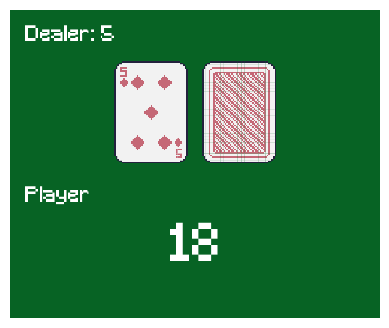

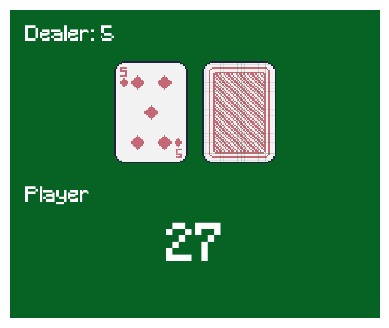

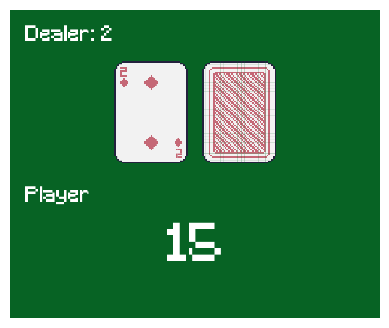

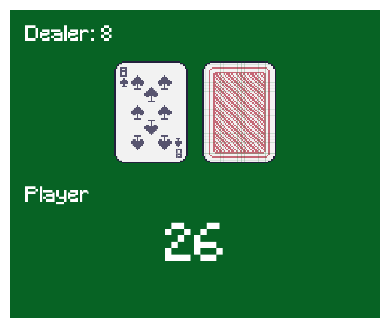

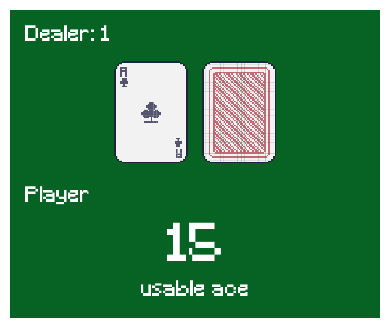

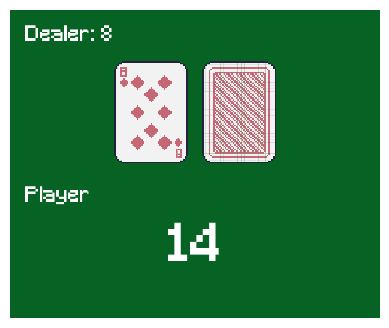

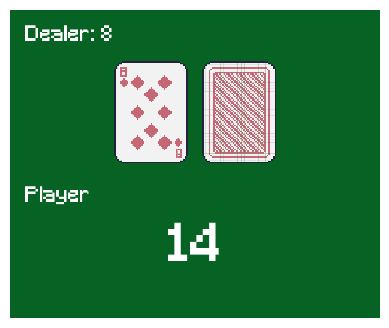

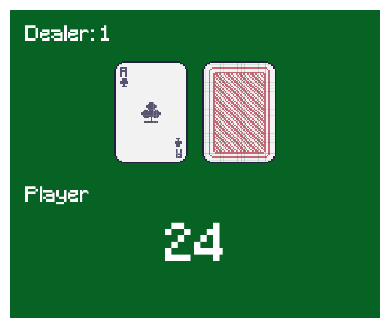

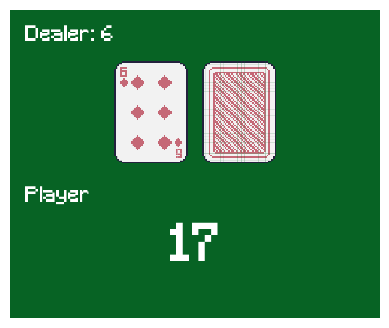

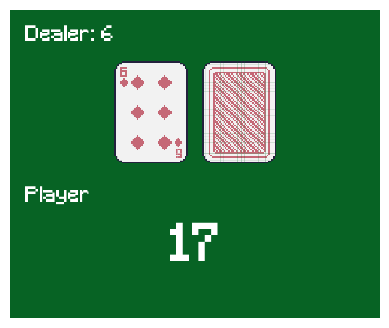

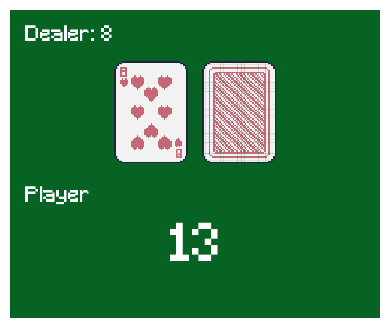

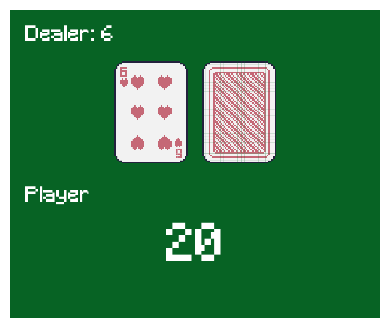

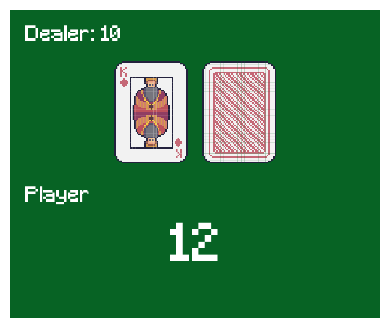

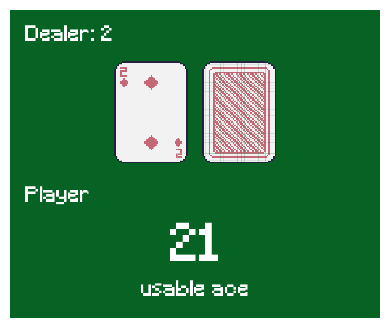

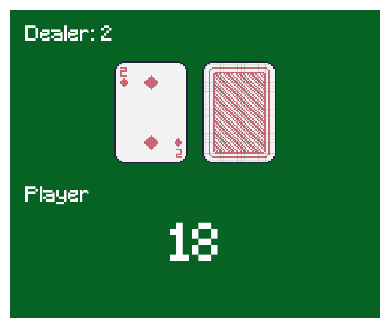

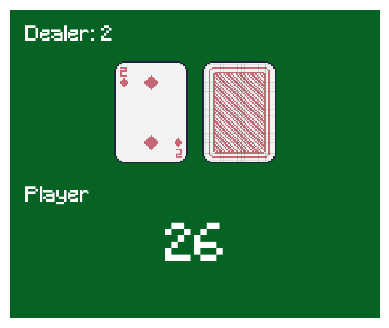

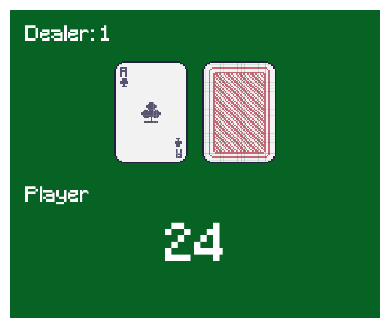

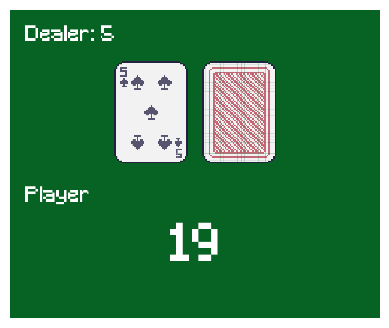

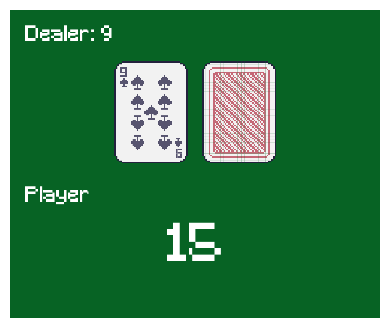

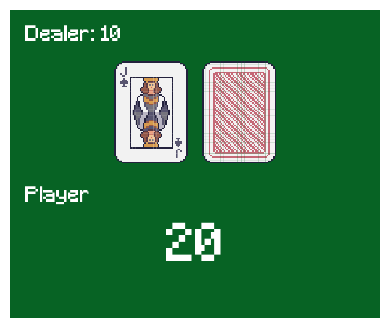

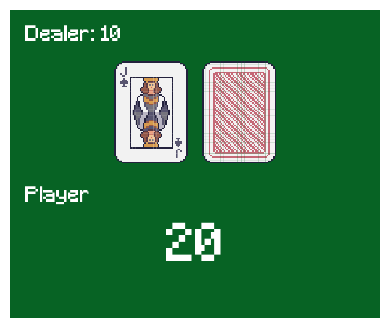

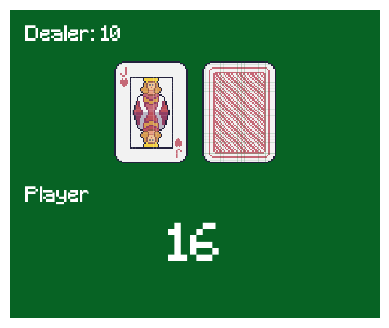

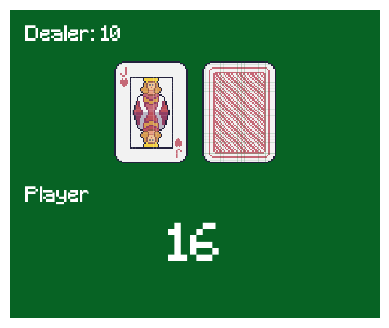

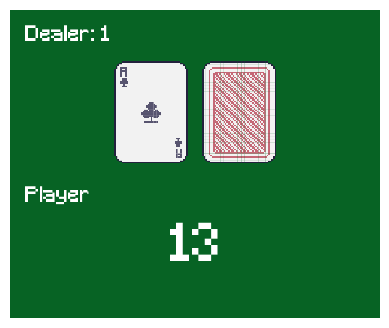

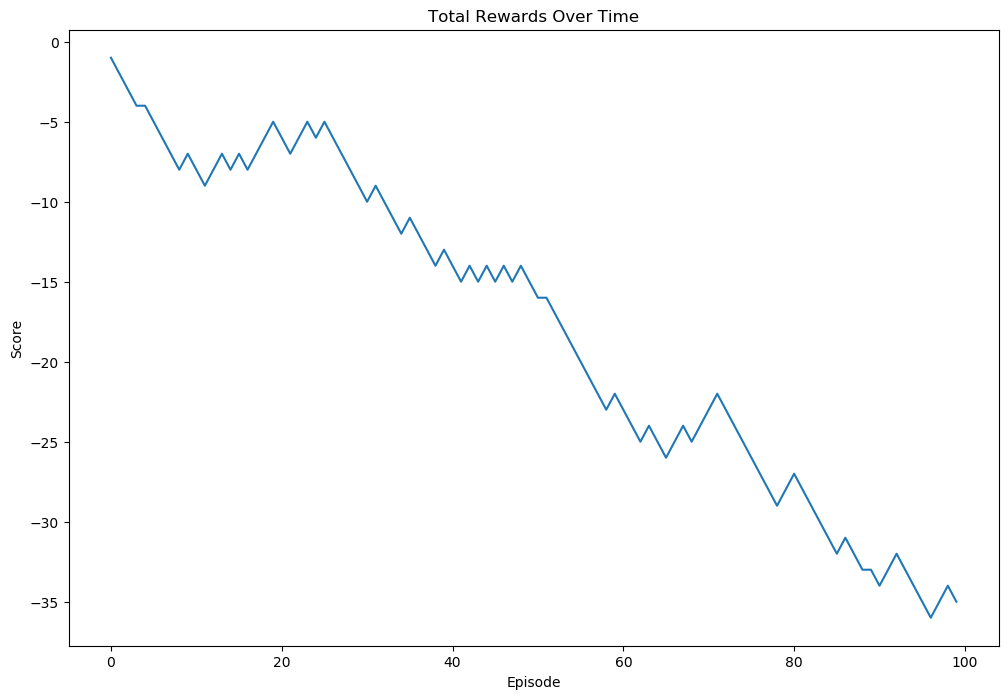

In [167]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(rewards))
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title("Total Rewards Over Time")
plt.show()

## Test without exploration

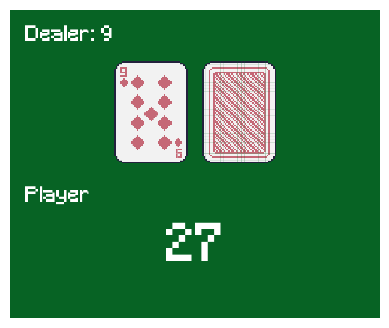

In [168]:
# Watch trained agent
env = gym.make("Blackjack-v1", render_mode='rgb_array')    # Added render mode for compatibility
#env.action_space.seed(42)
rewards = watch_trained_agent_no_exploration(env, qtable, num_rounds=100)
env.close()

## Output reward over hands played

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


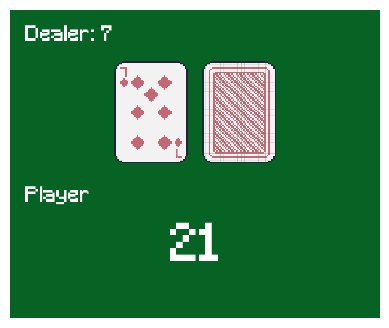

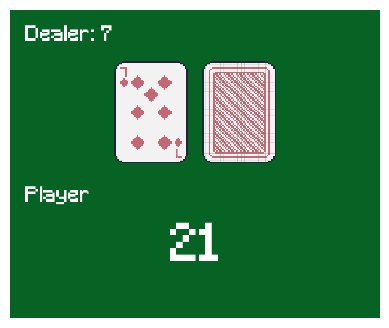

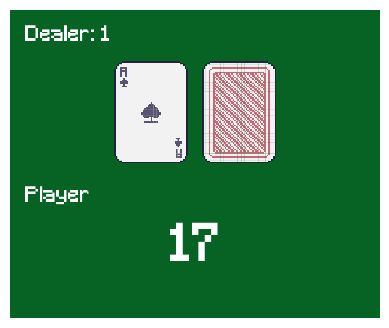

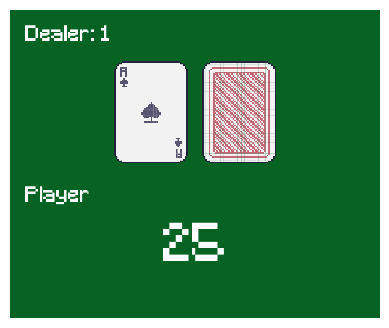

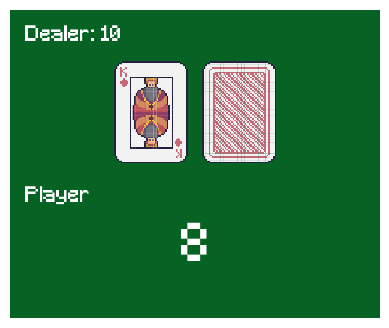

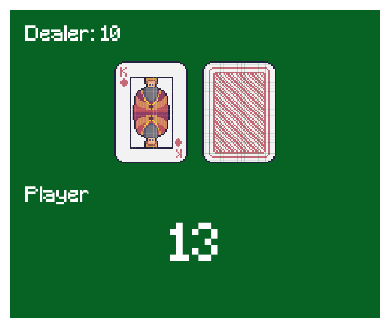

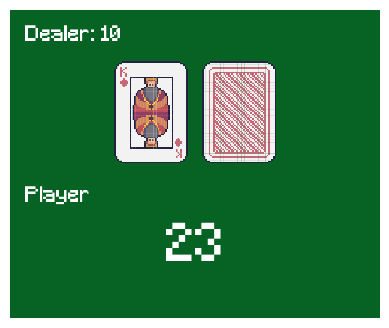

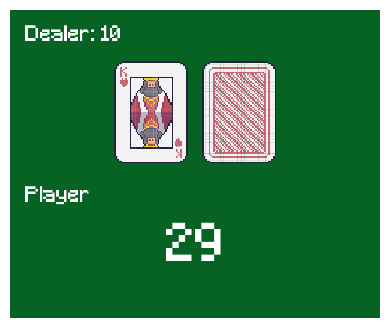

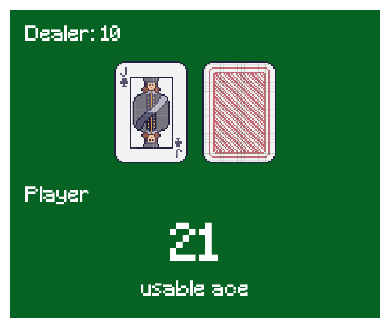

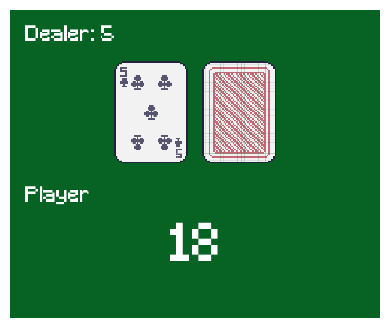

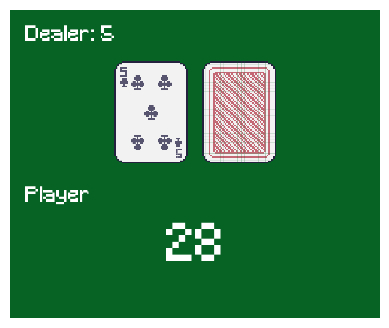

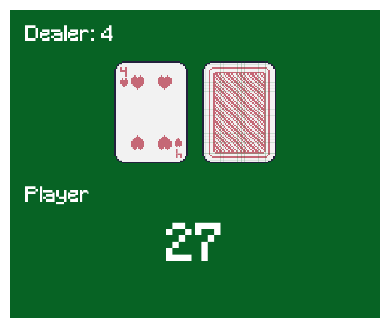

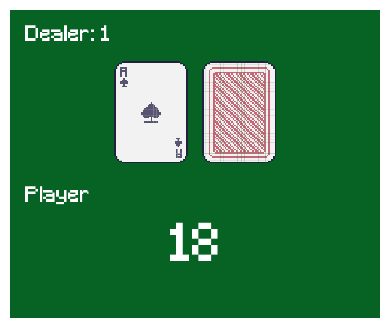

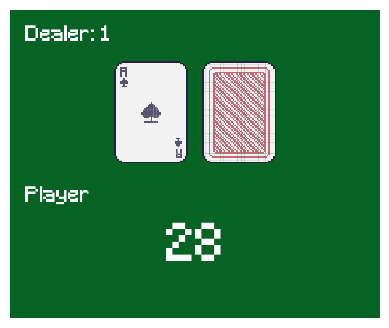

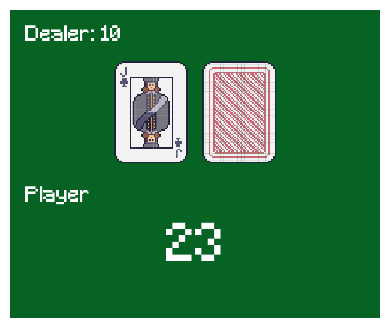

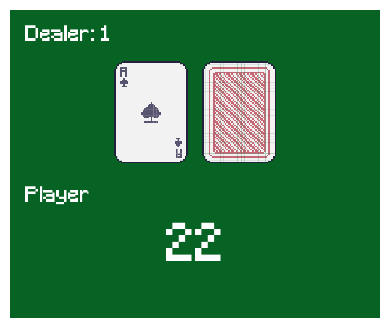

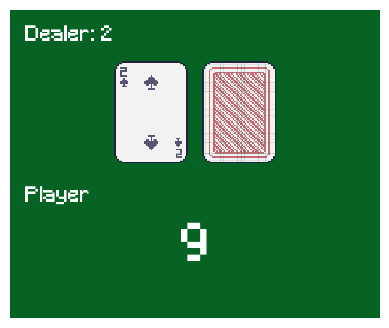

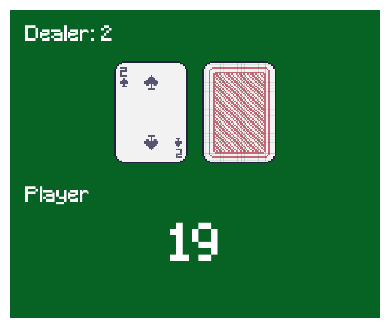

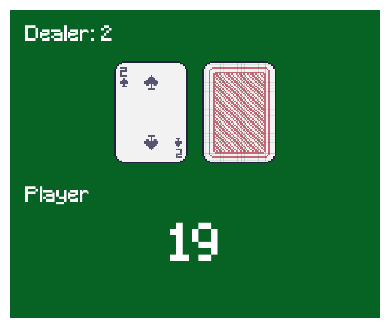

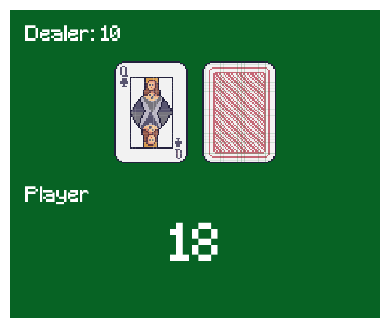

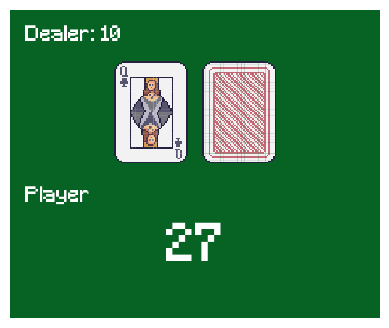

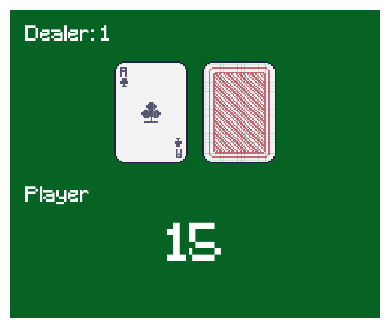

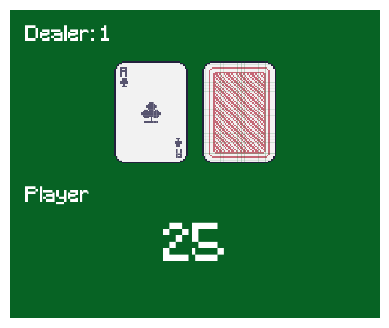

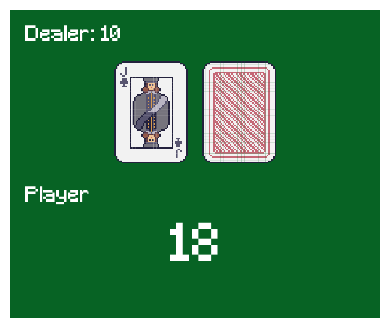

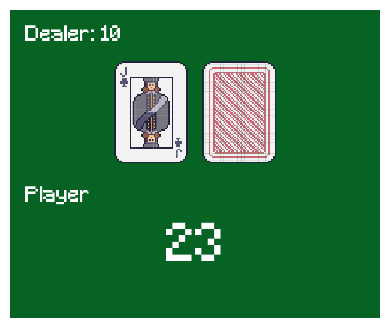

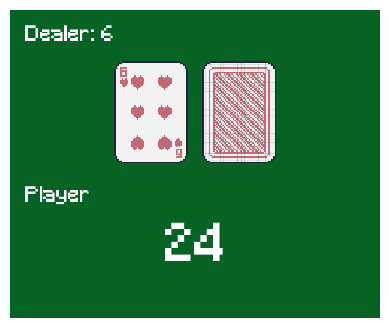

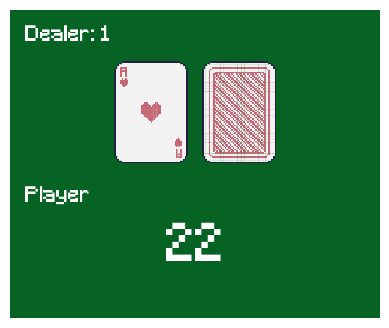

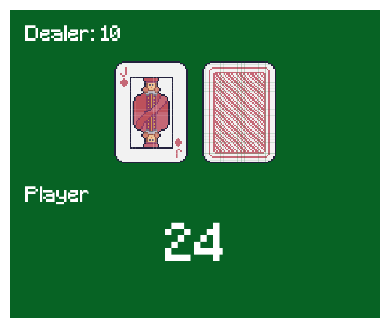

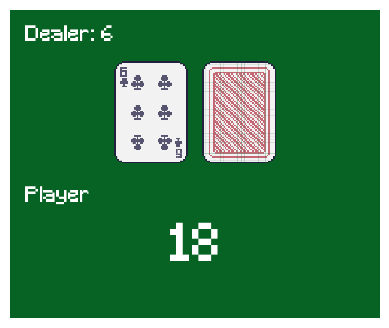

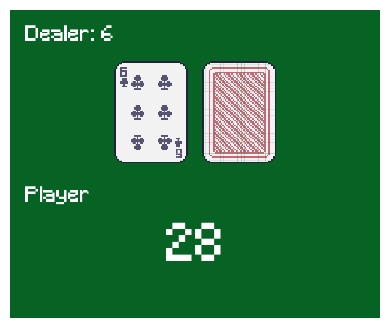

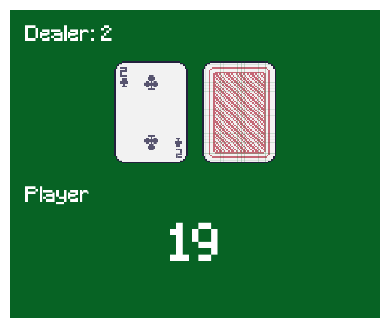

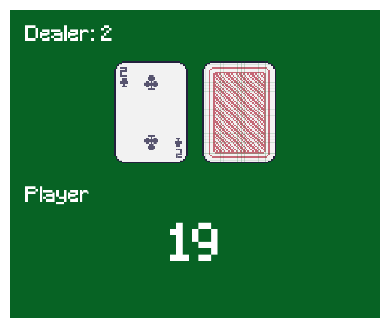

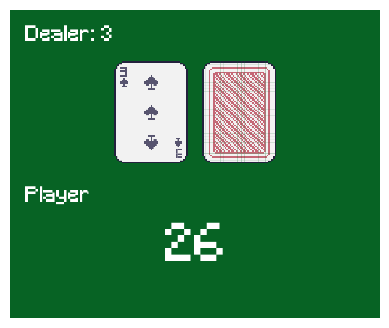

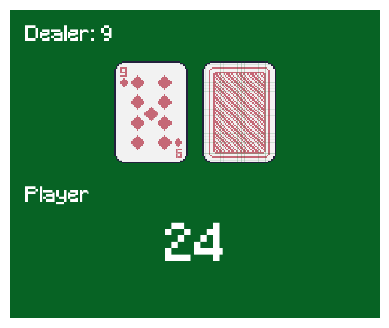

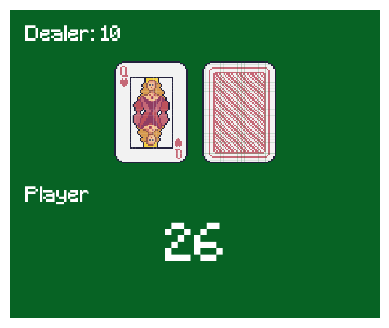

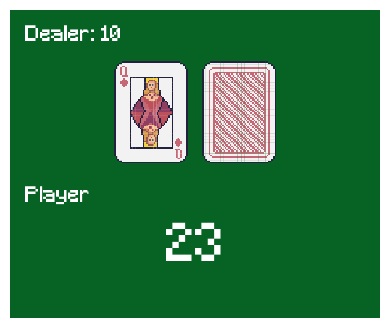

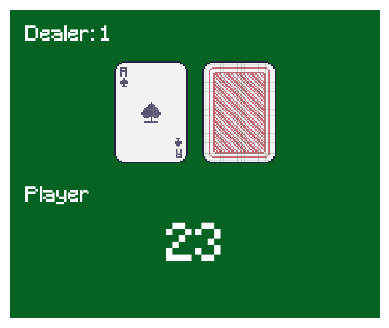

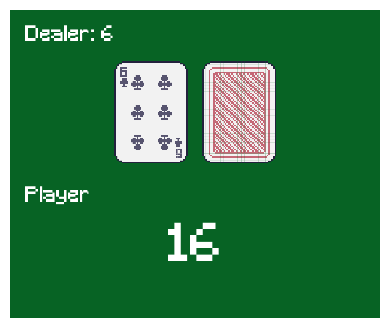

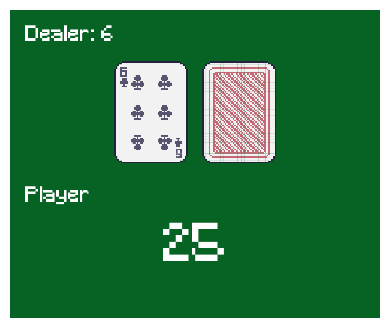

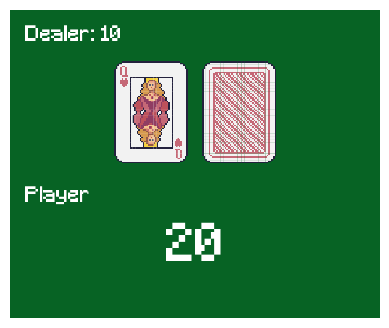

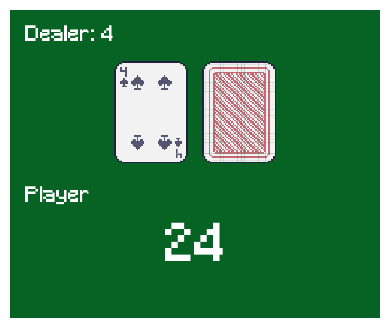

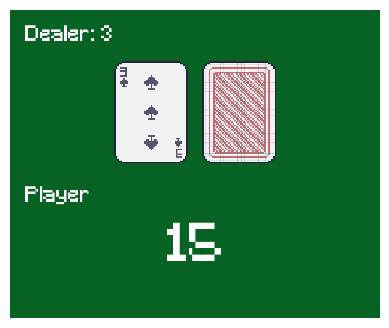

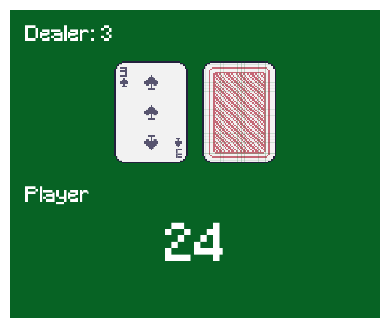

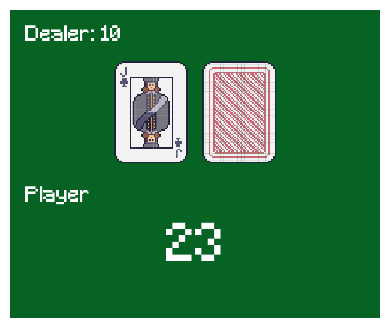

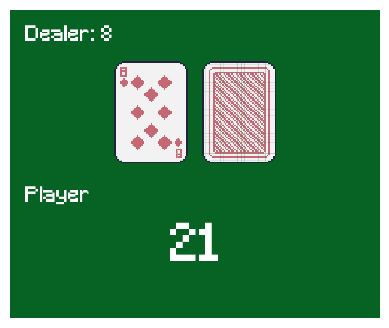

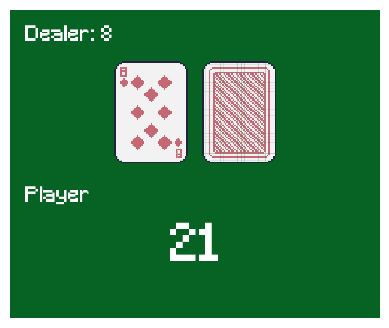

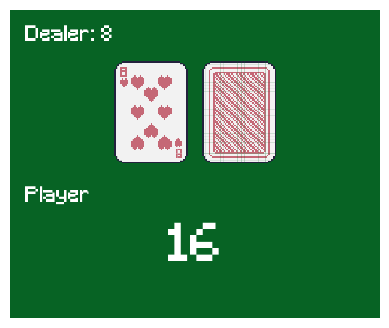

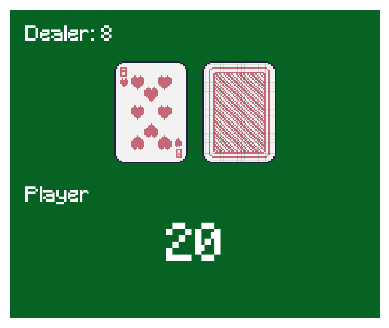

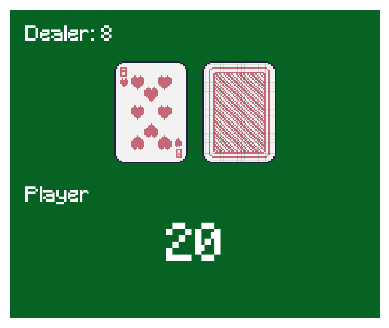

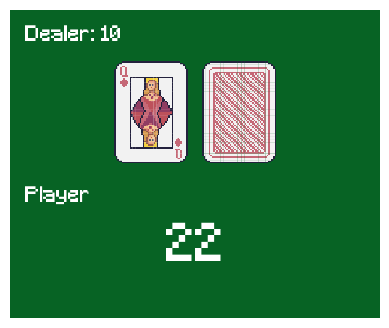

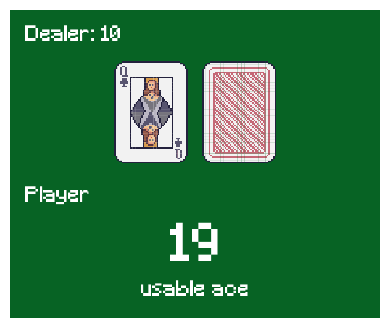

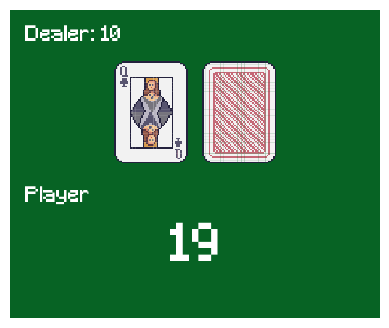

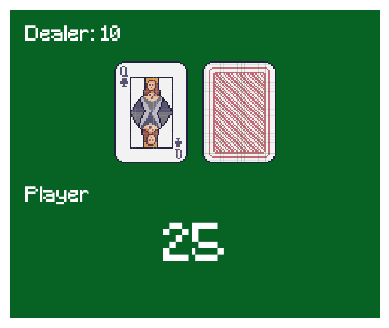

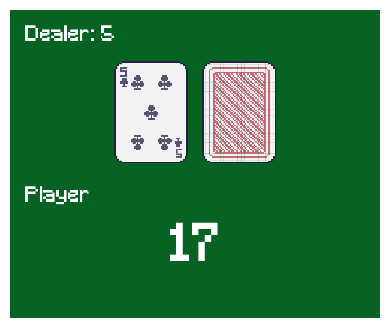

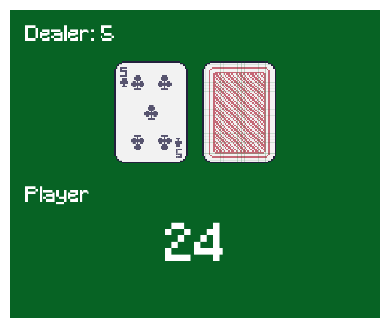

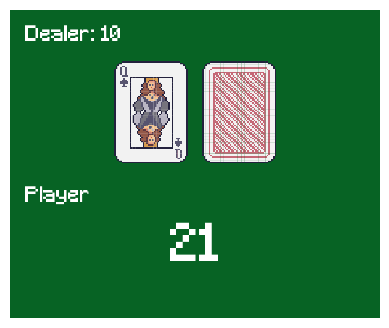

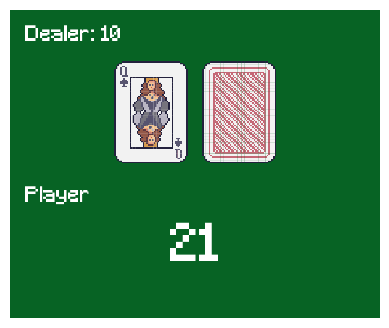

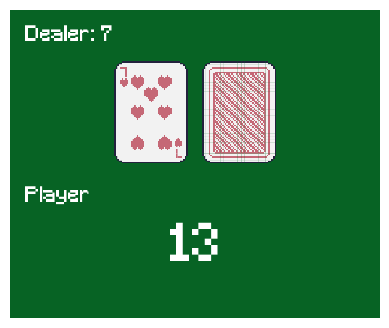

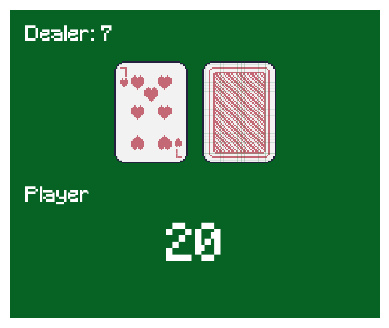

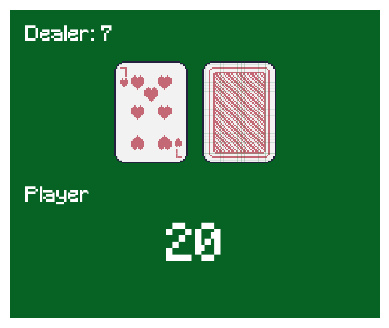

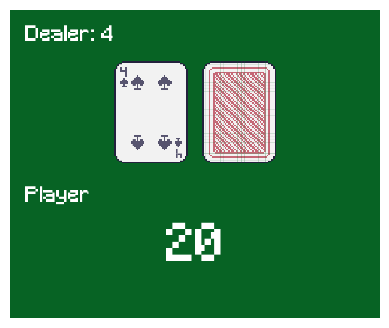

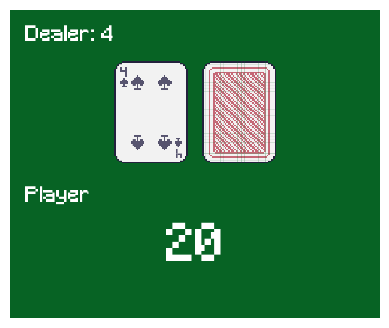

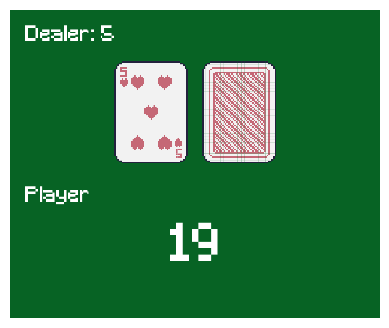

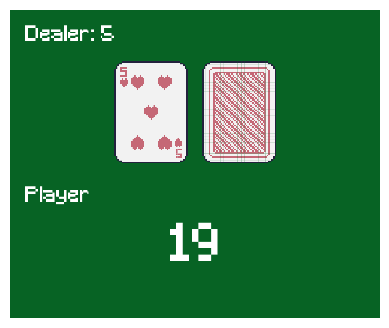

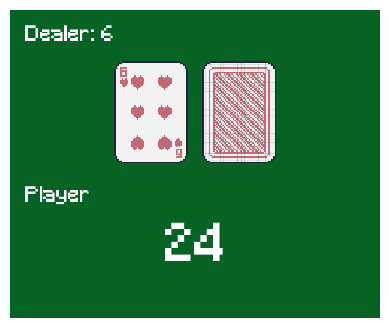

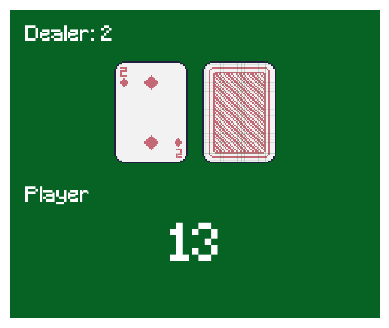

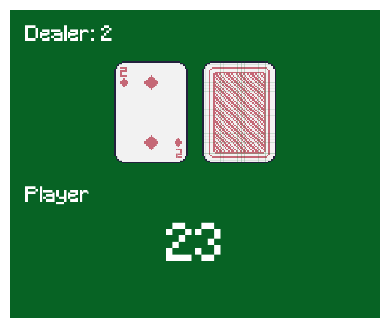

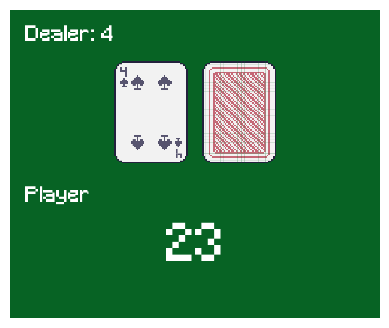

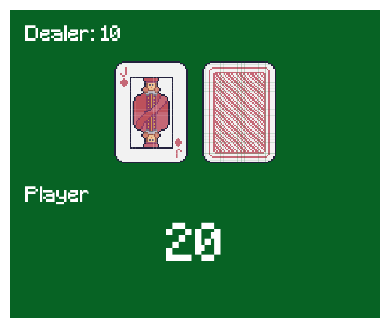

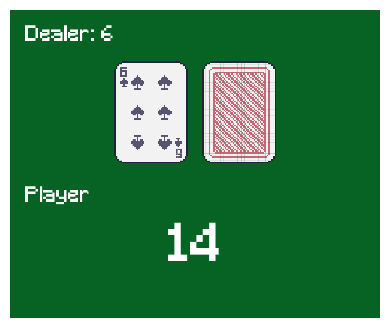

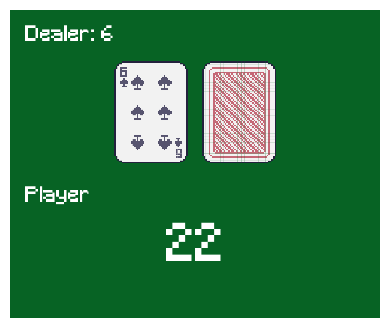

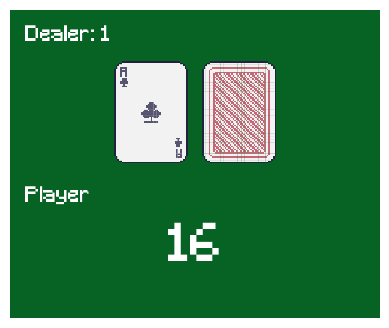

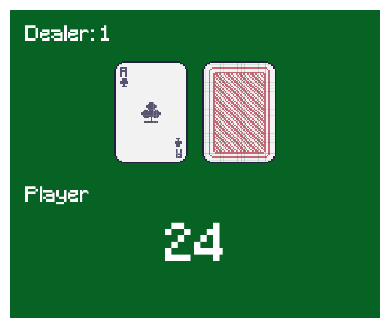

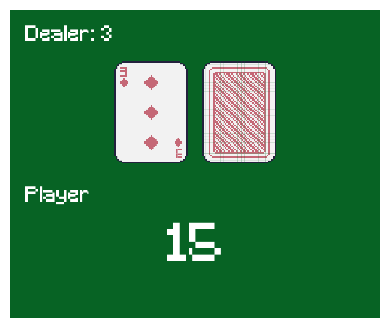

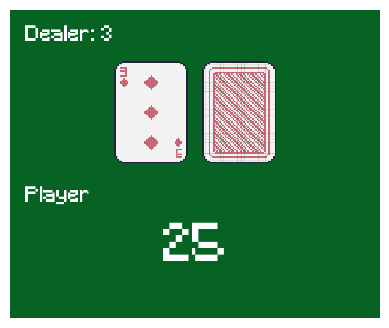

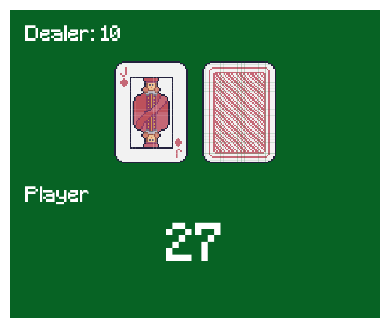

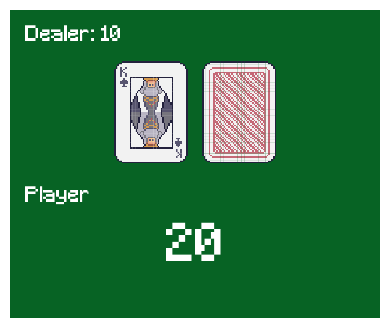

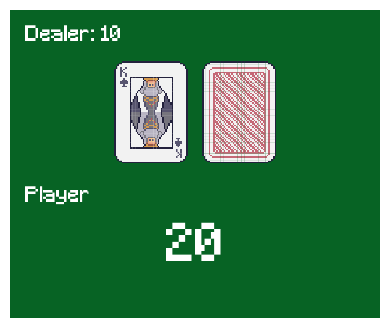

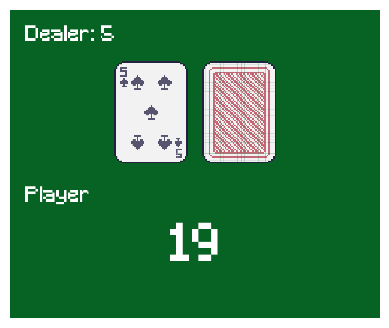

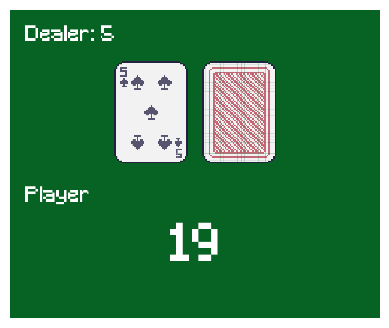

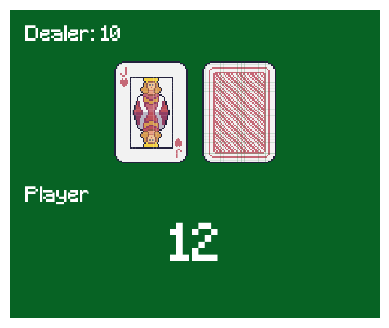

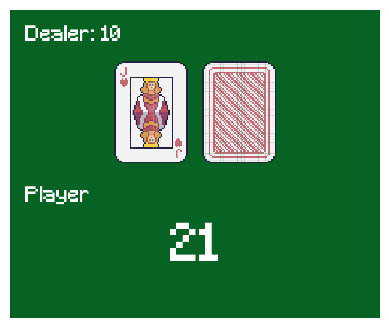

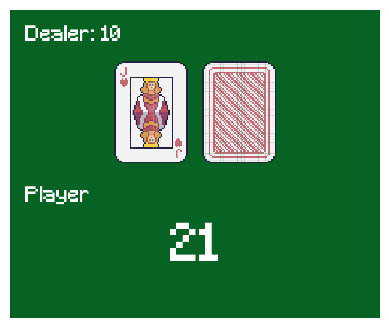

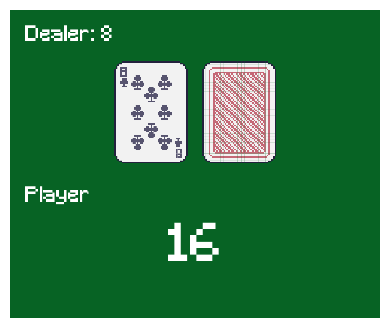

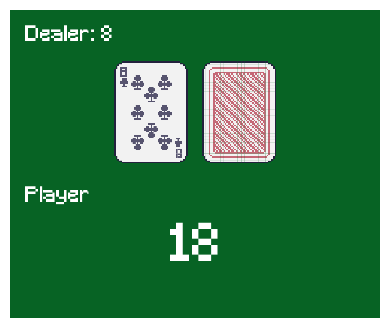

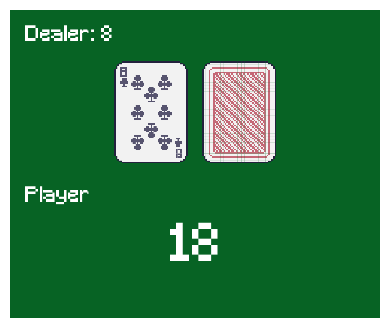

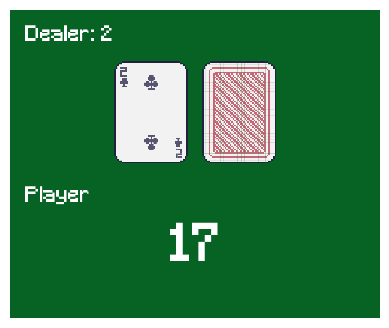

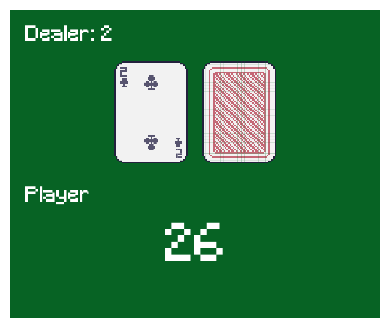

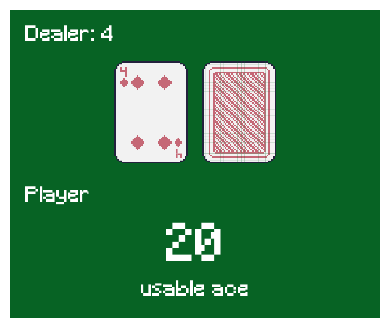

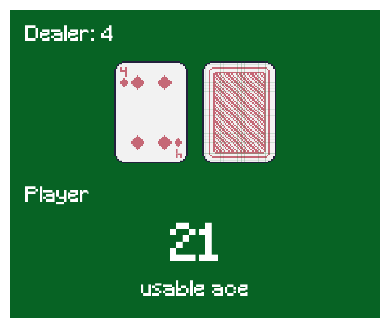

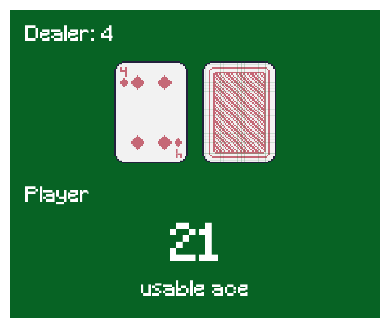

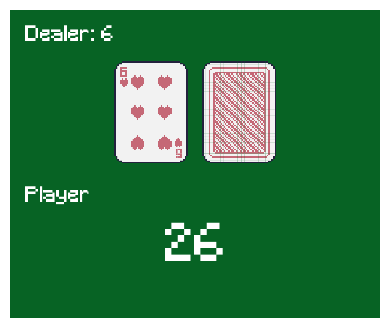

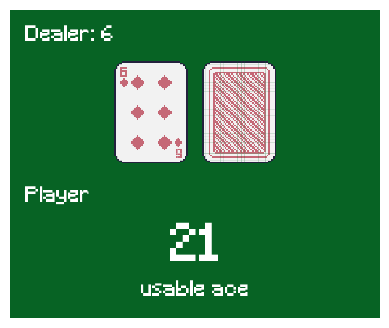

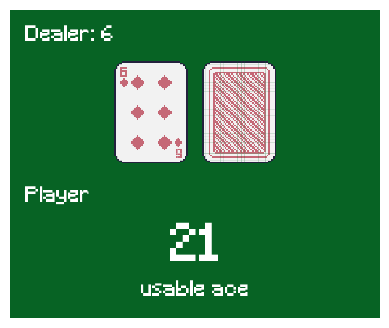

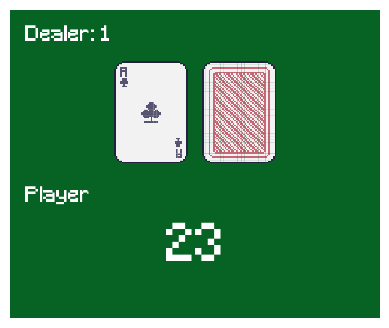

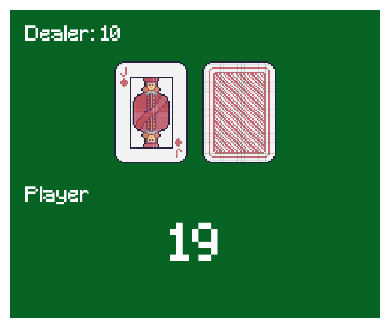

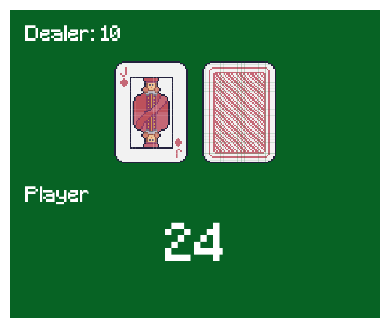

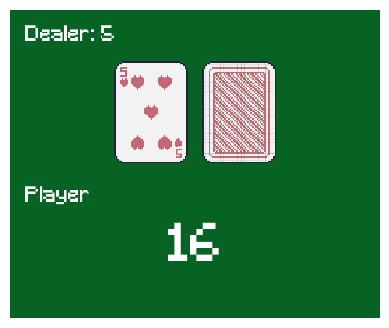

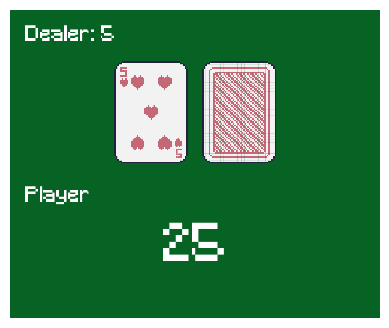

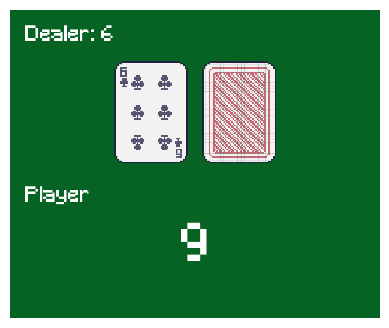

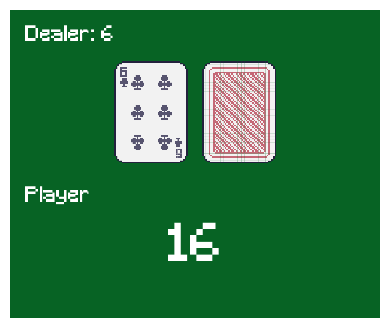

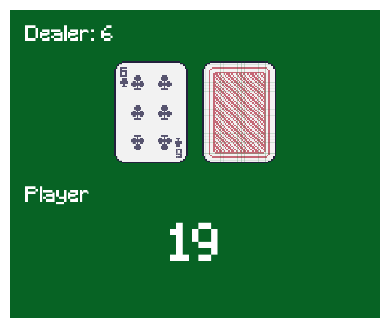

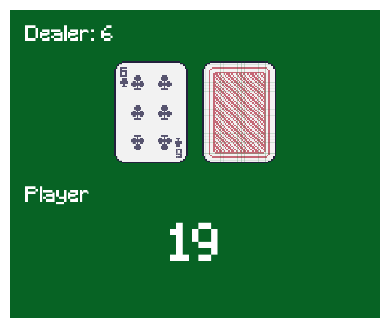

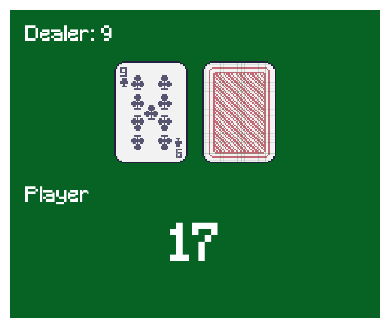

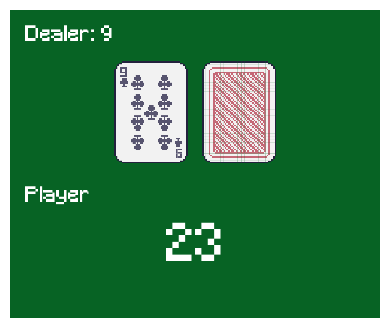

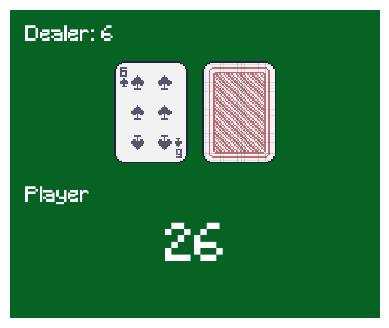

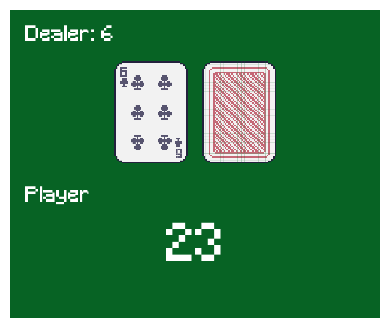

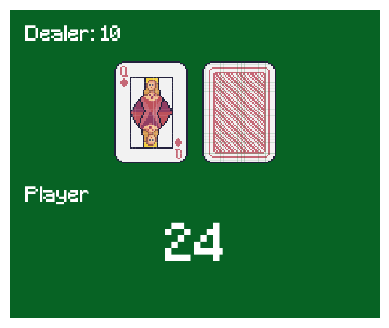

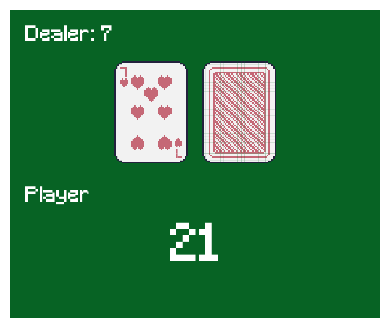

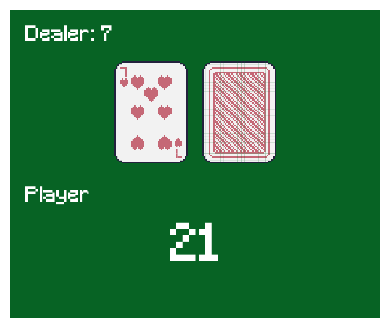

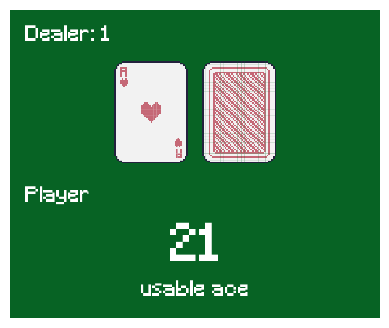

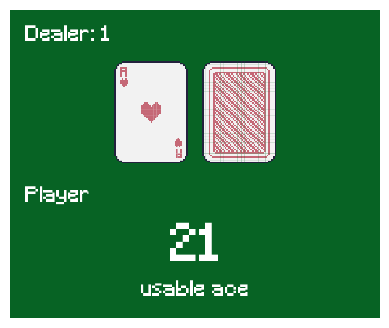

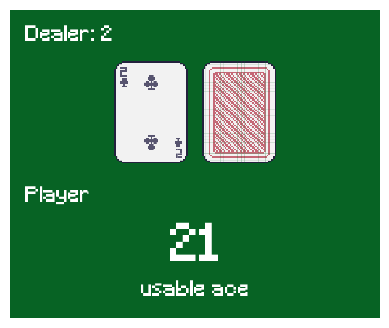

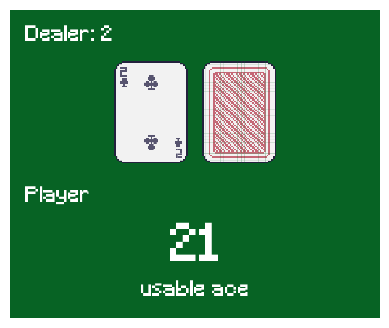

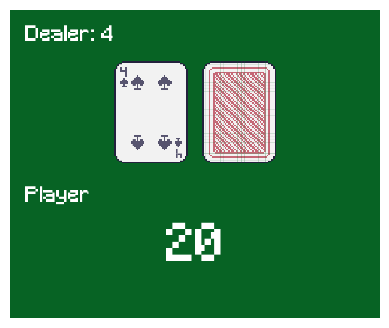

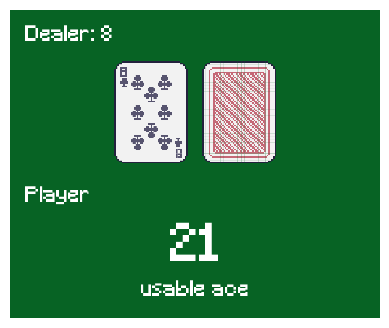

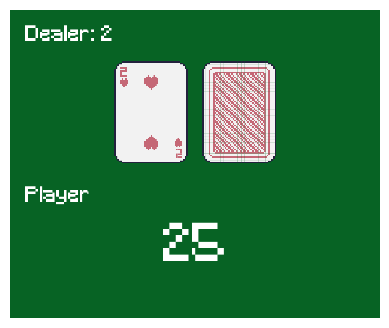

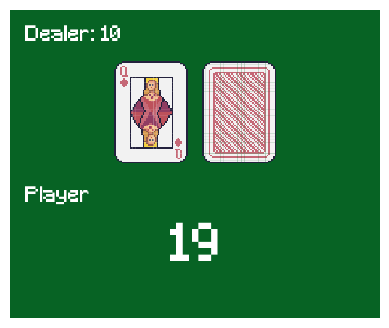

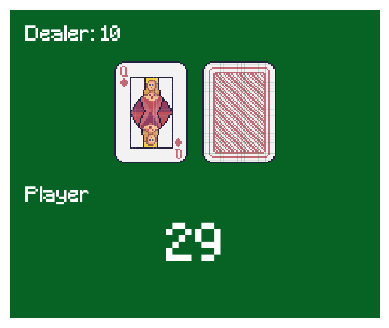

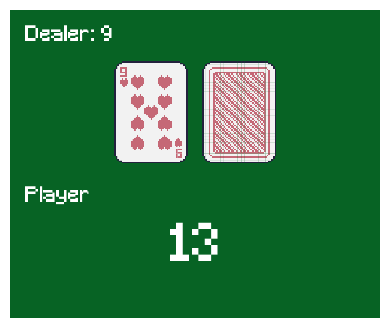

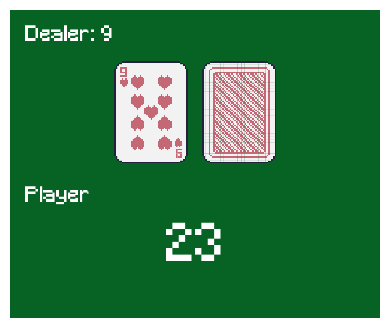

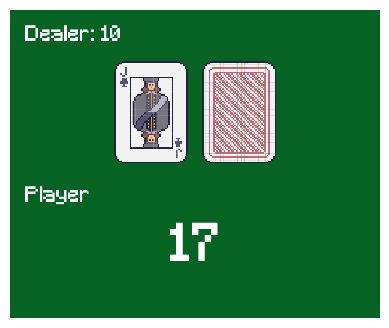

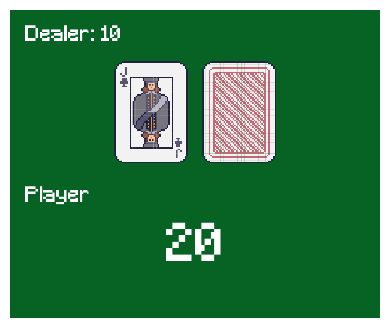

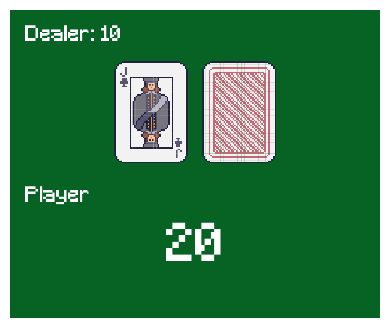

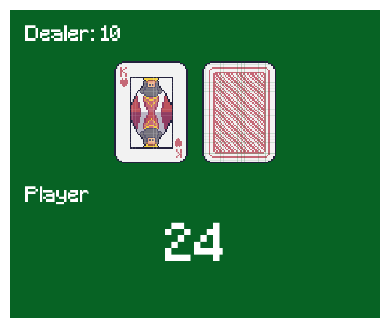

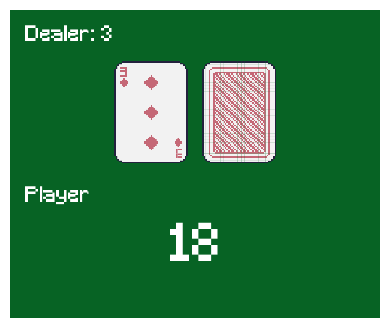

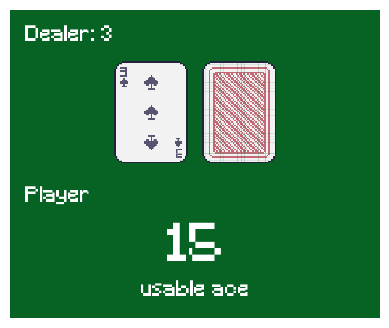

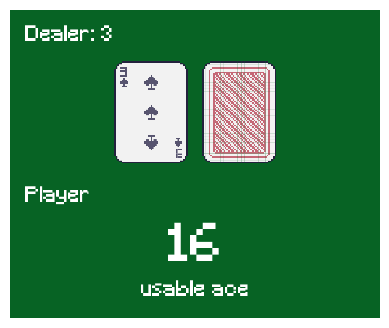

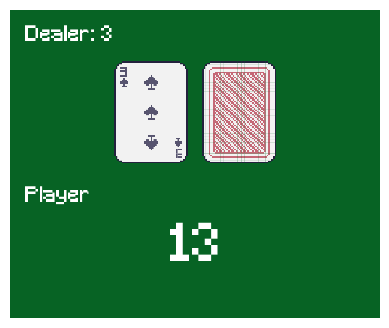

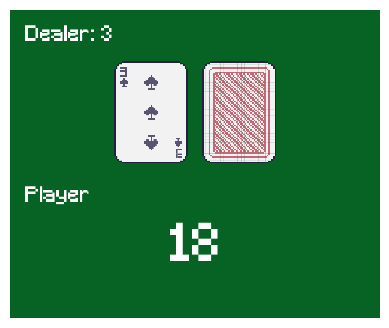

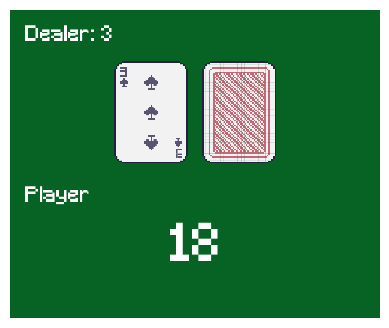

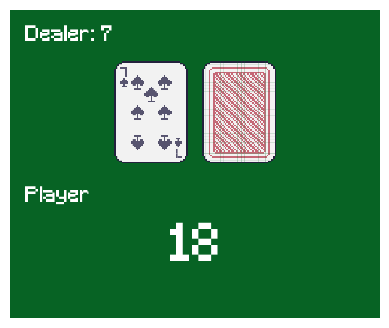

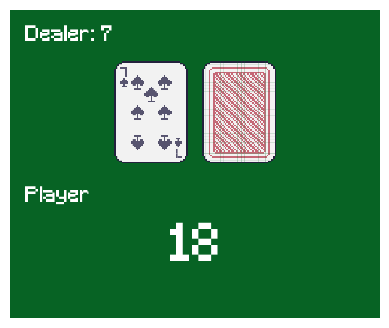

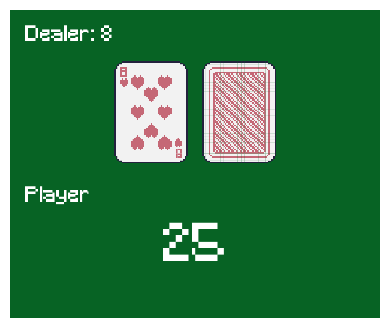

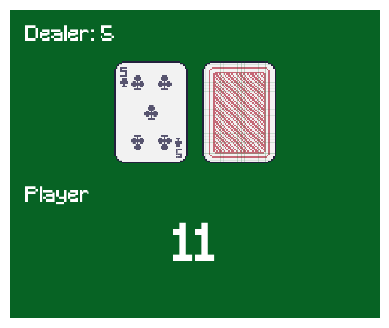

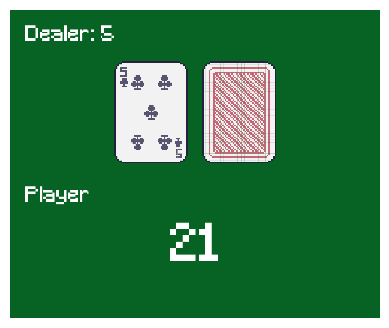

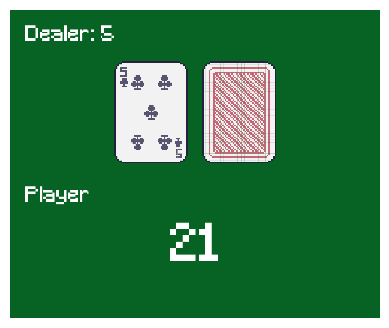

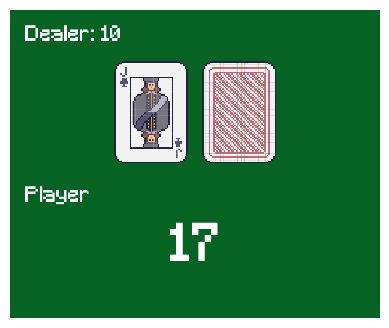

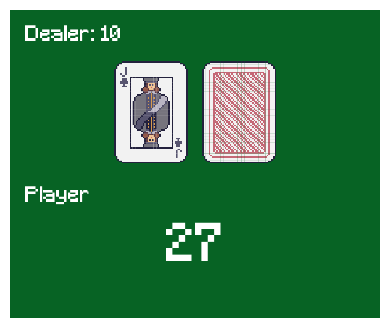

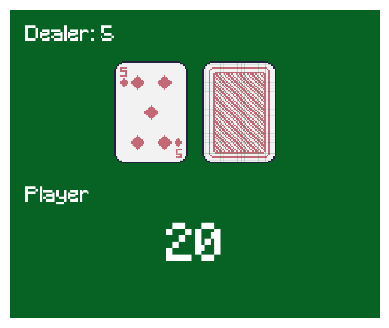

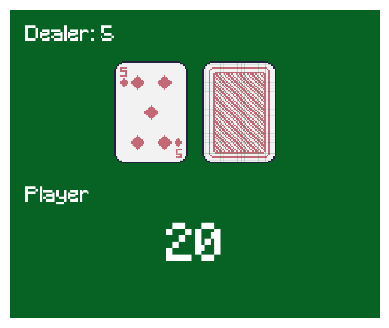

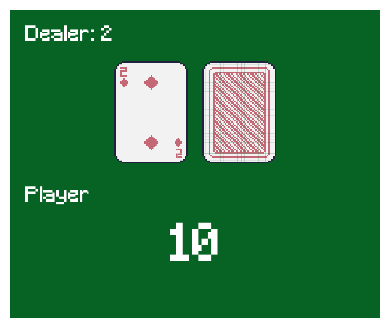

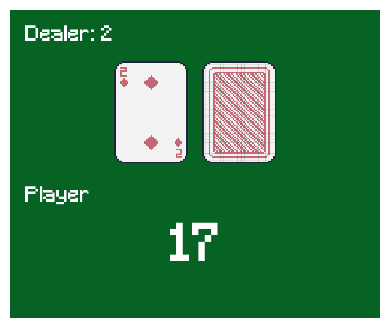

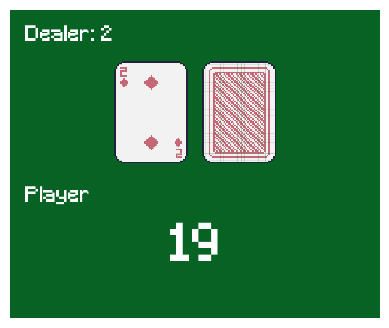

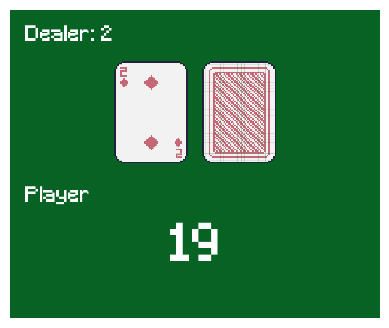

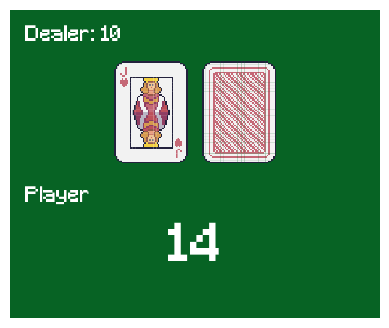

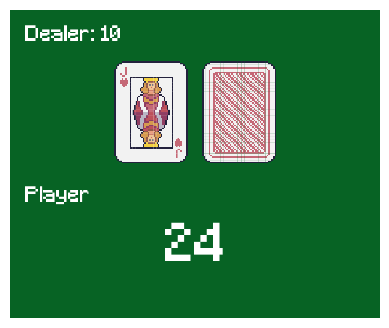

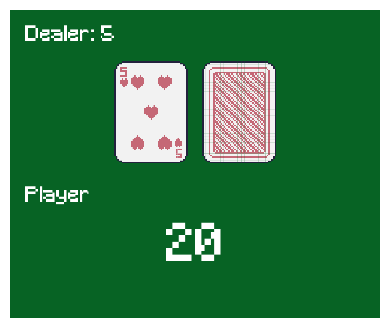

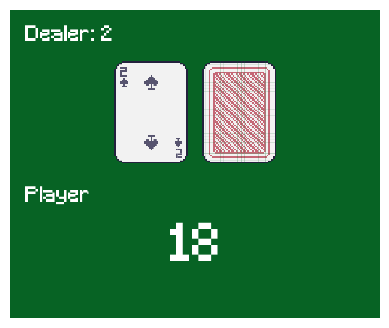

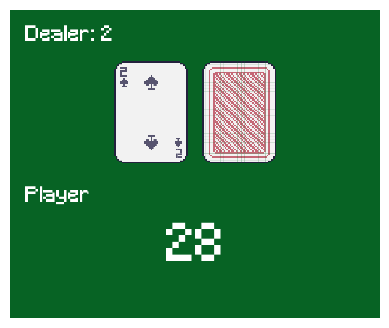

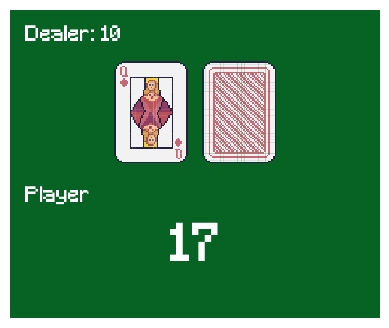

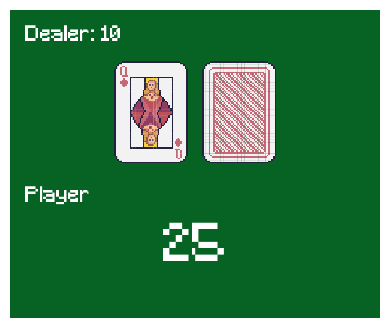

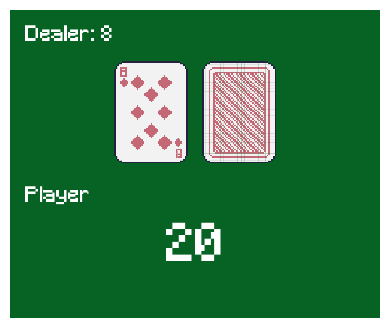

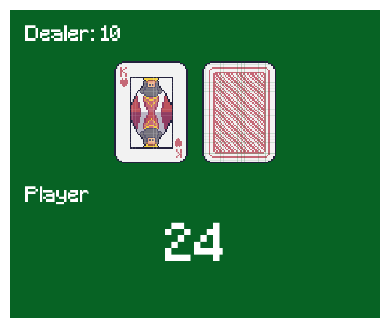

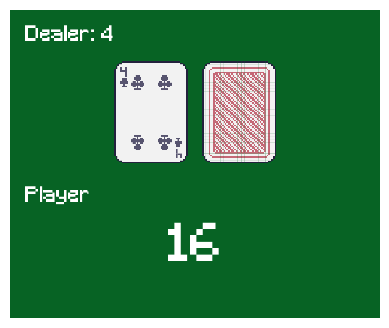

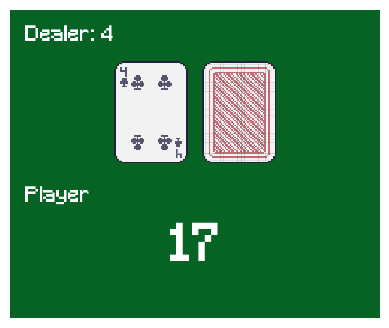

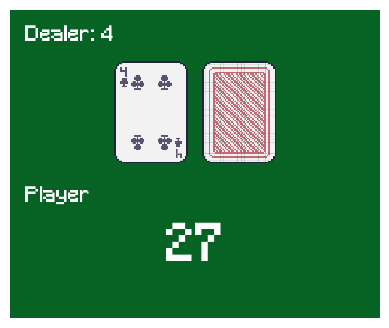

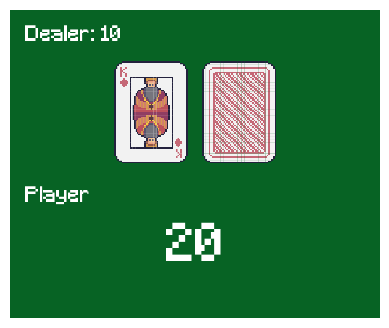

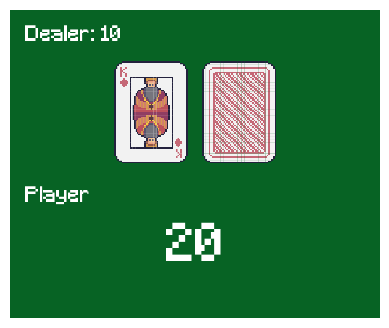

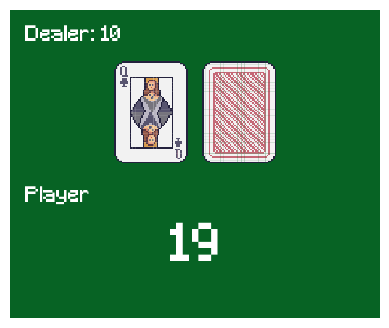

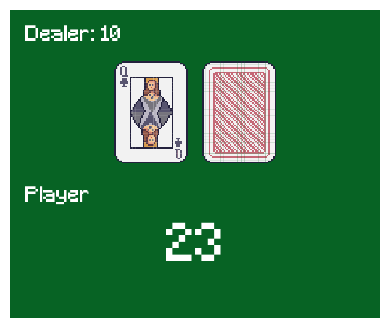

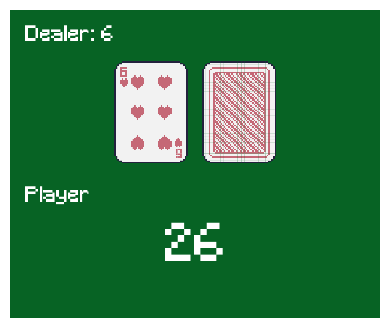

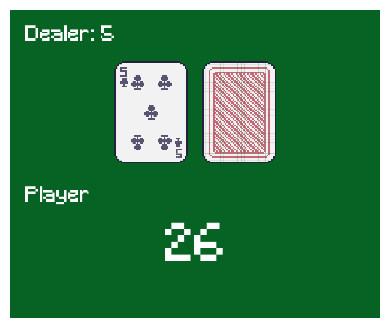

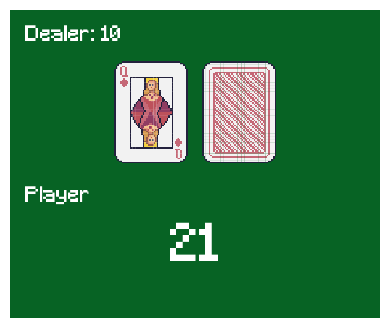

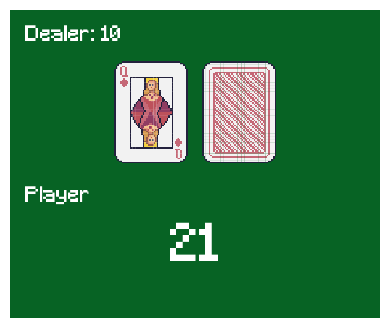

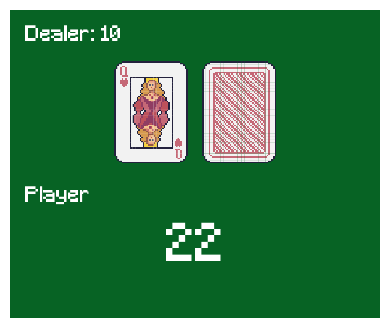

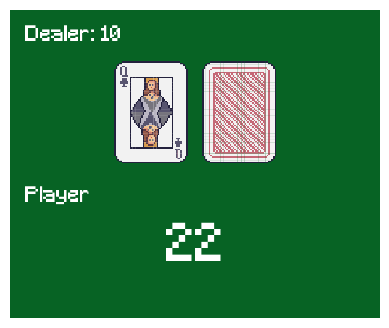

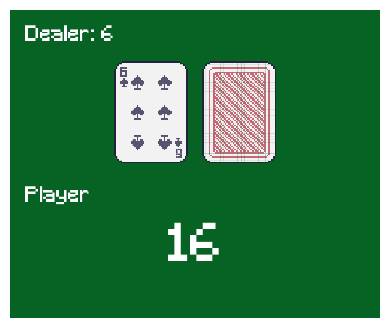

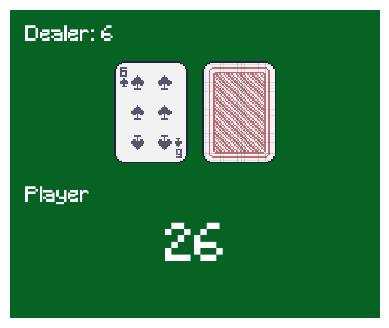

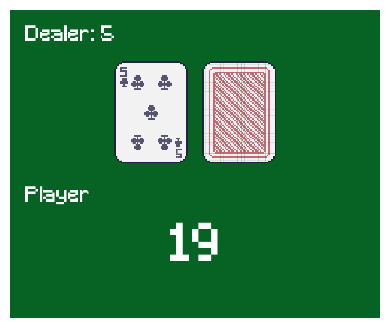

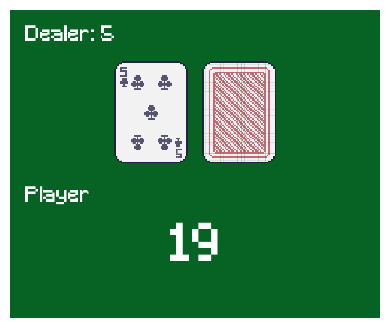

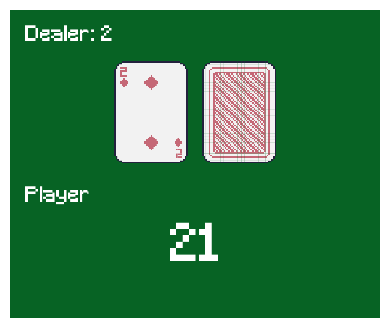

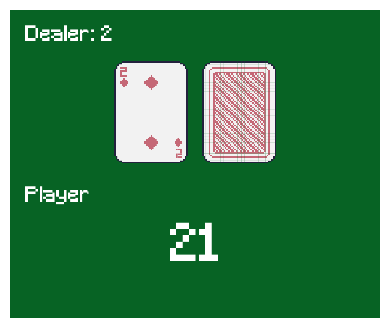

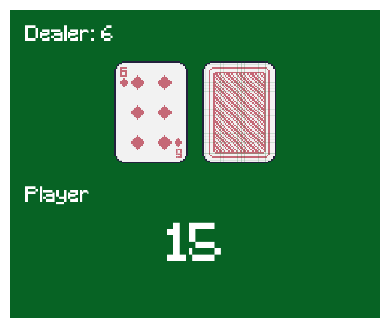

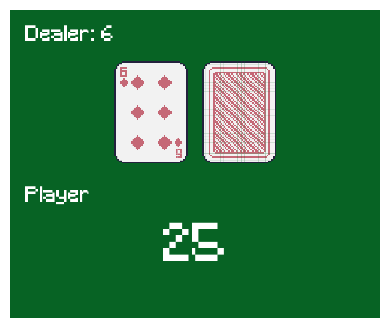

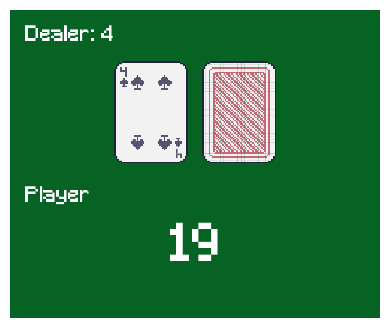

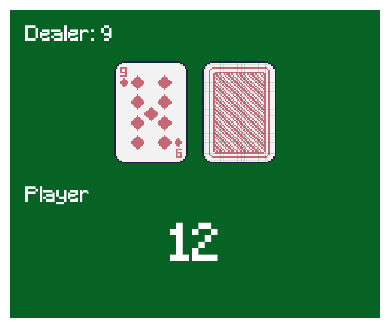

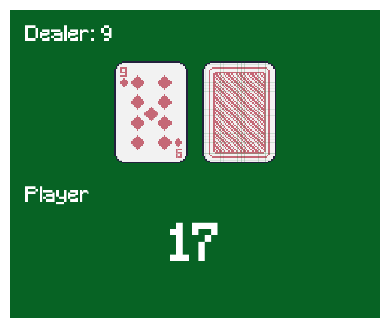

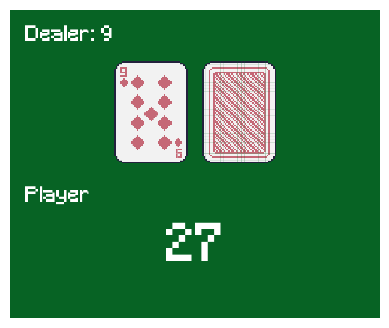

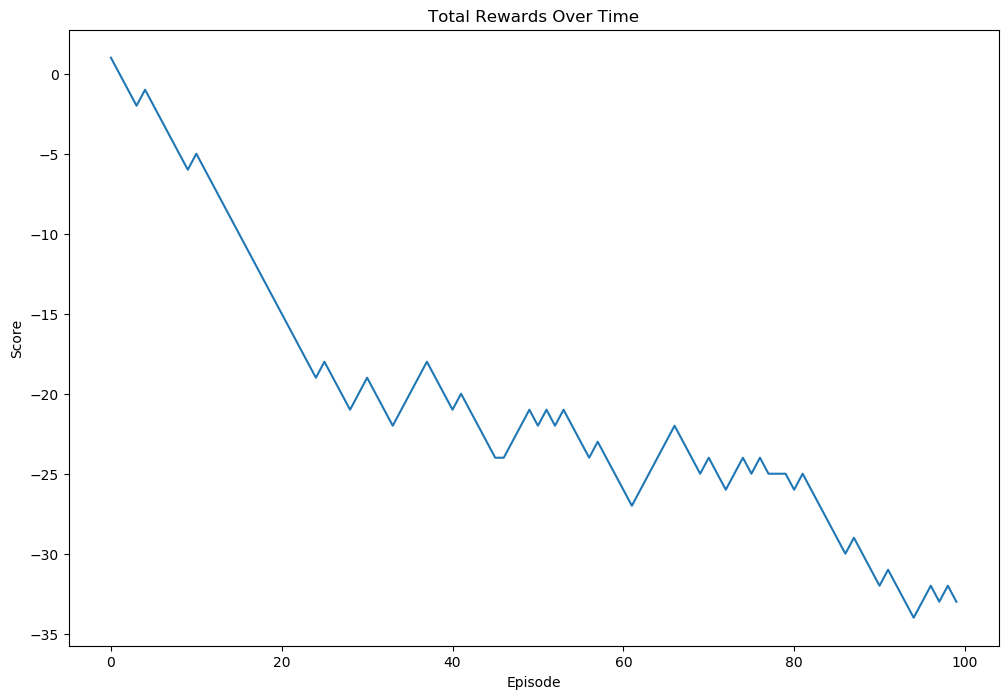

In [169]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(rewards))
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title("Total Rewards Over Time")
plt.show()

# DRL Blackjack

## Import libraries

In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Set Params

In [171]:
BUFFER_SIZE = int(1e3)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 3e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define Neural Network

In [172]:
class QNetwork(nn.Module):
    """
    -------
    Neural Network Used for Agent to Approximate Q-Values
    -------
    [Params]
        'state_size' -> size of the state space
        'action_size' -> size of the action space
        'seed' -> used for random module
    """
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    

## Define Agent Class

This class creates local and target networks and provides methids for activities needed for learning.

In [173]:
class Agent():
    """
    --------
    Deep Q-Learning Agent
    --------
    [Params]
        'state_size' -> size of the state space
        'action_size' -> size of the action space
        'seed' -> used for random module
    --------
    """
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """
        --------------
        Take an action given the current state (S(i))
        --------------
        [Params]
            'state' -> current state
            'eps' -> current epsilon value
        --------------
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state).cpu().data.numpy()
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values), np.max(action_values)
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model: nn.Module, target_model: nn.Module, tau: float):
        """
        --------
        Update our target network with the weights from the local network
        --------
        Formula for each param (w): w_target = τ*w_local + (1 - τ)*w_target
        See https://arxiv.org/pdf/1509.02971.pdf
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

## Create Memeory Deque Class

An instance of this class is used as a recall buffer for DRL

In [174]:
from dataclasses import dataclass

@dataclass
class Experience:
    state: np.ndarray
    action: int
    reward: float
    next_state: np.ndarray
    done: bool

class ReplayBuffer:
    """
    ------------
    Used to store agent experiences
    ------------
    [Params]
        'action_size' -> length of the action space
        'buffer_size' -> Max size of our memory buffer
        'batch_size' -> how many memories to randomly sample
        'seed' -> seed for random module
    ------------
    """
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Train

In [ ]:
from collections import deque

def dqn(n_episodes=2000, eps_start=0.99, eps_end=0.02, eps_decay=0.995):
    """
    -------------
    Train a Deep Q-Learning Agent
    -------------
    [Params]
        'n_episodes' -> number of episodes to train for
        'eps_start' -> epsilon starting value
        'eps_end' -> epsilon minimum value
        'eps_decay' -> how much to decrease epsilon every iteration
    -------------
    """

    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                   
    
    for episode in range(1, n_episodes+1):
        done = False
        episode_score = 0
        
        state, _ = env.reset()                                 # Added _ for new version of gym
        state = np.array(get_state_idxs(state), dtype=float)
        state[0] = state[0]/32
        state[1] = state[1]/10
        
        while not done:
            action = agent.act(state, eps)
            if isinstance(action, tuple):
                action, value = action
            else:
                value = 1.
            next_state, reward, done, _, _ = env.step(action)   # Added second _ for new version of gym
            reward *= value
            next_state = np.array(get_state_idxs(next_state), dtype=float)
            next_state[0] = next_state[0]/32
            next_state[1] = next_state[1]/10
        
            agent.step(state, action, reward, next_state, done)   
            state = next_state
            episode_score += reward
        
        scores_window.append(episode_score)
        scores.append(episode_score)
            
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode % 5000 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            boto3.Session().resource('s3').Bucket(bucket_name).Object('checkpoint.pth').upload_file('checkpoint.pth')
            
    return scores


env = gym.make("Blackjack-v1")
env.action_space.seed(42)

agent = Agent(state_size=3, action_size=2, seed=0)
scores = dqn(n_episodes=70_000)

Episode 5000	Average Score: 0.010
Episode 10000	Average Score: -0.01
Episode 15000	Average Score: -0.01
Episode 20000	Average Score: 0.001
Episode 25000	Average Score: -0.03
Episode 30000	Average Score: 0.000
Episode 31994	Average Score: -0.01

## Test

In [ ]:
env = gym.make("Blackjack-v1", render_mode='rgb_array')    # Added render mode for compatibility
envdisplay = JupyterDisplay(figsize=(10,6))

num_hands = 100

# Load the chekpoint file from S3 to loacl drive
boto3.client('s3').download_file(bucket_name, "checkpoint.pth", "checkpont.pth")
#Load the checkpount.pth from local drive to torch memory
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

results = []
for hand in range(num_hands):
    state, _ = env.reset()                                   # Added _ for new version of gym
    state = np.array(get_state_idxs(state), dtype=float)
    state[0] = state[0]/32
    state[1] = state[1]/10

    done = False
    while not done:
        frame = env.render()        
        action = agent.act(state)
        if isinstance(action, tuple):
            action, value = action
        else:
            value = 1.

        state, reward, done, _, _ = env.step(action)         # Added second _ for new version of gym
        reward *= value
        state = np.array(get_state_idxs(state), dtype=float)
        state[0] = state[0]/32
        state[1] = state[1]/10

    envdisplay.show(env)
    results.append(reward)

env.close()

In [ ]:
batting_avg = np.argwhere(np.array(results) > 0).size / len(results)
print(f"Batting Average: {batting_avg*100:.2f}%")

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(results))
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title("Total Rewards Over Time")
plt.show()

In [ ]:
start_cash = 100.

pct_gain = ((start_cash + np.sum(results)*1000) - 100) / 100
print(f"Percent Gain: {pct_gain*100:.2f}%")
plt.figure(figsize=(12,8))
plt.plot(start_cash + np.cumsum(results)*1000, c="g")
plt.ylabel("Cash ($)")
plt.xlabel("Dealt Hands")
plt.title(f"Total Cash Over Time | Starting Cash: ${int(start_cash)} | Win Pct: {batting_avg:.2f}%", c="darkgreen")
plt.show()

### Analysis
As you can see from the plot above, our agent was rather successful in its gambling degeneracy.
Despite only having a win percentage of 52%, our trained agent was able to net a 558% return over the course of 100 hands. This success is almost solely due to the reward function we crafted, which ultimately taught our agent how to manage risk.